In [1]:
import os

import numpy as np

import tensorflow as tf
from tensorflow import keras



from RoadDataset import RoadDataset

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
val_datasets_path = "../notebooks/datasets/validation/"
sub_dirs = os.listdir(val_datasets_path)
val_dataset_paths = [[val_datasets_path + sub_dir + "/" + sub_dir + ".csv", val_datasets_path + sub_dir + "/frames/"] for sub_dir in sub_dirs]
val_dataset_paths

[['../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/Tag-Sonne-Wolken-Ausserorts.csv',
  '../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/frames/'],
 ['../notebooks/datasets/validation/Nacht-Schneechaos/Nacht-Schneechaos.csv',
  '../notebooks/datasets/validation/Nacht-Schneechaos/frames/']]

In [4]:
dataset_index = 0
column_names = ['filename','steering_wheel_angle','speed', 'blink_l', 'blink_r']
val_set = RoadDataset(val_dataset_paths[dataset_index][0], val_dataset_paths[dataset_index][1], column_names, batch_size=16)
#val_set.clean()

Reading csv file: ../notebooks/datasets/validation/Tag-Sonne-Wolken-Ausserorts/Tag-Sonne-Wolken-Ausserorts.csv
Loaded dataset with 10474 samples


In [5]:
stats = val_set.get_csv().describe()
stats = stats.transpose()
stats

count       mean        std     min     25%    50%  \
steering_wheel_angle  10474.0  -3.780677  64.743614 -483.53  -6.320  -0.75   
speed                 10474.0  48.727898  18.037577    0.00  40.269  51.77   
blink_l               10474.0   0.006301   0.079134    0.00   0.000   0.00   
blink_r               10474.0   0.055662   0.229278    0.00   0.000   0.00   

                         75%      max  
steering_wheel_angle   2.690  496.490  
speed                 59.954   77.066  
blink_l                0.000    1.000  
blink_r                0.000    1.000

In [6]:
#val_set.balance()
val_set.normalize()

In [7]:
stats = val_set.get_csv().describe()
stats = stats.transpose()
stats

count       mean        std       min        25%  \
steering_wheel_angle  10474.0  -0.042008   0.719373 -5.372556  -0.070222   
speed                 10474.0  48.727898  18.037577  0.000000  40.269000   
blink_l               10474.0   0.006301   0.079134  0.000000   0.000000   
blink_r               10474.0   0.055662   0.229278  0.000000   0.000000   

                            50%        75%        max  
steering_wheel_angle  -0.008333   0.029889   5.516556  
speed                 51.770000  59.954000  77.066000  
blink_l                0.000000   0.000000   1.000000  
blink_r                0.000000   0.000000   1.000000

In [8]:
#model_name = 'diypilot_v1'
#model_name = 'diypilot_v2_epoch_10'
#model_name = 'diypilot_v3_epoch_5'
#model_name = 'openpilot_replica_epoch_59'
#model_name = 'openpilot_replica_mae_epoch_100'
#model_name = 'diypilot_v9_small_FC_epoch_3'
#model_name = 'diypilot_v11_random_shifts_epoch_3'
#model_name = 'diypilot_v11_random_shifts_full_balance_epoch_3'
model_name = 'diypilot_v11_full_balance_epoch_10'
loaded_model = keras.models.load_model('./trained_models/' + model_name + '.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 210, 848, 3)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 282, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 102, 138, 16)      2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 69, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 33, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 6, 64)          5

In [9]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from Jetson.autopilot.record.AutopilotGUI import AutopilotGUI

In [10]:
gui = AutopilotGUI()

In [11]:
def show_frame(test_image_index):

    test_sample = val_set.get_frame(test_image_index)
    test_image = test_sample[0]
    test_image_cropped = val_set.get_cropped_frame(test_image_index, shift=0)[0]
    test_labels = test_sample[1]

    print("Test csv: " + str(test_labels))

    test_data = np.expand_dims(test_image_cropped, axis=0)
    predictions = loaded_model.predict(test_data)

    gui.set_frame(test_image)
    gui.set_show_overlay(True)
    gui.set_engaged(False)
    gui.set_recording(True)

    timestamp = test_labels['filename']
    gui.set_timestring(timestamp)

    velocity = test_labels['speed']
    gui.set_velocity(velocity)

    actual_swa = test_labels['steering_wheel_angle']*90
    gui.set_actual_swa(actual_swa)

    predicted_swa = predictions[0][0]*90
    print("Ground-truth: " +str(actual_swa))
    print("Prediction: " + str(predicted_swa))
    gui.set_predicted_swa(predicted_swa)

    gui.show_jupyter()

In [12]:
import ipywidgets as widgets
frame_slider = widgets.IntSlider(min=0, max=val_set.get_batch_size()*len(val_set)-1, continuous_update=False)

In [13]:
from ipywidgets import interact

interact(show_frame, test_image_index=frame_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='test_image_index', max=10463), …

In [14]:
import cv2
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(model_name + '.avi',fourcc, 15.0, (848,480))

In [15]:
framecount = val_set.get_batch_size()*len(val_set)
ground_truth = []
predictions_list = []
velocity_list = []
for i in range(framecount):
    test_sample = val_set.get_frame(i)
    test_image = test_sample[0]
    test_image_cropped = val_set.get_cropped_frame(i, shift = 0)[0]
    test_labels = test_sample[1]

    print("Test csv: " + str(test_labels))

    test_data = np.expand_dims(test_image_cropped, axis=0)
    predictions = loaded_model.predict(test_data)

    gui.set_frame(test_image)
    gui.set_show_overlay(True)
    gui.set_engaged(False)
    gui.set_recording(True)

    timestamp = test_labels['filename']
    gui.set_timestring(timestamp)

    velocity = test_labels['speed']
    velocity_list.append(velocity)
    gui.set_velocity(velocity)

    actual_swa = test_labels['steering_wheel_angle']*90
    ground_truth.append(actual_swa)
    gui.set_actual_swa(actual_swa)

    predicted_swa = predictions[0][0]*90
    predictions_list.append(predicted_swa)
    print("Ground-truth: " +str(actual_swa))
    print("Prediction: " + str(predicted_swa))
    gui.set_predicted_swa(predicted_swa)
    
    gui.render()
    frame = gui.get_rendered_gui()
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    out.write(rgb_frame.astype(np.uint8))
    
out.release()

Test csv: filename                1609088520.3121.jpg
steering_wheel_angle              -0.314444
speed                                     0
blink_l                                   0
blink_r                                   0
Name: 0, dtype: object
Ground-truth: -28.3
Prediction: 12.132772654294968
Test csv: filename                1609088520.5036263.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 1, dtype: object
Ground-truth: -28.3
Prediction: 11.320925652980804
Test csv: filename                1609088520.5699978.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 2, dtype: object
Ground-truth: -28.3
Prediction: 14.324970245361328
Test csv: filename                1609088520.6284947.jpg
s

Test csv: filename                1609088522.3629313.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 29, dtype: object
Ground-truth: -28.3
Prediction: 4.53958947211504
Test csv: filename                1609088522.4303954.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 30, dtype: object
Ground-truth: -28.3
Prediction: 3.610326088964939
Test csv: filename                1609088522.4918652.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 31, dtype: object
Ground-truth: -28.3
Prediction: 4.616832733154297
Test csv: filename                1609088522

Test csv: filename                1609088524.1599658.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 56, dtype: object
Ground-truth: -28.3
Prediction: 2.661832943558693
Test csv: filename                1609088524.228741.jpg
steering_wheel_angle                -0.314444
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 57, dtype: object
Ground-truth: -28.3
Prediction: 6.739285513758659
Test csv: filename                1609088524.2940853.jpg
steering_wheel_angle                 -0.314444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 58, dtype: object
Ground-truth: -28.3
Prediction: 7.775050029158592
Test csv: filename                1609088524.362

Test csv: filename                1609088525.9033237.jpg
steering_wheel_angle                 -0.313778
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 82, dtype: object
Ground-truth: -28.24
Prediction: 12.711681872606277
Test csv: filename                1609088525.969051.jpg
steering_wheel_angle                -0.288667
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 83, dtype: object
Ground-truth: -25.98
Prediction: 17.841579616069794
Test csv: filename                1609088526.0367644.jpg
steering_wheel_angle                 -0.288667
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 84, dtype: object
Ground-truth: -25.98
Prediction: 18.016867339611053
Test csv: filename                16090885

Test csv: filename                1609088527.6943688.jpg
steering_wheel_angle                -0.0264444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 109, dtype: object
Ground-truth: -2.38
Prediction: 14.16613519191742
Test csv: filename                1609088527.7613766.jpg
steering_wheel_angle                -0.0264444
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 110, dtype: object
Ground-truth: -2.38
Prediction: 14.61174800992012
Test csv: filename                1609088527.846182.jpg
steering_wheel_angle               -0.0264444
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 111, dtype: object
Ground-truth: -2.38
Prediction: 8.588098660111427
Test csv: filename                1609088527.

Ground-truth: -2.38
Prediction: 4.364139474928379
Test csv: filename                1609088529.6351843.jpg
steering_wheel_angle                -0.0264444
speed                                    1.891
blink_l                                      0
blink_r                                      0
Name: 138, dtype: object
Ground-truth: -2.38
Prediction: -7.939150929450989
Test csv: filename                1609088529.7037425.jpg
steering_wheel_angle                -0.0264444
speed                                    1.891
blink_l                                      0
blink_r                                      0
Name: 139, dtype: object
Ground-truth: -2.38
Prediction: -6.071554273366928
Test csv: filename                1609088529.7714846.jpg
steering_wheel_angle                -0.0264444
speed                                    1.891
blink_l                                      0
blink_r                                      0
Name: 140, dtype: object
Ground-truth: -2.38
Prediction: -6.448

Test csv: filename                1609088531.5677347.jpg
steering_wheel_angle              -0.000666667
speed                                    2.945
blink_l                                      0
blink_r                                      0
Name: 167, dtype: object
Ground-truth: -0.06
Prediction: -9.315279051661491
Test csv: filename                1609088531.6366732.jpg
steering_wheel_angle              -0.000666667
speed                                    3.069
blink_l                                      0
blink_r                                      0
Name: 168, dtype: object
Ground-truth: -0.06
Prediction: -13.712218254804611
Test csv: filename                1609088531.6999593.jpg
steering_wheel_angle              -0.000666667
speed                                    3.069
blink_l                                      0
blink_r                                      0
Name: 169, dtype: object
Ground-truth: -0.06
Prediction: 2.047991305589676
Test csv: filename                160

Test csv: filename                1609088533.302013.jpg
steering_wheel_angle                  2.58922
speed                                   5.084
blink_l                                     0
blink_r                                     0
Name: 193, dtype: object
Ground-truth: 233.03
Prediction: 5.880095511674881
Test csv: filename                1609088533.3691156.jpg
steering_wheel_angle                   2.87167
speed                                    5.115
blink_l                                      0
blink_r                                      0
Name: 194, dtype: object
Ground-truth: 258.45
Prediction: 0.20959259010851383
Test csv: filename                1609088533.4327006.jpg
steering_wheel_angle                   2.87167
speed                                    5.115
blink_l                                      0
blink_r                                      0
Name: 195, dtype: object
Ground-truth: 258.45
Prediction: -3.024347238242626
Test csv: filename                16090

Ground-truth: 495.17
Prediction: 32.362002432346344
Test csv: filename                1609088535.1018825.jpg
steering_wheel_angle                   5.50189
speed                                    4.185
blink_l                                      0
blink_r                                      0
Name: 220, dtype: object
Ground-truth: 495.17
Prediction: 35.23782402276993
Test csv: filename                1609088535.1769574.jpg
steering_wheel_angle                   5.50333
speed                                     3.72
blink_l                                      0
blink_r                                      0
Name: 221, dtype: object
Ground-truth: 495.30000000000007
Prediction: 30.034671127796173
Test csv: filename                1609088535.2410057.jpg
steering_wheel_angle                   5.50333
speed                                     3.72
blink_l                                      0
blink_r                                      0
Name: 222, dtype: object
Ground-truth: 495.30000

Test csv: filename                1609088536.8319988.jpg
steering_wheel_angle                   1.31133
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 246, dtype: object
Ground-truth: 118.02
Prediction: 36.529543697834015
Test csv: filename                1609088536.9090807.jpg
steering_wheel_angle                   1.31133
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 247, dtype: object
Ground-truth: 118.02
Prediction: 35.04132270812988
Test csv: filename                1609088536.975472.jpg
steering_wheel_angle                 0.679667
speed                                       0
blink_l                                     0
blink_r                                     0
Name: 248, dtype: object
Ground-truth: 61.169999999999995
Prediction: 33.54229509830475
Test csv: filename           

Ground-truth: -455.29
Prediction: -3.814864307641983
Test csv: filename                1609088538.704986.jpg
steering_wheel_angle                 -5.14089
speed                                   3.193
blink_l                                     0
blink_r                                     0
Name: 274, dtype: object
Ground-truth: -462.68
Prediction: -1.3960277661681175
Test csv: filename                1609088538.7747993.jpg
steering_wheel_angle                  -5.20622
speed                                    3.689
blink_l                                      0
blink_r                                      0
Name: 275, dtype: object
Ground-truth: -468.56
Prediction: 18.95003467798233
Test csv: filename                1609088538.8705413.jpg
steering_wheel_angle                  -5.24733
speed                                    3.689
blink_l                                      0
blink_r                                      0
Name: 276, dtype: object
Ground-truth: -472.26000000000005
Pr

Test csv: filename                1609088540.5443618.jpg
steering_wheel_angle                  -4.29144
speed                                    7.409
blink_l                                      0
blink_r                                      0
Name: 301, dtype: object
Ground-truth: -386.2300000000001
Prediction: 8.834062591195107
Test csv: filename                1609088540.6116965.jpg
steering_wheel_angle                  -4.02711
speed                                     7.75
blink_l                                      0
blink_r                                      0
Name: 302, dtype: object
Ground-truth: -362.44
Prediction: -0.992627302184701
Test csv: filename                1609088540.6858568.jpg
steering_wheel_angle                  -3.76556
speed                                     7.75
blink_l                                      0
blink_r                                      0
Name: 303, dtype: object
Ground-truth: -338.9
Prediction: 24.48425531387329
Test csv: filename     

Test csv: filename                1609088542.4854896.jpg
steering_wheel_angle                -0.0382222
speed                                   12.338
blink_l                                      0
blink_r                                      0
Name: 329, dtype: object
Ground-truth: -3.44
Prediction: 12.750484049320221
Test csv: filename                1609088542.5421772.jpg
steering_wheel_angle                -0.0382222
speed                                   12.338
blink_l                                      0
blink_r                                      0
Name: 330, dtype: object
Ground-truth: -3.44
Prediction: 10.57158350944519
Test csv: filename                1609088542.5954194.jpg
steering_wheel_angle                -0.0382222
speed                                   12.958
blink_l                                      0
blink_r                                      0
Name: 331, dtype: object
Ground-truth: -3.44
Prediction: 5.074665360152721
Test csv: filename                16090

Test csv: filename                1609088544.466262.jpg
steering_wheel_angle               0.00766667
speed                                  13.206
blink_l                                     0
blink_r                                     0
Name: 357, dtype: object
Ground-truth: 0.69
Prediction: 10.663066282868385
Test csv: filename                1609088544.5075624.jpg
steering_wheel_angle                 0.0111111
speed                                   13.206
blink_l                                      0
blink_r                                      0
Name: 358, dtype: object
Ground-truth: 1.0
Prediction: 21.010047644376755
Test csv: filename                1609088544.5726976.jpg
steering_wheel_angle                 0.0125556
speed                                   13.175
blink_l                                      0
blink_r                                      0
Name: 359, dtype: object
Ground-truth: 1.13
Prediction: 30.5511412024498
Test csv: filename                1609088544.670

Test csv: filename                1609088546.4847662.jpg
steering_wheel_angle                  0.303333
speed                                    6.572
blink_l                                      0
blink_r                                      0
Name: 385, dtype: object
Ground-truth: 27.3
Prediction: 3.431548811495304
Test csv: filename                1609088546.5366561.jpg
steering_wheel_angle                  0.303333
speed                                    6.572
blink_l                                      0
blink_r                                      0
Name: 386, dtype: object
Ground-truth: 27.3
Prediction: 12.739390432834625
Test csv: filename                1609088546.6060863.jpg
steering_wheel_angle                  0.304667
speed                                    5.363
blink_l                                      0
blink_r                                      0
Name: 387, dtype: object
Ground-truth: 27.42
Prediction: 7.8945571929216385
Test csv: filename                160908

Test csv: filename                1609088548.4731905.jpg
steering_wheel_angle                  0.300556
speed                                     2.48
blink_l                                      0
blink_r                                      0
Name: 413, dtype: object
Ground-truth: 27.05
Prediction: -25.39566993713379
Test csv: filename                1609088548.5879517.jpg
steering_wheel_angle                  0.298444
speed                                    2.356
blink_l                                      0
blink_r                                      0
Name: 414, dtype: object
Ground-truth: 26.86
Prediction: -24.83917862176895
Test csv: filename                1609088548.7233098.jpg
steering_wheel_angle                  0.298444
speed                                    2.356
blink_l                                      0
blink_r                                      0
Name: 415, dtype: object
Ground-truth: 26.86
Prediction: -13.413184136152267
Test csv: filename                16

Ground-truth: 3.57
Prediction: -11.788540631532669
Test csv: filename                1609088550.7281432.jpg
steering_wheel_angle                 0.0396667
speed                                    5.332
blink_l                                      0
blink_r                                      0
Name: 441, dtype: object
Ground-truth: 3.57
Prediction: -11.825441122055054
Test csv: filename                1609088550.7947164.jpg
steering_wheel_angle                 0.0396667
speed                                    5.952
blink_l                                      0
blink_r                                      0
Name: 442, dtype: object
Ground-truth: 3.57
Prediction: -25.52196979522705
Test csv: filename                1609088550.8638554.jpg
steering_wheel_angle                     0.039
speed                                    5.952
blink_l                                      0
blink_r                                      0
Name: 443, dtype: object
Ground-truth: 3.51
Prediction: -14.335

Ground-truth: 21.98
Prediction: -24.089208841323853
Test csv: filename                1609088552.6101077.jpg
steering_wheel_angle                  0.244222
speed                                   10.261
blink_l                                      0
blink_r                                      0
Name: 469, dtype: object
Ground-truth: 21.98
Prediction: -16.000550240278244
Test csv: filename                1609088552.6555336.jpg
steering_wheel_angle                  0.244222
speed                                   10.261
blink_l                                      0
blink_r                                      0
Name: 470, dtype: object
Ground-truth: 21.98
Prediction: -4.337990619242191
Test csv: filename                1609088552.7154877.jpg
steering_wheel_angle                  0.244222
speed                                   10.261
blink_l                                      0
blink_r                                      0
Name: 471, dtype: object
Ground-truth: 21.98
Prediction: -10

Ground-truth: 23.42
Prediction: -9.783983007073402
Test csv: filename                1609088554.4575748.jpg
steering_wheel_angle                  0.258111
speed                                   17.019
blink_l                                      0
blink_r                                      0
Name: 497, dtype: object
Ground-truth: 23.23
Prediction: -10.28974436223507
Test csv: filename                1609088554.5151455.jpg
steering_wheel_angle                  0.258111
speed                                   17.019
blink_l                                      0
blink_r                                      0
Name: 498, dtype: object
Ground-truth: 23.23
Prediction: -15.640305429697037
Test csv: filename                1609088554.6035383.jpg
steering_wheel_angle                  0.246222
speed                                   16.802
blink_l                                      0
blink_r                                      0
Name: 499, dtype: object
Ground-truth: 22.16
Prediction: -1.6

Test csv: filename                1609088556.29465.jpg
steering_wheel_angle                  -0.473
speed                                 20.646
blink_l                                    0
blink_r                                    0
Name: 524, dtype: object
Ground-truth: -42.57
Prediction: -13.503968864679337
Test csv: filename                1609088556.344119.jpg
steering_wheel_angle                   -0.473
speed                                  20.646
blink_l                                     0
blink_r                                     0
Name: 525, dtype: object
Ground-truth: -42.57
Prediction: -4.924751333892345
Test csv: filename                1609088556.4012456.jpg
steering_wheel_angle                 -0.453556
speed                                   21.669
blink_l                                      0
blink_r                                      0
Name: 526, dtype: object
Ground-truth: -40.82
Prediction: -17.311019897460938
Test csv: filename                1609088556.45

Test csv: filename                1609088558.0184517.jpg
steering_wheel_angle                 0.0354444
speed                                   25.079
blink_l                                      0
blink_r                                      0
Name: 550, dtype: object
Ground-truth: 3.19
Prediction: -2.93968565762043
Test csv: filename                1609088558.0854685.jpg
steering_wheel_angle                 0.0514444
speed                                   25.079
blink_l                                      0
blink_r                                      0
Name: 551, dtype: object
Ground-truth: 4.63
Prediction: 8.019682243466377
Test csv: filename                1609088558.1393592.jpg
steering_wheel_angle                 0.0772222
speed                                    25.42
blink_l                                      0
blink_r                                      0
Name: 552, dtype: object
Ground-truth: 6.95
Prediction: -0.21652157418429852
Test csv: filename                160908

Test csv: filename                1609088559.8817353.jpg
steering_wheel_angle                 0.0473333
speed                                   25.358
blink_l                                      0
blink_r                                      0
Name: 578, dtype: object
Ground-truth: 4.26
Prediction: -18.299369663000107
Test csv: filename                1609088559.9519439.jpg
steering_wheel_angle                 0.0465556
speed                                    25.11
blink_l                                      0
blink_r                                      0
Name: 579, dtype: object
Ground-truth: 4.19
Prediction: -7.143098786473274
Test csv: filename                1609088560.025291.jpg
steering_wheel_angle                0.0465556
speed                                   25.11
blink_l                                     0
blink_r                                     0
Name: 580, dtype: object
Ground-truth: 4.19
Prediction: -5.626584514975548
Test csv: filename                1609088560

Test csv: filename                1609088561.6960506.jpg
steering_wheel_angle                0.00622222
speed                                   20.274
blink_l                                      0
blink_r                                      0
Name: 605, dtype: object
Ground-truth: 0.56
Prediction: -10.358771681785583
Test csv: filename                1609088561.7360423.jpg
steering_wheel_angle                0.00622222
speed                                   20.274
blink_l                                      0
blink_r                                      0
Name: 606, dtype: object
Ground-truth: 0.56
Prediction: 0.611457321792841
Test csv: filename                1609088561.8138597.jpg
steering_wheel_angle                0.00344444
speed                                   20.274
blink_l                                      0
blink_r                                      1
Name: 607, dtype: object
Ground-truth: 0.31
Prediction: 8.765350431203842
Test csv: filename                1609088

Ground-truth: -12.21
Prediction: -5.810585394501686
Test csv: filename                1609088563.527624.jpg
steering_wheel_angle                -0.135667
speed                                   8.463
blink_l                                     0
blink_r                                     1
Name: 633, dtype: object
Ground-truth: -12.21
Prediction: 3.3258600533008575
Test csv: filename                1609088563.62176.jpg
steering_wheel_angle               -0.132889
speed                                  6.882
blink_l                                    0
blink_r                                    1
Name: 634, dtype: object
Ground-truth: -11.96
Prediction: 6.041980907320976
Test csv: filename                1609088563.6631606.jpg
steering_wheel_angle                 -0.145444
speed                                    6.882
blink_l                                      0
blink_r                                      1
Name: 635, dtype: object
Ground-truth: -13.089999999999998
Prediction: 11.8

Ground-truth: -195.97
Prediction: -5.555563308298588
Test csv: filename                1609088565.4021392.jpg
steering_wheel_angle                  -2.42778
speed                                    5.177
blink_l                                      0
blink_r                                      1
Name: 661, dtype: object
Ground-truth: -218.49999999999997
Prediction: 10.33694788813591
Test csv: filename                1609088565.4529283.jpg
steering_wheel_angle                  -2.66222
speed                                    5.177
blink_l                                      0
blink_r                                      1
Name: 662, dtype: object
Ground-truth: -239.6
Prediction: 10.005733966827393
Test csv: filename                1609088565.526833.jpg
steering_wheel_angle                 -2.66222
speed                                   5.177
blink_l                                     0
blink_r                                     1
Name: 663, dtype: object
Ground-truth: -239.6
Predi

Ground-truth: -320.87
Prediction: -15.68305715918541
Test csv: filename                1609088567.2769904.jpg
steering_wheel_angle                  -3.45456
speed                                   11.563
blink_l                                      0
blink_r                                      1
Name: 689, dtype: object
Ground-truth: -310.91
Prediction: 19.145506024360657
Test csv: filename                1609088567.3531451.jpg
steering_wheel_angle                  -3.45456
speed                                   11.563
blink_l                                      0
blink_r                                      1
Name: 690, dtype: object
Ground-truth: -310.91
Prediction: -5.781832784414291
Test csv: filename                1609088567.399174.jpg
steering_wheel_angle                 -3.37044
speed                                  12.369
blink_l                                     0
blink_r                                     1
Name: 691, dtype: object
Ground-truth: -303.34
Prediction: 3.

Test csv: filename                1609088569.0660052.jpg
steering_wheel_angle                    -0.441
speed                                   16.337
blink_l                                      0
blink_r                                      0
Name: 716, dtype: object
Ground-truth: -39.69
Prediction: -16.868568062782288
Test csv: filename                1609088569.1286588.jpg
steering_wheel_angle                    -0.441
speed                                   16.337
blink_l                                      0
blink_r                                      0
Name: 717, dtype: object
Ground-truth: -39.69
Prediction: -21.295315325260162
Test csv: filename                1609088569.1953666.jpg
steering_wheel_angle                 -0.347778
speed                                   17.577
blink_l                                      0
blink_r                                      0
Name: 718, dtype: object
Ground-truth: -31.3
Prediction: -17.999207675457
Test csv: filename                1

Test csv: filename                1609088570.9248648.jpg
steering_wheel_angle                 -0.123778
speed                                   23.994
blink_l                                      0
blink_r                                      0
Name: 744, dtype: object
Ground-truth: -11.14
Prediction: -12.103324681520462
Test csv: filename                1609088571.0100682.jpg
steering_wheel_angle                 -0.123778
speed                                   24.428
blink_l                                      0
blink_r                                      0
Name: 745, dtype: object
Ground-truth: -11.14
Prediction: -14.919012486934662
Test csv: filename                1609088571.0612943.jpg
steering_wheel_angle                 -0.128667
speed                                   24.428
blink_l                                      0
blink_r                                      0
Name: 746, dtype: object
Ground-truth: -11.580000000000002
Prediction: -30.91163009405136
Test csv: filename 

Test csv: filename                1609088572.8432035.jpg
steering_wheel_angle                 -0.218444
speed                                   27.187
blink_l                                      0
blink_r                                      0
Name: 772, dtype: object
Ground-truth: -19.66
Prediction: -18.18229928612709
Test csv: filename                1609088572.9010034.jpg
steering_wheel_angle                 -0.219111
speed                                   27.187
blink_l                                      0
blink_r                                      0
Name: 773, dtype: object
Ground-truth: -19.72
Prediction: -25.781245529651642
Test csv: filename                1609088572.9584222.jpg
steering_wheel_angle                 -0.222556
speed                                   26.846
blink_l                                      0
blink_r                                      0
Name: 774, dtype: object
Ground-truth: -20.03
Prediction: -16.2214033305645
Test csv: filename                

Ground-truth: -12.770000000000001
Prediction: -10.893357396125793
Test csv: filename                1609088574.6078036.jpg
steering_wheel_angle                 -0.123778
speed                                   29.264
blink_l                                      0
blink_r                                      0
Name: 799, dtype: object
Ground-truth: -11.14
Prediction: -6.8962376564741135
Test csv: filename                1609088574.6630757.jpg
steering_wheel_angle                    -0.121
speed                                   29.264
blink_l                                      0
blink_r                                      0
Name: 800, dtype: object
Ground-truth: -10.89
Prediction: -8.386194035410881
Test csv: filename                1609088574.730826.jpg
steering_wheel_angle                   -0.121
speed                                  29.264
blink_l                                     0
blink_r                                     0
Name: 801, dtype: object
Ground-truth: -10.89
Pre

Ground-truth: -4.01
Prediction: -17.601365000009537
Test csv: filename                1609088576.4011004.jpg
steering_wheel_angle                -0.0437778
speed                                   36.611
blink_l                                      0
blink_r                                      0
Name: 826, dtype: object
Ground-truth: -3.94
Prediction: -23.24122041463852
Test csv: filename                1609088576.4596753.jpg
steering_wheel_angle                -0.0445556
speed                                   36.611
blink_l                                      0
blink_r                                      0
Name: 827, dtype: object
Ground-truth: -4.01
Prediction: -20.021229833364487
Test csv: filename                1609088576.5384293.jpg
steering_wheel_angle                -0.0445556
speed                                   36.611
blink_l                                      0
blink_r                                      0
Name: 828, dtype: object
Ground-truth: -4.01
Prediction: -3.

Test csv: filename                1609088578.2100468.jpg
steering_wheel_angle                -0.0334444
speed                                   40.052
blink_l                                      0
blink_r                                      0
Name: 853, dtype: object
Ground-truth: -3.01
Prediction: 9.724837616086006
Test csv: filename                1609088578.270192.jpg
steering_wheel_angle               -0.0277778
speed                                  40.052
blink_l                                     0
blink_r                                     0
Name: 854, dtype: object
Ground-truth: -2.5
Prediction: 14.70325157046318
Test csv: filename                1609088578.333813.jpg
steering_wheel_angle               -0.0277778
speed                                  40.052
blink_l                                     0
blink_r                                     0
Name: 855, dtype: object
Ground-truth: -2.5
Prediction: 17.683091908693314
Test csv: filename                1609088578.405735

Test csv: filename                1609088580.0856993.jpg
steering_wheel_angle                 0.0326667
speed                                   39.525
blink_l                                      0
blink_r                                      0
Name: 881, dtype: object
Ground-truth: 2.9399999999999995
Prediction: -3.73458880931139
Test csv: filename                1609088580.132998.jpg
steering_wheel_angle                0.0326667
speed                                  39.525
blink_l                                     0
blink_r                                     0
Name: 882, dtype: object
Ground-truth: 2.9399999999999995
Prediction: -3.274727091193199
Test csv: filename                1609088580.2140722.jpg
steering_wheel_angle                 0.0326667
speed                                   39.339
blink_l                                      0
blink_r                                      0
Name: 883, dtype: object
Ground-truth: 2.9399999999999995
Prediction: 3.2039325311779976
Test

Test csv: filename                1609088581.8795028.jpg
steering_wheel_angle                -0.0181111
speed                                   39.277
blink_l                                      0
blink_r                                      0
Name: 908, dtype: object
Ground-truth: -1.63
Prediction: -35.290955901145935
Test csv: filename                1609088581.9355617.jpg
steering_wheel_angle                -0.0215556
speed                                   39.277
blink_l                                      0
blink_r                                      0
Name: 909, dtype: object
Ground-truth: -1.9399999999999997
Prediction: -35.2028426527977
Test csv: filename                1609088582.0074828.jpg
steering_wheel_angle                -0.0215556
speed                                   39.215
blink_l                                      0
blink_r                                      0
Name: 910, dtype: object
Ground-truth: -1.9399999999999997
Prediction: -26.147399246692657
Test csv

Test csv: filename                1609088583.6757503.jpg
steering_wheel_angle                -0.0215556
speed                                   40.579
blink_l                                      0
blink_r                                      0
Name: 935, dtype: object
Ground-truth: -1.9399999999999997
Prediction: 9.600515216588974
Test csv: filename                1609088583.745147.jpg
steering_wheel_angle               -0.0215556
speed                                  40.579
blink_l                                     0
blink_r                                     0
Name: 936, dtype: object
Ground-truth: -1.9399999999999997
Prediction: 12.193539440631866
Test csv: filename                1609088583.8108013.jpg
steering_wheel_angle                -0.0202222
speed                                   40.703
blink_l                                      0
blink_r                                      0
Name: 937, dtype: object
Ground-truth: -1.8199999999999998
Prediction: 13.842507898807526
T

Ground-truth: -1.44
Prediction: -2.7540476247668266
Test csv: filename                1609088585.545512.jpg
steering_wheel_angle               -0.0145556
speed                                  41.106
blink_l                                     0
blink_r                                     0
Name: 963, dtype: object
Ground-truth: -1.31
Prediction: -2.9656048491597176
Test csv: filename                1609088585.6106336.jpg
steering_wheel_angle                -0.0145556
speed                                    41.23
blink_l                                      0
blink_r                                      0
Name: 964, dtype: object
Ground-truth: -1.31
Prediction: -5.4657431691884995
Test csv: filename                1609088585.6748788.jpg
steering_wheel_angle               -0.00833333
speed                                    41.23
blink_l                                      0
blink_r                                      0
Name: 965, dtype: object
Ground-truth: -0.75
Prediction: -3.1780

Ground-truth: 1.38
Prediction: -3.2060886919498444
Test csv: filename                1609088587.4095688.jpg
steering_wheel_angle                 0.0153333
speed                                    41.54
blink_l                                      0
blink_r                                      0
Name: 991, dtype: object
Ground-truth: 1.38
Prediction: -0.9975306317210197
Test csv: filename                1609088587.4815269.jpg
steering_wheel_angle                 0.0132222
speed                                    41.54
blink_l                                      0
blink_r                                      0
Name: 992, dtype: object
Ground-truth: 1.19
Prediction: 6.402397379279137
Test csv: filename                1609088587.5450938.jpg
steering_wheel_angle                 0.0104444
speed                                    41.54
blink_l                                      0
blink_r                                      0
Name: 993, dtype: object
Ground-truth: 0.94
Prediction: 8.211340

Ground-truth: 2.25
Prediction: 14.66751515865326
Test csv: filename                1609088589.2673583.jpg
steering_wheel_angle                     0.048
speed                                   42.532
blink_l                                      0
blink_r                                      0
Name: 1019, dtype: object
Ground-truth: 4.32
Prediction: 18.26742321252823
Test csv: filename                1609088589.3401854.jpg
steering_wheel_angle                 0.0688889
speed                                   42.532
blink_l                                      0
blink_r                                      0
Name: 1020, dtype: object
Ground-truth: 6.2
Prediction: 23.001685738563538
Test csv: filename                1609088589.4068463.jpg
steering_wheel_angle                 0.0688889
speed                                   42.594
blink_l                                      0
blink_r                                      0
Name: 1021, dtype: object
Ground-truth: 6.2
Prediction: 19.5115417

Ground-truth: 22.6
Prediction: 46.956183314323425
Test csv: filename                1609088591.1388361.jpg
steering_wheel_angle                  0.251111
speed                                   43.431
blink_l                                      0
blink_r                                      0
Name: 1047, dtype: object
Ground-truth: 22.6
Prediction: 48.61597180366516
Test csv: filename                1609088591.2087314.jpg
steering_wheel_angle                  0.251111
speed                                   43.524
blink_l                                      0
blink_r                                      0
Name: 1048, dtype: object
Ground-truth: 22.6
Prediction: 49.681060910224915
Test csv: filename                1609088591.2856526.jpg
steering_wheel_angle                  0.252556
speed                                   43.524
blink_l                                      0
blink_r                                      0
Name: 1049, dtype: object
Ground-truth: 22.729999999999997
Predi

Ground-truth: 20.66
Prediction: 32.72858262062073
Test csv: filename                1609088593.0079246.jpg
steering_wheel_angle                  0.229556
speed                                   44.578
blink_l                                      0
blink_r                                      0
Name: 1075, dtype: object
Ground-truth: 20.66
Prediction: 28.47297102212906
Test csv: filename                1609088593.082537.jpg
steering_wheel_angle                 0.229556
speed                                  44.578
blink_l                                     0
blink_r                                     0
Name: 1076, dtype: object
Ground-truth: 20.66
Prediction: 32.01733857393265
Test csv: filename                1609088593.1467252.jpg
steering_wheel_angle                  0.229556
speed                                   45.074
blink_l                                      0
blink_r                                      0
Name: 1077, dtype: object
Ground-truth: 20.66
Prediction: 29.0939909

Ground-truth: 21.54
Prediction: 44.584271013736725
Test csv: filename                1609088594.8826883.jpg
steering_wheel_angle                  0.241444
speed                                   47.027
blink_l                                      0
blink_r                                      0
Name: 1103, dtype: object
Ground-truth: 21.73
Prediction: 46.83721125125885
Test csv: filename                1609088594.9518735.jpg
steering_wheel_angle                  0.243444
speed                                   47.027
blink_l                                      0
blink_r                                      0
Name: 1104, dtype: object
Ground-truth: 21.91
Prediction: 44.739930331707
Test csv: filename                1609088595.0078359.jpg
steering_wheel_angle                  0.243444
speed                                   47.213
blink_l                                      0
blink_r                                      0
Name: 1105, dtype: object
Ground-truth: 21.91
Prediction: 45.875

Test csv: filename                1609088596.6959524.jpg
steering_wheel_angle                  0.145444
speed                                   49.755
blink_l                                      0
blink_r                                      0
Name: 1130, dtype: object
Ground-truth: 13.089999999999998
Prediction: 17.691105008125305
Test csv: filename                1609088596.742677.jpg
steering_wheel_angle                 0.145444
speed                                  49.755
blink_l                                     0
blink_r                                     0
Name: 1131, dtype: object
Ground-truth: 13.089999999999998
Prediction: 6.962476819753647
Test csv: filename                1609088596.8066661.jpg
steering_wheel_angle                     0.128
speed                                   50.034
blink_l                                      0
blink_r                                      0
Name: 1132, dtype: object
Ground-truth: 11.52
Prediction: 7.09912933409214
Test csv: filena

Ground-truth: -8.77
Prediction: -24.08277690410614
Test csv: filename                1609088598.5018249.jpg
steering_wheel_angle                 -0.101556
speed                                    51.46
blink_l                                      0
blink_r                                      0
Name: 1157, dtype: object
Ground-truth: -9.14
Prediction: -24.02187466621399
Test csv: filename                1609088598.5473905.jpg
steering_wheel_angle                 -0.101556
speed                                    51.46
blink_l                                      0
blink_r                                      0
Name: 1158, dtype: object
Ground-truth: -9.14
Prediction: -22.058148980140686
Test csv: filename                1609088598.6118052.jpg
steering_wheel_angle                 -0.101556
speed                                   51.956
blink_l                                      0
blink_r                                      0
Name: 1159, dtype: object
Ground-truth: -9.14
Prediction: -

Ground-truth: -14.84
Prediction: -29.94682341814041
Test csv: filename                1609088600.2153842.jpg
steering_wheel_angle                 -0.164889
speed                                   55.273
blink_l                                      0
blink_r                                      0
Name: 1183, dtype: object
Ground-truth: -14.84
Prediction: -34.65518116950989
Test csv: filename                1609088600.2802615.jpg
steering_wheel_angle                 -0.170444
speed                                   55.273
blink_l                                      0
blink_r                                      0
Name: 1184, dtype: object
Ground-truth: -15.340000000000002
Prediction: -32.48303174972534
Test csv: filename                1609088600.3528173.jpg
steering_wheel_angle                 -0.172556
speed                                   55.273
blink_l                                      0
blink_r                                      0
Name: 1185, dtype: object
Ground-truth: -15.

Ground-truth: -18.22
Prediction: -33.51002275943756
Test csv: filename                1609088602.082459.jpg
steering_wheel_angle                -0.203111
speed                                  57.071
blink_l                                     0
blink_r                                     0
Name: 1211, dtype: object
Ground-truth: -18.28
Prediction: -30.69758713245392
Test csv: filename                1609088602.1512976.jpg
steering_wheel_angle                 -0.203111
speed                                   56.947
blink_l                                      0
blink_r                                      0
Name: 1212, dtype: object
Ground-truth: -18.28
Prediction: -33.024164736270905
Test csv: filename                1609088602.2142334.jpg
steering_wheel_angle                 -0.203111
speed                                   56.947
blink_l                                      0
blink_r                                      0
Name: 1213, dtype: object
Ground-truth: -18.28
Prediction: -3

Test csv: filename                1609088603.8899055.jpg
steering_wheel_angle                 -0.201778
speed                                   56.017
blink_l                                      0
blink_r                                      0
Name: 1238, dtype: object
Ground-truth: -18.16
Prediction: -30.751102566719055
Test csv: filename                1609088603.9569225.jpg
steering_wheel_angle                    -0.199
speed                                   56.048
blink_l                                      0
blink_r                                      0
Name: 1239, dtype: object
Ground-truth: -17.91
Prediction: -28.727925717830658
Test csv: filename                1609088604.0224252.jpg
steering_wheel_angle                    -0.199
speed                                   56.048
blink_l                                      0
blink_r                                      0
Name: 1240, dtype: object
Ground-truth: -17.91
Prediction: -29.17520821094513
Test csv: filename           

Test csv: filename                1609088605.762153.jpg
steering_wheel_angle                -0.207333
speed                                  51.057
blink_l                                     0
blink_r                                     0
Name: 1266, dtype: object
Ground-truth: -18.66
Prediction: -40.002325773239136
Test csv: filename                1609088605.8171995.jpg
steering_wheel_angle                 -0.207333
speed                                    49.29
blink_l                                      0
blink_r                                      0
Name: 1267, dtype: object
Ground-truth: -18.66
Prediction: -40.3512704372406
Test csv: filename                1609088605.8900645.jpg
steering_wheel_angle                    -0.208
speed                                    49.29
blink_l                                      0
blink_r                                      0
Name: 1268, dtype: object
Ground-truth: -18.72
Prediction: -42.549678683280945
Test csv: filename                1

Ground-truth: -27.859999999999996
Prediction: -44.858146011829376
Test csv: filename                1609088607.625.jpg
steering_wheel_angle             -0.309556
speed                               29.977
blink_l                                  0
blink_r                                  0
Name: 1294, dtype: object
Ground-truth: -27.859999999999996
Prediction: -28.4135439991951
Test csv: filename                1609088607.6950166.jpg
steering_wheel_angle                 -0.316556
speed                                   29.977
blink_l                                      0
blink_r                                      0
Name: 1295, dtype: object
Ground-truth: -28.49
Prediction: -40.02423942089081
Test csv: filename                1609088607.759181.jpg
steering_wheel_angle                -0.339444
speed                                  29.977
blink_l                                     0
blink_r                                     0
Name: 1296, dtype: object
Ground-truth: -30.55
Predictio

Test csv: filename                1609088609.4282765.jpg
steering_wheel_angle                  -1.01778
speed                                   21.948
blink_l                                      0
blink_r                                      0
Name: 1321, dtype: object
Ground-truth: -91.6
Prediction: -35.807214081287384
Test csv: filename                1609088609.4867687.jpg
steering_wheel_angle                  -1.07478
speed                                   21.948
blink_l                                      0
blink_r                                      0
Name: 1322, dtype: object
Ground-truth: -96.73
Prediction: -39.38804090023041
Test csv: filename                1609088609.5583441.jpg
steering_wheel_angle                  -1.10678
speed                                   21.948
blink_l                                      0
blink_r                                      0
Name: 1323, dtype: object
Ground-truth: -99.61000000000001
Prediction: -30.159978568553925
Test csv: filename

Ground-truth: -146.82
Prediction: 21.930137872695923
Test csv: filename                1609088611.2965152.jpg
steering_wheel_angle                  -1.63267
speed                                   23.932
blink_l                                      0
blink_r                                      1
Name: 1349, dtype: object
Ground-truth: -146.94
Prediction: 13.904546052217484
Test csv: filename                1609088611.3630037.jpg
steering_wheel_angle                  -1.63267
speed                                   24.211
blink_l                                      0
blink_r                                      1
Name: 1350, dtype: object
Ground-truth: -146.94
Prediction: 16.444289535284042
Test csv: filename                1609088611.433681.jpg
steering_wheel_angle                 -1.63267
speed                                  24.211
blink_l                                     0
blink_r                                     1
Name: 1351, dtype: object
Ground-truth: -146.94
Prediction:

Test csv: filename                1609088613.0340037.jpg
steering_wheel_angle                 -0.884889
speed                                   31.434
blink_l                                      0
blink_r                                      0
Name: 1375, dtype: object
Ground-truth: -79.64
Prediction: -34.21501189470291
Test csv: filename                1609088613.0896657.jpg
steering_wheel_angle                 -0.825778
speed                                   31.434
blink_l                                      0
blink_r                                      0
Name: 1376, dtype: object
Ground-truth: -74.32
Prediction: -26.670102775096893
Test csv: filename                1609088613.158379.jpg
steering_wheel_angle                -0.720667
speed                                  32.612
blink_l                                     0
blink_r                                     0
Name: 1377, dtype: object
Ground-truth: -64.86
Prediction: -34.28303807973862
Test csv: filename                1

Test csv: filename                1609088614.8946223.jpg
steering_wheel_angle                 -0.106444
speed                                   36.053
blink_l                                      0
blink_r                                      0
Name: 1403, dtype: object
Ground-truth: -9.58
Prediction: -13.918929398059845
Test csv: filename                1609088614.9592626.jpg
steering_wheel_angle                -0.0966667
speed                                   36.425
blink_l                                      0
blink_r                                      0
Name: 1404, dtype: object
Ground-truth: -8.7
Prediction: -14.603064358234406
Test csv: filename                1609088615.0277703.jpg
steering_wheel_angle                -0.0966667
speed                                   36.425
blink_l                                      0
blink_r                                      0
Name: 1405, dtype: object
Ground-truth: -8.7
Prediction: -10.825485438108444
Test csv: filename               

Test csv: filename                1609088616.7610457.jpg
steering_wheel_angle                 0.0215556
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 1431, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -5.999166816473007
Test csv: filename                1609088616.8384151.jpg
steering_wheel_angle                 0.0215556
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 1432, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -2.377636469900608
Test csv: filename                1609088616.8877392.jpg
steering_wheel_angle                 0.0215556
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 1433, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -3.27973108738

Test csv: filename                1609088618.625395.jpg
steering_wheel_angle                   -0.009
speed                                  51.832
blink_l                                     0
blink_r                                     0
Name: 1459, dtype: object
Ground-truth: -0.81
Prediction: -0.3289382765069604
Test csv: filename                1609088618.6936269.jpg
steering_wheel_angle                    -0.009
speed                                   51.832
blink_l                                      0
blink_r                                      0
Name: 1460, dtype: object
Ground-truth: -0.81
Prediction: 2.1080342307686806
Test csv: filename                1609088618.7586987.jpg
steering_wheel_angle                -0.0138889
speed                                   51.832
blink_l                                      0
blink_r                                      0
Name: 1461, dtype: object
Ground-truth: -1.25
Prediction: 1.5620394051074982
Test csv: filename                1609

Test csv: filename                1609088620.434134.jpg
steering_wheel_angle                0.0202222
speed                                  53.847
blink_l                                     0
blink_r                                     0
Name: 1486, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 5.394324995577335
Test csv: filename                1609088620.5010757.jpg
steering_wheel_angle                 0.0202222
speed                                   53.847
blink_l                                      0
blink_r                                      0
Name: 1487, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 4.888525754213333
Test csv: filename                1609088620.5656455.jpg
steering_wheel_angle                 0.0202222
speed                                   53.847
blink_l                                      0
blink_r                                      0
Name: 1488, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 4.94018342345953
Test

Test csv: filename                1609088622.2952557.jpg
steering_wheel_angle                 0.0125556
speed                                   56.575
blink_l                                      0
blink_r                                      0
Name: 1514, dtype: object
Ground-truth: 1.13
Prediction: -3.5394104942679405
Test csv: filename                1609088622.3654256.jpg
steering_wheel_angle                 0.0125556
speed                                   56.885
blink_l                                      0
blink_r                                      0
Name: 1515, dtype: object
Ground-truth: 1.13
Prediction: 1.5343157574534416
Test csv: filename                1609088622.4310322.jpg
steering_wheel_angle                 0.0125556
speed                                   56.885
blink_l                                      0
blink_r                                      0
Name: 1516, dtype: object
Ground-truth: 1.13
Prediction: -5.178896673023701
Test csv: filename                16

Test csv: filename                1609088624.1693373.jpg
steering_wheel_angle                     0.025
speed                                   58.187
blink_l                                      0
blink_r                                      0
Name: 1542, dtype: object
Ground-truth: 2.25
Prediction: 2.837378829717636
Test csv: filename                1609088624.237678.jpg
steering_wheel_angle                    0.025
speed                                  58.187
blink_l                                     0
blink_r                                     0
Name: 1543, dtype: object
Ground-truth: 2.25
Prediction: 5.797692686319351
Test csv: filename                1609088624.301304.jpg
steering_wheel_angle                0.0257778
speed                                  58.187
blink_l                                     0
blink_r                                     0
Name: 1544, dtype: object
Ground-truth: 2.32
Prediction: 4.331446029245853
Test csv: filename                1609088624.37181

Ground-truth: 2.07
Prediction: 1.721494048833847
Test csv: filename                1609088626.0287488.jpg
steering_wheel_angle                     0.023
speed                                   58.063
blink_l                                      0
blink_r                                      0
Name: 1570, dtype: object
Ground-truth: 2.07
Prediction: 6.432257741689682
Test csv: filename                1609088626.1018214.jpg
steering_wheel_angle                 0.0187778
speed                                   58.063
blink_l                                      0
blink_r                                      0
Name: 1571, dtype: object
Ground-truth: 1.6900000000000002
Prediction: 0.16718145925551653
Test csv: filename                1609088626.1672275.jpg
steering_wheel_angle                 0.0111111
speed                                   58.187
blink_l                                      0
blink_r                                      0
Name: 1572, dtype: object
Ground-truth: 1.0
Predic

Ground-truth: -6.64
Prediction: -15.027957111597061
Test csv: filename                1609088627.9061637.jpg
steering_wheel_angle                -0.0757778
speed                                   57.071
blink_l                                      0
blink_r                                      0
Name: 1598, dtype: object
Ground-truth: -6.82
Prediction: -12.193035185337067
Test csv: filename                1609088627.9700794.jpg
steering_wheel_angle                -0.0806667
speed                                   56.885
blink_l                                      0
blink_r                                      0
Name: 1599, dtype: object
Ground-truth: -7.26
Prediction: -9.894537627696991
Test csv: filename                1609088628.0371995.jpg
steering_wheel_angle                -0.0806667
speed                                   56.885
blink_l                                      0
blink_r                                      0
Name: 1600, dtype: object
Ground-truth: -7.26
Prediction: 

Ground-truth: -9.58
Prediction: -10.011105090379715
Test csv: filename                1609088629.7712088.jpg
steering_wheel_angle                 -0.109889
speed                                   54.157
blink_l                                      0
blink_r                                      0
Name: 1626, dtype: object
Ground-truth: -9.89
Prediction: -3.252427875995636
Test csv: filename                1609088629.8385372.jpg
steering_wheel_angle                 -0.109889
speed                                   53.816
blink_l                                      0
blink_r                                      0
Name: 1627, dtype: object
Ground-truth: -9.89
Prediction: -12.30132132768631
Test csv: filename                1609088629.9030347.jpg
steering_wheel_angle                 -0.115444
speed                                   53.816
blink_l                                      0
blink_r                                      0
Name: 1628, dtype: object
Ground-truth: -10.39
Prediction: 

Test csv: filename                1609088631.50156.jpg
steering_wheel_angle               -0.126556
speed                                 51.894
blink_l                                    0
blink_r                                    0
Name: 1652, dtype: object
Ground-truth: -11.39
Prediction: -13.138052523136139
Test csv: filename                1609088631.5730402.jpg
steering_wheel_angle                 -0.126556
speed                                   51.894
blink_l                                      0
blink_r                                      0
Name: 1653, dtype: object
Ground-truth: -11.39
Prediction: -5.923575460910797
Test csv: filename                1609088631.640098.jpg
steering_wheel_angle                -0.126556
speed                                   51.77
blink_l                                     0
blink_r                                     0
Name: 1654, dtype: object
Ground-truth: -11.39
Prediction: -5.894655212759972
Test csv: filename                1609088631.

Test csv: filename                1609088633.380475.jpg
steering_wheel_angle                   -0.169
speed                                  50.468
blink_l                                     0
blink_r                                     0
Name: 1680, dtype: object
Ground-truth: -15.21
Prediction: 4.177069142460823
Test csv: filename                1609088633.434113.jpg
steering_wheel_angle                   -0.169
speed                                  50.468
blink_l                                     0
blink_r                                     0
Name: 1681, dtype: object
Ground-truth: -15.21
Prediction: 2.8154494240880013
Test csv: filename                1609088633.5063775.jpg
steering_wheel_angle                 -0.175333
speed                                   50.468
blink_l                                      0
blink_r                                      0
Name: 1682, dtype: object
Ground-truth: -15.779999999999998
Prediction: 0.6049727462232113
Test csv: filename           

Ground-truth: -17.84
Prediction: -30.334893465042114
Test csv: filename                1609088635.2437017.jpg
steering_wheel_angle                 -0.198222
speed                                   51.243
blink_l                                      0
blink_r                                      0
Name: 1708, dtype: object
Ground-truth: -17.84
Prediction: -20.480839759111404
Test csv: filename                1609088635.3098102.jpg
steering_wheel_angle                 -0.197556
speed                                   51.243
blink_l                                      0
blink_r                                      0
Name: 1709, dtype: object
Ground-truth: -17.78
Prediction: -24.721405506134033
Test csv: filename                1609088635.3955069.jpg
steering_wheel_angle                 -0.196222
speed                                   51.243
blink_l                                      0
blink_r                                      0
Name: 1710, dtype: object
Ground-truth: -17.66
Predict

Test csv: filename                1609088637.0425975.jpg
steering_wheel_angle                 -0.152333
speed                                   51.336
blink_l                                      0
blink_r                                      0
Name: 1735, dtype: object
Ground-truth: -13.71
Prediction: -36.65922850370407
Test csv: filename                1609088637.1015506.jpg
steering_wheel_angle                 -0.157889
speed                                   51.336
blink_l                                      0
blink_r                                      0
Name: 1736, dtype: object
Ground-truth: -14.210000000000003
Prediction: -36.822178065776825
Test csv: filename                1609088637.1781547.jpg
steering_wheel_angle                 -0.163444
speed                                   51.336
blink_l                                      0
blink_r                                      0
Name: 1737, dtype: object
Ground-truth: -14.71
Prediction: -39.06600147485733
Test csv: filenam

Test csv: filename                1609088638.8378088.jpg
steering_wheel_angle                 -0.193444
speed                                    50.53
blink_l                                      0
blink_r                                      0
Name: 1762, dtype: object
Ground-truth: -17.41
Prediction: -33.51014345884323
Test csv: filename                1609088638.915156.jpg
steering_wheel_angle                -0.193444
speed                                   50.53
blink_l                                     0
blink_r                                     0
Name: 1763, dtype: object
Ground-truth: -17.41
Prediction: -39.250161945819855
Test csv: filename                1609088638.9779003.jpg
steering_wheel_angle                 -0.206556
speed                                   50.406
blink_l                                      0
blink_r                                      0
Name: 1764, dtype: object
Ground-truth: -18.59
Prediction: -41.55682146549225
Test csv: filename                1

Test csv: filename                1609088640.7163439.jpg
steering_wheel_angle                 -0.233778
speed                                   48.577
blink_l                                      0
blink_r                                      0
Name: 1790, dtype: object
Ground-truth: -21.04
Prediction: -35.190724432468414
Test csv: filename                1609088640.7862267.jpg
steering_wheel_angle                 -0.223333
speed                                   48.546
blink_l                                      0
blink_r                                      0
Name: 1791, dtype: object
Ground-truth: -20.1
Prediction: -36.89412295818329
Test csv: filename                1609088640.8503156.jpg
steering_wheel_angle                 -0.216333
speed                                   48.546
blink_l                                      0
blink_r                                      0
Name: 1792, dtype: object
Ground-truth: -19.47
Prediction: -32.393158972263336
Test csv: filename            

Test csv: filename                1609088642.5763085.jpg
steering_wheel_angle                -0.0654444
speed                                   48.856
blink_l                                      0
blink_r                                      0
Name: 1818, dtype: object
Ground-truth: -5.89
Prediction: -14.056899547576904
Test csv: filename                1609088642.6510315.jpg
steering_wheel_angle                -0.0654444
speed                                   48.856
blink_l                                      0
blink_r                                      0
Name: 1819, dtype: object
Ground-truth: -5.89
Prediction: -14.37749594449997
Test csv: filename                1609088642.714112.jpg
steering_wheel_angle               -0.0654444
speed                                  48.856
blink_l                                     0
blink_r                                     0
Name: 1820, dtype: object
Ground-truth: -5.89
Prediction: -4.704764597117901
Test csv: filename                1609

Test csv: filename                1609088644.382727.jpg
steering_wheel_angle               -0.0187778
speed                                  49.755
blink_l                                     0
blink_r                                     0
Name: 1845, dtype: object
Ground-truth: -1.6900000000000002
Prediction: 0.6556892115622759
Test csv: filename                1609088644.4470234.jpg
steering_wheel_angle                -0.0174444
speed                                   49.755
blink_l                                      0
blink_r                                      0
Name: 1846, dtype: object
Ground-truth: -1.5700000000000003
Prediction: 0.09286626940593123
Test csv: filename                1609088644.5110219.jpg
steering_wheel_angle                -0.0174444
speed                                   49.755
blink_l                                      0
blink_r                                      0
Name: 1847, dtype: object
Ground-truth: -1.5700000000000003
Prediction: 0.0761095667257

Test csv: filename                1609088646.2484598.jpg
steering_wheel_angle                     0.041
speed                                   49.135
blink_l                                      0
blink_r                                      0
Name: 1873, dtype: object
Ground-truth: 3.69
Prediction: 3.746693953871727
Test csv: filename                1609088646.314592.jpg
steering_wheel_angle                0.0486667
speed                                  49.135
blink_l                                     0
blink_r                                     0
Name: 1874, dtype: object
Ground-truth: 4.38
Prediction: -2.5367213040590286
Test csv: filename                1609088646.3833067.jpg
steering_wheel_angle                 0.0528889
speed                                    48.98
blink_l                                      0
blink_r                                      0
Name: 1875, dtype: object
Ground-truth: 4.76
Prediction: -3.4351248666644096
Test csv: filename                1609088

Test csv: filename                1609088648.1156561.jpg
steering_wheel_angle                  0.129444
speed                                   48.081
blink_l                                      0
blink_r                                      0
Name: 1901, dtype: object
Ground-truth: 11.65
Prediction: 21.319640278816223
Test csv: filename                1609088648.1851463.jpg
steering_wheel_angle                  0.132222
speed                                   47.864
blink_l                                      0
blink_r                                      0
Name: 1902, dtype: object
Ground-truth: 11.899999999999999
Prediction: 20.930277407169342
Test csv: filename                1609088648.2546463.jpg
steering_wheel_angle                  0.132222
speed                                   47.864
blink_l                                      0
blink_r                                      0
Name: 1903, dtype: object
Ground-truth: 11.899999999999999
Prediction: 15.130255222320557
Test csv

Ground-truth: 19.16
Prediction: 38.30372303724289
Test csv: filename                1609088649.9861474.jpg
steering_wheel_angle                  0.212889
speed                                   46.407
blink_l                                      0
blink_r                                      0
Name: 1929, dtype: object
Ground-truth: 19.16
Prediction: 40.070260763168335
Test csv: filename                1609088650.0482068.jpg
steering_wheel_angle                  0.212889
speed                                   46.407
blink_l                                      0
blink_r                                      0
Name: 1930, dtype: object
Ground-truth: 19.16
Prediction: 38.983019292354584
Test csv: filename                1609088650.1172807.jpg
steering_wheel_angle                  0.212889
speed                                   46.407
blink_l                                      0
blink_r                                      0
Name: 1931, dtype: object
Ground-truth: 19.16
Prediction: 42.

Test csv: filename                1609088651.7868032.jpg
steering_wheel_angle                  0.167667
speed                                   43.369
blink_l                                      0
blink_r                                      0
Name: 1956, dtype: object
Ground-truth: 15.09
Prediction: 35.70674389600754
Test csv: filename                1609088651.8533204.jpg
steering_wheel_angle                  0.167667
speed                                   43.369
blink_l                                      0
blink_r                                      0
Name: 1957, dtype: object
Ground-truth: 15.09
Prediction: 31.863143742084503
Test csv: filename                1609088651.9238868.jpg
steering_wheel_angle                  0.167667
speed                                   43.369
blink_l                                      0
blink_r                                      0
Name: 1958, dtype: object
Ground-truth: 15.09
Prediction: 28.76569390296936
Test csv: filename                16

Ground-truth: 4.07
Prediction: 1.0531496722251177
Test csv: filename                1609088653.6502929.jpg
steering_wheel_angle                 0.0347778
speed                                   36.704
blink_l                                      0
blink_r                                      0
Name: 1984, dtype: object
Ground-truth: 3.13
Prediction: 2.888466529548168
Test csv: filename                1609088653.723436.jpg
steering_wheel_angle                0.0347778
speed                                  36.704
blink_l                                     0
blink_r                                     0
Name: 1985, dtype: object
Ground-truth: 3.13
Prediction: -2.730417028069496
Test csv: filename                1609088653.7893891.jpg
steering_wheel_angle                 0.0298889
speed                                   35.495
blink_l                                      0
blink_r                                      0
Name: 1986, dtype: object
Ground-truth: 2.69
Prediction: -11.64958208

Ground-truth: -58.98
Prediction: -15.388476848602295
Test csv: filename                1609088655.5947697.jpg
steering_wheel_angle                 -0.737444
speed                                   26.071
blink_l                                      0
blink_r                                      0
Name: 2013, dtype: object
Ground-truth: -66.37
Prediction: -10.948565304279327
Test csv: filename                1609088655.6607451.jpg
steering_wheel_angle                 -0.815333
speed                                   26.071
blink_l                                      0
blink_r                                      0
Name: 2014, dtype: object
Ground-truth: -73.38
Prediction: -6.665483191609383
Test csv: filename                1609088655.7242663.jpg
steering_wheel_angle                 -0.815333
speed                                   26.071
blink_l                                      0
blink_r                                      0
Name: 2015, dtype: object
Ground-truth: -73.38
Predicti

Test csv: filename                1609088657.322543.jpg
steering_wheel_angle                -0.675444
speed                                  22.723
blink_l                                     0
blink_r                                     0
Name: 2039, dtype: object
Ground-truth: -60.79
Prediction: -25.656149983406067
Test csv: filename                1609088657.3884912.jpg
steering_wheel_angle                 -0.482111
speed                                   22.971
blink_l                                      0
blink_r                                      0
Name: 2040, dtype: object
Ground-truth: -43.39
Prediction: 12.349566221237183
Test csv: filename                1609088657.4581594.jpg
steering_wheel_angle                 -0.292222
speed                                   22.971
blink_l                                      0
blink_r                                      0
Name: 2041, dtype: object
Ground-truth: -26.3
Prediction: 0.2895465586334467
Test csv: filename                16

Test csv: filename                1609088659.0641134.jpg
steering_wheel_angle                   1.34333
speed                                    25.11
blink_l                                      0
blink_r                                      0
Name: 2065, dtype: object
Ground-truth: 120.90000000000002
Prediction: 13.97617444396019
Test csv: filename                1609088659.1185527.jpg
steering_wheel_angle                   1.34333
speed                                    25.11
blink_l                                      0
blink_r                                      0
Name: 2066, dtype: object
Ground-truth: 120.90000000000002
Prediction: -9.156129509210587
Test csv: filename                1609088659.2019875.jpg
steering_wheel_angle                   1.38644
speed                                   24.986
blink_l                                      0
blink_r                                      0
Name: 2067, dtype: object
Ground-truth: 124.77999999999999
Prediction: -1.748972609639

Ground-truth: 152.01
Prediction: 8.630440011620522
Test csv: filename                1609088660.993464.jpg
steering_wheel_angle                  1.69389
speed                                  25.296
blink_l                                     0
blink_r                                     0
Name: 2094, dtype: object
Ground-truth: 152.45
Prediction: 5.690000653266907
Test csv: filename                1609088661.0607038.jpg
steering_wheel_angle                   1.69944
speed                                   25.296
blink_l                                      0
blink_r                                      0
Name: 2095, dtype: object
Ground-truth: 152.95
Prediction: -13.659913837909698
Test csv: filename                1609088661.1194892.jpg
steering_wheel_angle                   1.69944
speed                                   25.296
blink_l                                      0
blink_r                                      0
Name: 2096, dtype: object
Ground-truth: 152.95
Prediction: -9.3

Ground-truth: 24.48
Prediction: -1.7717070132493973
Test csv: filename                1609088662.9224699.jpg
steering_wheel_angle                     0.272
speed                                   28.179
blink_l                                      0
blink_r                                      1
Name: 2123, dtype: object
Ground-truth: 24.48
Prediction: -19.037103205919266
Test csv: filename                1609088662.9953024.jpg
steering_wheel_angle                  0.146111
speed                                   28.241
blink_l                                      0
blink_r                                      1
Name: 2124, dtype: object
Ground-truth: 13.15
Prediction: -23.685099184513092
Test csv: filename                1609088663.0591943.jpg
steering_wheel_angle                 0.0695556
speed                                   28.241
blink_l                                      0
blink_r                                      1
Name: 2125, dtype: object
Ground-truth: 6.26
Prediction: 

Test csv: filename                1609088664.7278194.jpg
steering_wheel_angle                 -0.966222
speed                                   29.729
blink_l                                      0
blink_r                                      1
Name: 2150, dtype: object
Ground-truth: -86.96
Prediction: -55.39575397968292
Test csv: filename                1609088664.7889574.jpg
steering_wheel_angle                 -0.993444
speed                                   29.574
blink_l                                      0
blink_r                                      1
Name: 2151, dtype: object
Ground-truth: -89.41
Prediction: -46.578935980796814
Test csv: filename                1609088664.8682969.jpg
steering_wheel_angle                 -0.993444
speed                                   29.574
blink_l                                      0
blink_r                                      1
Name: 2152, dtype: object
Ground-truth: -89.41
Prediction: -39.768109917640686
Test csv: filename           

Test csv: filename                1609088666.465583.jpg
steering_wheel_angle                 -1.11933
speed                                  29.233
blink_l                                     0
blink_r                                     1
Name: 2176, dtype: object
Ground-truth: -100.74
Prediction: -26.728856563568115
Test csv: filename                1609088666.5340679.jpg
steering_wheel_angle                  -1.11933
speed                                   29.233
blink_l                                      0
blink_r                                      1
Name: 2177, dtype: object
Ground-truth: -100.74
Prediction: -9.837222173810005
Test csv: filename                1609088666.6069746.jpg
steering_wheel_angle                  -1.12144
speed                                   29.295
blink_l                                      0
blink_r                                      1
Name: 2178, dtype: object
Ground-truth: -100.93
Prediction: -12.726660668849945
Test csv: filename             

Ground-truth: -56.6
Prediction: -37.197303771972656
Test csv: filename                1609088668.265139.jpg
steering_wheel_angle                   -0.553
speed                                  28.892
blink_l                                     0
blink_r                                     1
Name: 2203, dtype: object
Ground-truth: -49.77
Prediction: -36.16909772157669
Test csv: filename                1609088668.330968.jpg
steering_wheel_angle                   -0.553
speed                                  28.892
blink_l                                     0
blink_r                                     1
Name: 2204, dtype: object
Ground-truth: -49.77
Prediction: -38.14496576786041
Test csv: filename                1609088668.4004686.jpg
steering_wheel_angle                 -0.513444
speed                                   29.171
blink_l                                      0
blink_r                                      1
Name: 2205, dtype: object
Ground-truth: -46.21
Prediction: -23.3127

Test csv: filename                1609088669.994938.jpg
steering_wheel_angle               -0.0285556
speed                                  31.279
blink_l                                     0
blink_r                                     0
Name: 2229, dtype: object
Ground-truth: -2.57
Prediction: -2.343199923634529
Test csv: filename                1609088670.067148.jpg
steering_wheel_angle               -0.0202222
speed                                  31.279
blink_l                                     0
blink_r                                     0
Name: 2230, dtype: object
Ground-truth: -1.8199999999999998
Prediction: -2.279309369623661
Test csv: filename                1609088670.1323512.jpg
steering_wheel_angle                -0.0202222
speed                                   31.279
blink_l                                      0
blink_r                                      0
Name: 2231, dtype: object
Ground-truth: -1.8199999999999998
Prediction: 4.066179245710373
Test csv: filenam

Ground-truth: 17.72
Prediction: 29.24014985561371
Test csv: filename                1609088671.7397003.jpg
steering_wheel_angle                  0.196889
speed                                    31.31
blink_l                                      0
blink_r                                      0
Name: 2255, dtype: object
Ground-truth: 17.72
Prediction: 33.62605780363083
Test csv: filename                1609088671.7997773.jpg
steering_wheel_angle                     0.208
speed                                   31.093
blink_l                                      0
blink_r                                      0
Name: 2256, dtype: object
Ground-truth: 18.72
Prediction: 30.718452036380768
Test csv: filename                1609088671.8665495.jpg
steering_wheel_angle                  0.219111
speed                                   31.093
blink_l                                      0
blink_r                                      0
Name: 2257, dtype: object
Ground-truth: 19.72
Prediction: 17.7

Ground-truth: 46.02000000000001
Prediction: 25.907408595085144
Test csv: filename                1609088673.4679608.jpg
steering_wheel_angle                     0.551
speed                                   30.597
blink_l                                      0
blink_r                                      0
Name: 2281, dtype: object
Ground-truth: 49.59
Prediction: 34.40654844045639
Test csv: filename                1609088673.53301.jpg
steering_wheel_angle                   0.551
speed                                 30.597
blink_l                                    0
blink_r                                    0
Name: 2282, dtype: object
Ground-truth: 49.59
Prediction: 32.32609570026398
Test csv: filename                1609088673.6016018.jpg
steering_wheel_angle                     0.583
speed                                   30.721
blink_l                                      0
blink_r                                      0
Name: 2283, dtype: object
Ground-truth: 52.47
Prediction: 29

Test csv: filename                1609088675.3436258.jpg
steering_wheel_angle                  0.709556
speed                                   32.829
blink_l                                      0
blink_r                                      0
Name: 2309, dtype: object
Ground-truth: 63.85999999999999
Prediction: 50.50621032714844
Test csv: filename                1609088675.3990486.jpg
steering_wheel_angle                     0.704
speed                                   33.325
blink_l                                      0
blink_r                                      0
Name: 2310, dtype: object
Ground-truth: 63.36
Prediction: 57.26574182510376
Test csv: filename                1609088675.4697542.jpg
steering_wheel_angle                  0.690111
speed                                   33.325
blink_l                                      0
blink_r                                      0
Name: 2311, dtype: object
Ground-truth: 62.11
Prediction: 55.78827381134033
Test csv: filename       

Ground-truth: 9.58
Prediction: 10.985394045710564
Test csv: filename                1609088677.1421533.jpg
steering_wheel_angle                  0.106444
speed                                   36.673
blink_l                                      0
blink_r                                      0
Name: 2336, dtype: object
Ground-truth: 9.58
Prediction: 11.170386001467705
Test csv: filename                1609088677.200095.jpg
steering_wheel_angle                0.0793333
speed                                  37.169
blink_l                                     0
blink_r                                     0
Name: 2337, dtype: object
Ground-truth: 7.14
Prediction: 10.929406955838203
Test csv: filename                1609088677.2644444.jpg
steering_wheel_angle                 0.0625556
speed                                   37.169
blink_l                                      0
blink_r                                      0
Name: 2338, dtype: object
Ground-truth: 5.63
Prediction: 2.155469097

Test csv: filename                1609088678.874976.jpg
steering_wheel_angle                0.0305556
speed                                  40.238
blink_l                                     0
blink_r                                     0
Name: 2362, dtype: object
Ground-truth: 2.75
Prediction: 15.658840835094452
Test csv: filename                1609088678.9483545.jpg
steering_wheel_angle                 0.0305556
speed                                   40.238
blink_l                                      0
blink_r                                      0
Name: 2363, dtype: object
Ground-truth: 2.75
Prediction: 16.865928769111633
Test csv: filename                1609088679.0104458.jpg
steering_wheel_angle                 0.0375556
speed                                    40.61
blink_l                                      0
blink_r                                      0
Name: 2364, dtype: object
Ground-truth: 3.3800000000000003
Prediction: 13.767310827970505
Test csv: filename          

Test csv: filename                1609088680.7439208.jpg
steering_wheel_angle                 0.0987778
speed                                    43.09
blink_l                                      0
blink_r                                      0
Name: 2390, dtype: object
Ground-truth: 8.89
Prediction: 7.218551337718964
Test csv: filename                1609088680.8094058.jpg
steering_wheel_angle                  0.100222
speed                                   43.276
blink_l                                      0
blink_r                                      0
Name: 2391, dtype: object
Ground-truth: 9.02
Prediction: 7.691007032990456
Test csv: filename                1609088680.8741965.jpg
steering_wheel_angle                  0.100222
speed                                   43.276
blink_l                                      0
blink_r                                      0
Name: 2392, dtype: object
Ground-truth: 9.02
Prediction: 14.243377447128296
Test csv: filename                16090

Ground-truth: 6.26
Prediction: 0.9357952326536179
Test csv: filename                1609088682.479671.jpg
steering_wheel_angle                0.0612222
speed                                  43.245
blink_l                                     0
blink_r                                     0
Name: 2416, dtype: object
Ground-truth: 5.51
Prediction: 2.963048033416271
Test csv: filename                1609088682.543409.jpg
steering_wheel_angle                0.0528889
speed                                  43.245
blink_l                                     0
blink_r                                     0
Name: 2417, dtype: object
Ground-truth: 4.76
Prediction: 6.071656197309494
Test csv: filename                1609088682.6122615.jpg
steering_wheel_angle                 0.0528889
speed                                   43.028
blink_l                                      0
blink_r                                      0
Name: 2418, dtype: object
Ground-truth: 4.76
Prediction: 3.951580859720707


Test csv: filename                1609088684.3401008.jpg
steering_wheel_angle                 0.0208889
speed                                   42.842
blink_l                                      0
blink_r                                      0
Name: 2444, dtype: object
Ground-truth: 1.88
Prediction: 1.0410010255873203
Test csv: filename                1609088684.408249.jpg
steering_wheel_angle                0.0208889
speed                                  42.563
blink_l                                     0
blink_r                                     0
Name: 2445, dtype: object
Ground-truth: 1.88
Prediction: 6.04378268122673
Test csv: filename                1609088684.4792929.jpg
steering_wheel_angle                 0.0166667
speed                                   42.563
blink_l                                      0
blink_r                                      0
Name: 2446, dtype: object
Ground-truth: 1.5
Prediction: 3.890440911054611
Test csv: filename                1609088684.5

Test csv: filename                1609088686.2075024.jpg
steering_wheel_angle                 -0.452889
speed                                   39.153
blink_l                                      0
blink_r                                      0
Name: 2472, dtype: object
Ground-truth: -40.76
Prediction: -37.683448791503906
Test csv: filename                1609088686.282844.jpg
steering_wheel_angle                -0.518222
speed                                  39.153
blink_l                                     0
blink_r                                     0
Name: 2473, dtype: object
Ground-truth: -46.64
Prediction: -38.48940432071686
Test csv: filename                1609088686.338523.jpg
steering_wheel_angle                -0.518222
speed                                  39.153
blink_l                                     0
blink_r                                     0
Name: 2474, dtype: object
Ground-truth: -46.64
Prediction: -34.35256898403168
Test csv: filename                160908

Ground-truth: -104.31
Prediction: -26.637159883975983
Test csv: filename                1609088688.092239.jpg
steering_wheel_angle                 -1.16867
speed                                  34.038
blink_l                                     0
blink_r                                     0
Name: 2500, dtype: object
Ground-truth: -105.18
Prediction: -27.144698202610016
Test csv: filename                1609088688.1461105.jpg
steering_wheel_angle                  -1.17978
speed                                    33.48
blink_l                                      0
blink_r                                      0
Name: 2501, dtype: object
Ground-truth: -106.18
Prediction: -26.665355265140533
Test csv: filename                1609088688.2180438.jpg
steering_wheel_angle                  -1.17978
speed                                    33.48
blink_l                                      0
blink_r                                      0
Name: 2502, dtype: object
Ground-truth: -106.18
Predicti

Test csv: filename                1609088689.8787413.jpg
steering_wheel_angle                    -1.015
speed                                    36.27
blink_l                                      0
blink_r                                      0
Name: 2527, dtype: object
Ground-truth: -91.35
Prediction: -48.510528802871704
Test csv: filename                1609088689.941253.jpg
steering_wheel_angle                    -0.88
speed                                  36.921
blink_l                                     0
blink_r                                     0
Name: 2528, dtype: object
Ground-truth: -79.2
Prediction: -51.6658741235733
Test csv: filename                1609088690.0113578.jpg
steering_wheel_angle                     -0.88
speed                                   36.921
blink_l                                      0
blink_r                                      0
Name: 2529, dtype: object
Ground-truth: -79.2
Prediction: -46.029351353645325
Test csv: filename                160

Test csv: filename                1609088691.7423708.jpg
steering_wheel_angle                -0.0194444
speed                                   44.733
blink_l                                      0
blink_r                                      0
Name: 2555, dtype: object
Ground-truth: -1.75
Prediction: -0.09242548607289791
Test csv: filename                1609088691.8221614.jpg
steering_wheel_angle                -0.0194444
speed                                   45.229
blink_l                                      0
blink_r                                      0
Name: 2556, dtype: object
Ground-truth: -1.75
Prediction: -1.0012459941208363
Test csv: filename                1609088691.8751519.jpg
steering_wheel_angle                -0.0194444
speed                                   45.229
blink_l                                      0
blink_r                                      0
Name: 2557, dtype: object
Ground-truth: -1.75
Prediction: -0.3177689923904836
Test csv: filename            

Test csv: filename                1609088693.617114.jpg
steering_wheel_angle                 0.145444
speed                                  49.104
blink_l                                     1
blink_r                                     0
Name: 2583, dtype: object
Ground-truth: 13.089999999999998
Prediction: -13.508972525596619
Test csv: filename                1609088693.685713.jpg
steering_wheel_angle                 0.145444
speed                                  49.104
blink_l                                     1
blink_r                                     0
Name: 2584, dtype: object
Ground-truth: 13.089999999999998
Prediction: -13.13476413488388
Test csv: filename                1609088693.7485888.jpg
steering_wheel_angle                  0.145444
speed                                   49.104
blink_l                                      1
blink_r                                      0
Name: 2585, dtype: object
Ground-truth: 13.089999999999998
Prediction: -17.758352011442184
Tes

Test csv: filename                1609088695.48443.jpg
steering_wheel_angle              -0.0494444
speed                                 52.359
blink_l                                    1
blink_r                                    0
Name: 2611, dtype: object
Ground-truth: -4.45
Prediction: -36.19859129190445
Test csv: filename                1609088695.5477183.jpg
steering_wheel_angle                -0.0556667
speed                                   52.359
blink_l                                      1
blink_r                                      0
Name: 2612, dtype: object
Ground-truth: -5.01
Prediction: -15.777158439159393
Test csv: filename                1609088695.623609.jpg
steering_wheel_angle               -0.0556667
speed                                  53.165
blink_l                                     1
blink_r                                     0
Name: 2613, dtype: object
Ground-truth: -5.01
Prediction: -11.63513034582138
Test csv: filename                1609088695.686

Test csv: filename                1609088697.3516607.jpg
steering_wheel_angle                -0.0772222
speed                                   58.714
blink_l                                      0
blink_r                                      0
Name: 2639, dtype: object
Ground-truth: -6.95
Prediction: -13.36135983467102
Test csv: filename                1609088697.4238617.jpg
steering_wheel_angle                -0.0772222
speed                                   58.714
blink_l                                      0
blink_r                                      0
Name: 2640, dtype: object
Ground-truth: -6.95
Prediction: -11.48101195693016
Test csv: filename                1609088697.4884129.jpg
steering_wheel_angle                -0.0737778
speed                                   58.714
blink_l                                      0
blink_r                                      0
Name: 2641, dtype: object
Ground-truth: -6.64
Prediction: -10.609638690948486
Test csv: filename               

Ground-truth: -1.13
Prediction: -12.822550982236862
Test csv: filename                1609088699.2176948.jpg
steering_wheel_angle                -0.0125556
speed                                   59.396
blink_l                                      0
blink_r                                      0
Name: 2667, dtype: object
Ground-truth: -1.13
Prediction: -16.07611209154129
Test csv: filename                1609088699.286251.jpg
steering_wheel_angle               -0.0111111
speed                                  59.396
blink_l                                     0
blink_r                                     0
Name: 2668, dtype: object
Ground-truth: -1.0
Prediction: 0.8658446464687586
Test csv: filename                1609088699.3536384.jpg
steering_wheel_angle                    -0.009
speed                                   59.799
blink_l                                      0
blink_r                                      0
Name: 2669, dtype: object
Ground-truth: -0.81
Prediction: 14.1265

Test csv: filename                1609088701.0301957.jpg
steering_wheel_angle                -0.0194444
speed                                   60.605
blink_l                                      0
blink_r                                      0
Name: 2694, dtype: object
Ground-truth: -1.75
Prediction: 10.649513080716133
Test csv: filename                1609088701.0795367.jpg
steering_wheel_angle                -0.0194444
speed                                   60.605
blink_l                                      0
blink_r                                      0
Name: 2695, dtype: object
Ground-truth: -1.75
Prediction: 10.293131992220879
Test csv: filename                1609088701.1471555.jpg
steering_wheel_angle                -0.0194444
speed                                    60.76
blink_l                                      0
blink_r                                      0
Name: 2696, dtype: object
Ground-truth: -1.75
Prediction: 7.9982540756464005
Test csv: filename                

Test csv: filename                1609088702.883551.jpg
steering_wheel_angle               -0.0236667
speed                                  62.093
blink_l                                     0
blink_r                                     0
Name: 2722, dtype: object
Ground-truth: -2.13
Prediction: -0.20521413534879684
Test csv: filename                1609088702.949687.jpg
steering_wheel_angle               -0.0236667
speed                                  62.248
blink_l                                     0
blink_r                                     0
Name: 2723, dtype: object
Ground-truth: -2.13
Prediction: -2.3423754796385765
Test csv: filename                1609088703.0185056.jpg
steering_wheel_angle                -0.0236667
speed                                   62.248
blink_l                                      0
blink_r                                      0
Name: 2724, dtype: object
Ground-truth: -2.13
Prediction: -3.136167861521244
Test csv: filename                1609088

Ground-truth: -1.0
Prediction: -1.5838662162423134
Test csv: filename                1609088704.7580492.jpg
steering_wheel_angle                -0.0111111
speed                                   63.271
blink_l                                      0
blink_r                                      0
Name: 2750, dtype: object
Ground-truth: -1.0
Prediction: -3.701934926211834
Test csv: filename                1609088704.8200762.jpg
steering_wheel_angle                -0.0111111
speed                                   63.271
blink_l                                      0
blink_r                                      0
Name: 2751, dtype: object
Ground-truth: -1.0
Prediction: -0.6185584701597691
Test csv: filename                1609088704.8880947.jpg
steering_wheel_angle                -0.0111111
speed                                   63.271
blink_l                                      0
blink_r                                      0
Name: 2752, dtype: object
Ground-truth: -1.0
Prediction: -7.1

Test csv: filename                1609088706.4977143.jpg
steering_wheel_angle              -0.000666667
speed                                   63.798
blink_l                                      0
blink_r                                      0
Name: 2776, dtype: object
Ground-truth: -0.06
Prediction: -7.5621966272592545
Test csv: filename                1609088706.5598593.jpg
steering_wheel_angle              -0.000666667
speed                                   63.798
blink_l                                      0
blink_r                                      0
Name: 2777, dtype: object
Ground-truth: -0.06
Prediction: -9.934923648834229
Test csv: filename                1609088706.624818.jpg
steering_wheel_angle             -0.000666667
speed                                  63.705
blink_l                                     0
blink_r                                     0
Name: 2778, dtype: object
Ground-truth: -0.06
Prediction: -8.400759771466255
Test csv: filename                1609

Test csv: filename                1609088708.230464.jpg
steering_wheel_angle             -0.000666667
speed                                  64.263
blink_l                                     0
blink_r                                     0
Name: 2802, dtype: object
Ground-truth: -0.06
Prediction: -11.57372385263443
Test csv: filename                1609088708.2944214.jpg
steering_wheel_angle              -0.000666667
speed                                   64.263
blink_l                                      0
blink_r                                      0
Name: 2803, dtype: object
Ground-truth: -0.06
Prediction: -6.053102687001228
Test csv: filename                1609088708.3608992.jpg
steering_wheel_angle              -0.000666667
speed                                    64.17
blink_l                                      0
blink_r                                      0
Name: 2804, dtype: object
Ground-truth: -0.06
Prediction: -1.1995873879641294
Test csv: filename                1609

Test csv: filename                1609088709.9580421.jpg
steering_wheel_angle               -0.00488889
speed                                   64.728
blink_l                                      0
blink_r                                      0
Name: 2828, dtype: object
Ground-truth: -0.44
Prediction: -3.433643952012062
Test csv: filename                1609088710.0262196.jpg
steering_wheel_angle               -0.00488889
speed                                   64.728
blink_l                                      0
blink_r                                      0
Name: 2829, dtype: object
Ground-truth: -0.44
Prediction: -5.317087434232235
Test csv: filename                1609088710.092582.jpg
steering_wheel_angle              -0.00488889
speed                                  64.728
blink_l                                     0
blink_r                                     0
Name: 2830, dtype: object
Ground-truth: -0.44
Prediction: -7.766895443201065
Test csv: filename                16090

Test csv: filename                1609088711.8273544.jpg
steering_wheel_angle                0.00277778
speed                                   64.201
blink_l                                      0
blink_r                                      0
Name: 2856, dtype: object
Ground-truth: 0.25
Prediction: 7.152456343173981
Test csv: filename                1609088711.9011676.jpg
steering_wheel_angle                0.00277778
speed                                   64.201
blink_l                                      0
blink_r                                      0
Name: 2857, dtype: object
Ground-truth: 0.25
Prediction: 6.411598026752472
Test csv: filename                1609088711.9645488.jpg
steering_wheel_angle                0.00277778
speed                                   64.108
blink_l                                      0
blink_r                                      0
Name: 2858, dtype: object
Ground-truth: 0.25
Prediction: -4.3387869000434875
Test csv: filename                1609

Test csv: filename                1609088713.7016432.jpg
steering_wheel_angle                    -0.009
speed                                   61.473
blink_l                                      0
blink_r                                      0
Name: 2884, dtype: object
Ground-truth: -0.81
Prediction: 4.040402881801128
Test csv: filename                1609088713.7813053.jpg
steering_wheel_angle                    -0.007
speed                                   61.473
blink_l                                      0
blink_r                                      0
Name: 2885, dtype: object
Ground-truth: -0.63
Prediction: 1.524500548839569
Test csv: filename                1609088713.8264844.jpg
steering_wheel_angle                    -0.007
speed                                    61.07
blink_l                                      0
blink_r                                      0
Name: 2886, dtype: object
Ground-truth: -0.63
Prediction: 8.264409676194191
Test csv: filename                160

Test csv: filename                1609088715.559652.jpg
steering_wheel_angle                -0.118222
speed                                   58.59
blink_l                                     0
blink_r                                     1
Name: 2912, dtype: object
Ground-truth: -10.64
Prediction: -3.835434503853321
Test csv: filename                1609088715.6281834.jpg
steering_wheel_angle                 -0.118222
speed                                   58.156
blink_l                                      0
blink_r                                      1
Name: 2913, dtype: object
Ground-truth: -10.64
Prediction: -4.6996134147048
Test csv: filename                1609088715.6965945.jpg
steering_wheel_angle                 -0.124556
speed                                   58.156
blink_l                                      0
blink_r                                      1
Name: 2914, dtype: object
Ground-truth: -11.21
Prediction: -3.424476496875286
Test csv: filename                1609

Test csv: filename                1609088717.4243023.jpg
steering_wheel_angle                -0.0271111
speed                                   55.273
blink_l                                      0
blink_r                                      1
Name: 2940, dtype: object
Ground-truth: -2.44
Prediction: 1.1739655025303364
Test csv: filename                1609088717.491433.jpg
steering_wheel_angle                   -0.025
speed                                  55.273
blink_l                                     0
blink_r                                     1
Name: 2941, dtype: object
Ground-truth: -2.25
Prediction: 0.038127758307382464
Test csv: filename                1609088717.5615628.jpg
steering_wheel_angle                -0.0236667
speed                                   55.273
blink_l                                      0
blink_r                                      1
Name: 2942, dtype: object
Ground-truth: -2.13
Prediction: -0.524658733047545
Test csv: filename                160

Test csv: filename                1609088719.304773.jpg
steering_wheel_angle               -0.0305556
speed                                  51.026
blink_l                                     0
blink_r                                     1
Name: 2968, dtype: object
Ground-truth: -2.75
Prediction: 4.631116837263107
Test csv: filename                1609088719.3615432.jpg
steering_wheel_angle                -0.0403333
speed                                   49.848
blink_l                                      0
blink_r                                      1
Name: 2969, dtype: object
Ground-truth: -3.63
Prediction: 1.9966290146112442
Test csv: filename                1609088719.4343343.jpg
steering_wheel_angle                -0.0403333
speed                                   49.848
blink_l                                      0
blink_r                                      1
Name: 2970, dtype: object
Ground-truth: -3.63
Prediction: 4.995816126465797
Test csv: filename                1609088

Ground-truth: -64.42
Prediction: -36.53310298919678
Test csv: filename                1609088721.1672328.jpg
steering_wheel_angle                 -0.724889
speed                                   40.486
blink_l                                      0
blink_r                                      1
Name: 2996, dtype: object
Ground-truth: -65.24
Prediction: -26.593413054943085
Test csv: filename                1609088721.2390199.jpg
steering_wheel_angle                 -0.724889
speed                                   40.486
blink_l                                      0
blink_r                                      1
Name: 2997, dtype: object
Ground-truth: -65.24
Prediction: -31.303361356258392
Test csv: filename                1609088721.3031387.jpg
steering_wheel_angle                 -0.739444
speed                                   40.486
blink_l                                      0
blink_r                                      1
Name: 2998, dtype: object
Ground-truth: -66.55
Predicti

Test csv: filename                1609088723.0983078.jpg
steering_wheel_angle                 -0.888333
speed                                   36.332
blink_l                                      0
blink_r                                      1
Name: 3023, dtype: object
Ground-truth: -79.95
Prediction: -33.35612565279007
Test csv: filename                1609088723.1684127.jpg
steering_wheel_angle                 -0.904333
speed                                   36.022
blink_l                                      0
blink_r                                      1
Name: 3024, dtype: object
Ground-truth: -81.39
Prediction: -34.03071731328964
Test csv: filename                1609088723.2409189.jpg
steering_wheel_angle                 -0.904333
speed                                   36.022
blink_l                                      0
blink_r                                      1
Name: 3025, dtype: object
Ground-truth: -81.39
Prediction: -36.049999594688416
Test csv: filename            

Test csv: filename                1609088724.9689596.jpg
steering_wheel_angle                    -0.816
speed                                   36.208
blink_l                                      0
blink_r                                      1
Name: 3051, dtype: object
Ground-truth: -73.44
Prediction: -44.59978759288788
Test csv: filename                1609088725.0343683.jpg
steering_wheel_angle                    -0.816
speed                                   36.208
blink_l                                      0
blink_r                                      1
Name: 3052, dtype: object
Ground-truth: -73.44
Prediction: -48.25111627578735
Test csv: filename                1609088725.0985186.jpg
steering_wheel_angle                 -0.797222
speed                                   36.208
blink_l                                      0
blink_r                                      1
Name: 3053, dtype: object
Ground-truth: -71.75
Prediction: -41.87155455350876
Test csv: filename             

Test csv: filename                1609088726.8377466.jpg
steering_wheel_angle                 -0.508556
speed                                    38.44
blink_l                                      0
blink_r                                      0
Name: 3079, dtype: object
Ground-truth: -45.769999999999996
Prediction: -53.32696080207825
Test csv: filename                1609088726.9037068.jpg
steering_wheel_angle                 -0.508556
speed                                    38.44
blink_l                                      0
blink_r                                      0
Name: 3080, dtype: object
Ground-truth: -45.769999999999996
Prediction: -51.69291079044342
Test csv: filename                1609088726.9730017.jpg
steering_wheel_angle                    -0.528
speed                                   38.409
blink_l                                      0
blink_r                                      0
Name: 3081, dtype: object
Ground-truth: -47.52
Prediction: -54.76901829242706
Test 

Test csv: filename                1609088728.717455.jpg
steering_wheel_angle                -0.701889
speed                                  37.231
blink_l                                     0
blink_r                                     0
Name: 3107, dtype: object
Ground-truth: -63.17
Prediction: -52.49019205570221
Test csv: filename                1609088728.7692401.jpg
steering_wheel_angle                 -0.699111
speed                                     37.2
blink_l                                      0
blink_r                                      0
Name: 3108, dtype: object
Ground-truth: -62.92
Prediction: -56.00424528121948
Test csv: filename                1609088728.840546.jpg
steering_wheel_angle                -0.699111
speed                                    37.2
blink_l                                     0
blink_r                                     0
Name: 3109, dtype: object
Ground-truth: -62.92
Prediction: -51.889033913612366
Test csv: filename                160908

Ground-truth: -61.61
Prediction: -54.98526871204376
Test csv: filename                1609088730.5803113.jpg
steering_wheel_angle                 -0.684556
speed                                   37.076
blink_l                                      0
blink_r                                      0
Name: 3135, dtype: object
Ground-truth: -61.61
Prediction: -58.63530457019806
Test csv: filename                1609088730.6439276.jpg
steering_wheel_angle                 -0.684556
speed                                   37.076
blink_l                                      0
blink_r                                      0
Name: 3136, dtype: object
Ground-truth: -61.61
Prediction: -61.76770091056824
Test csv: filename                1609088730.7096143.jpg
steering_wheel_angle                 -0.684556
speed                                   37.076
blink_l                                      0
blink_r                                      0
Name: 3137, dtype: object
Ground-truth: -61.61
Prediction

Test csv: filename                1609088732.3772645.jpg
steering_wheel_angle                 -0.284556
speed                                   36.704
blink_l                                      0
blink_r                                      0
Name: 3162, dtype: object
Ground-truth: -25.61
Prediction: -30.666527152061462
Test csv: filename                1609088732.4435651.jpg
steering_wheel_angle                 -0.237222
speed                                   36.704
blink_l                                      0
blink_r                                      0
Name: 3163, dtype: object
Ground-truth: -21.35
Prediction: -27.202880680561066
Test csv: filename                1609088732.5126226.jpg
steering_wheel_angle                 -0.237222
speed                                   36.704
blink_l                                      0
blink_r                                      0
Name: 3164, dtype: object
Ground-truth: -21.35
Prediction: -22.15451806783676
Test csv: filename           

Ground-truth: -20.79
Prediction: -50.04467725753784
Test csv: filename                1609088734.1751363.jpg
steering_wheel_angle                 -0.236556
speed                                   30.535
blink_l                                      0
blink_r                                      1
Name: 3189, dtype: object
Ground-truth: -21.29
Prediction: -43.79943519830704
Test csv: filename                1609088734.2409348.jpg
steering_wheel_angle                 -0.236556
speed                                   30.535
blink_l                                      0
blink_r                                      1
Name: 3190, dtype: object
Ground-truth: -21.29
Prediction: -36.076194047927856
Test csv: filename                1609088734.309701.jpg
steering_wheel_angle                -0.249778
speed                                  30.535
blink_l                                     0
blink_r                                     1
Name: 3191, dtype: object
Ground-truth: -22.48
Prediction: -3

Test csv: filename                1609088735.9762094.jpg
steering_wheel_angle                  -1.01911
speed                                   18.724
blink_l                                      0
blink_r                                      1
Name: 3216, dtype: object
Ground-truth: -91.72
Prediction: -19.566712081432343
Test csv: filename                1609088736.043838.jpg
steering_wheel_angle                 -1.09356
speed                                  18.724
blink_l                                     0
blink_r                                     1
Name: 3217, dtype: object
Ground-truth: -98.42
Prediction: -11.702260673046112
Test csv: filename                1609088736.1231506.jpg
steering_wheel_angle                  -1.09356
speed                                   18.724
blink_l                                      0
blink_r                                      1
Name: 3218, dtype: object
Ground-truth: -98.42
Prediction: -25.032761693000793
Test csv: filename               

Test csv: filename                1609088737.8471708.jpg
steering_wheel_angle                  -2.04589
speed                                   23.126
blink_l                                      0
blink_r                                      1
Name: 3244, dtype: object
Ground-truth: -184.13
Prediction: 14.27466407418251
Test csv: filename                1609088737.9048953.jpg
steering_wheel_angle                  -2.04589
speed                                   23.126
blink_l                                      0
blink_r                                      1
Name: 3245, dtype: object
Ground-truth: -184.13
Prediction: 15.317395627498627
Test csv: filename                1609088737.9793265.jpg
steering_wheel_angle                    -2.057
speed                                   24.242
blink_l                                      0
blink_r                                      1
Name: 3246, dtype: object
Ground-truth: -185.13
Prediction: 10.748709216713905
Test csv: filename           

Test csv: filename                1609088739.7231245.jpg
steering_wheel_angle                 -0.239333
speed                                   38.471
blink_l                                      0
blink_r                                      0
Name: 3272, dtype: object
Ground-truth: -21.54
Prediction: -30.613711774349213
Test csv: filename                1609088739.7814822.jpg
steering_wheel_angle                 -0.188556
speed                                   40.827
blink_l                                      0
blink_r                                      0
Name: 3273, dtype: object
Ground-truth: -16.97
Prediction: -30.12888640165329
Test csv: filename                1609088739.8491166.jpg
steering_wheel_angle                 -0.155778
speed                                   40.827
blink_l                                      0
blink_r                                      0
Name: 3274, dtype: object
Ground-truth: -14.02
Prediction: -31.311464309692383
Test csv: filename           

Test csv: filename                1609088741.583936.jpg
steering_wheel_angle               -0.0375556
speed                                  47.027
blink_l                                     0
blink_r                                     0
Name: 3300, dtype: object
Ground-truth: -3.3800000000000003
Prediction: -5.59062447398901
Test csv: filename                1609088741.6470413.jpg
steering_wheel_angle                -0.0362222
speed                                   47.027
blink_l                                      0
blink_r                                      0
Name: 3301, dtype: object
Ground-truth: -3.26
Prediction: 0.2984415180981159
Test csv: filename                1609088741.7152195.jpg
steering_wheel_angle                -0.0362222
speed                                   47.027
blink_l                                      0
blink_r                                      0
Name: 3302, dtype: object
Ground-truth: -3.26
Prediction: -0.3590099886059761
Test csv: filename       

Test csv: filename                1609088743.4453297.jpg
steering_wheel_angle               -0.00211111
speed                                   52.018
blink_l                                      0
blink_r                                      0
Name: 3328, dtype: object
Ground-truth: -0.19000000000000003
Prediction: -1.736830584704876
Test csv: filename                1609088743.5241992.jpg
steering_wheel_angle               -0.00211111
speed                                   52.018
blink_l                                      0
blink_r                                      0
Name: 3329, dtype: object
Ground-truth: -0.19000000000000003
Prediction: -3.265504650771618
Test csv: filename                1609088743.5807917.jpg
steering_wheel_angle               -0.00211111
speed                                   51.677
blink_l                                      0
blink_r                                      0
Name: 3330, dtype: object
Ground-truth: -0.19000000000000003
Prediction: 1.115976

Test csv: filename                1609088745.3150494.jpg
steering_wheel_angle                0.00211111
speed                                   52.948
blink_l                                      0
blink_r                                      0
Name: 3356, dtype: object
Ground-truth: 0.19000000000000003
Prediction: 0.3900790214538574
Test csv: filename                1609088745.3841317.jpg
steering_wheel_angle                0.00211111
speed                                   52.917
blink_l                                      0
blink_r                                      0
Name: 3357, dtype: object
Ground-truth: 0.19000000000000003
Prediction: 1.8262799084186554
Test csv: filename                1609088745.4501622.jpg
steering_wheel_angle                0.00211111
speed                                   52.917
blink_l                                      0
blink_r                                      0
Name: 3358, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -1.43181949

Test csv: filename                1609088747.130659.jpg
steering_wheel_angle                0.0125556
speed                                  49.879
blink_l                                     0
blink_r                                     0
Name: 3383, dtype: object
Ground-truth: 1.13
Prediction: -3.445211313664913
Test csv: filename                1609088747.1826992.jpg
steering_wheel_angle                 0.0125556
speed                                   49.476
blink_l                                      0
blink_r                                      0
Name: 3384, dtype: object
Ground-truth: 1.13
Prediction: -1.0194918047636747
Test csv: filename                1609088747.2544758.jpg
steering_wheel_angle                 0.0125556
speed                                   49.476
blink_l                                      0
blink_r                                      0
Name: 3385, dtype: object
Ground-truth: 1.13
Prediction: -4.748308248817921
Test csv: filename                1609088

Test csv: filename                1609088749.04972.jpg
steering_wheel_angle              0.00211111
speed                                  47.43
blink_l                                    0
blink_r                                    0
Name: 3412, dtype: object
Ground-truth: 0.19000000000000003
Prediction: 2.50383373349905
Test csv: filename                1609088749.12486.jpg
steering_wheel_angle              0.00211111
speed                                  47.43
blink_l                                    0
blink_r                                    0
Name: 3413, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -0.08816393790766597
Test csv: filename                1609088749.18434.jpg
steering_wheel_angle             -0.00488889
speed                                 47.647
blink_l                                    0
blink_r                                    0
Name: 3414, dtype: object
Ground-truth: -0.44
Prediction: -4.404762536287308
Test csv: filename                16

Test csv: filename                1609088750.9361877.jpg
steering_wheel_angle               -0.00622222
speed                                   48.236
blink_l                                      0
blink_r                                      0
Name: 3440, dtype: object
Ground-truth: -0.56
Prediction: -2.7472442016005516
Test csv: filename                1609088750.9898248.jpg
steering_wheel_angle                    -0.007
speed                                   48.329
blink_l                                      0
blink_r                                      0
Name: 3441, dtype: object
Ground-truth: -0.63
Prediction: 0.017459598602727056
Test csv: filename                1609088751.05336.jpg
steering_wheel_angle                  -0.007
speed                                 48.329
blink_l                                    0
blink_r                                    0
Name: 3442, dtype: object
Ground-truth: -0.63
Prediction: -0.37451252806931734
Test csv: filename                16090

Test csv: filename                1609088752.7217352.jpg
steering_wheel_angle               -0.00488889
speed                                   52.111
blink_l                                      0
blink_r                                      0
Name: 3467, dtype: object
Ground-truth: -0.44
Prediction: 0.9806308709084988
Test csv: filename                1609088752.7887251.jpg
steering_wheel_angle               -0.00488889
speed                                   52.545
blink_l                                      0
blink_r                                      0
Name: 3468, dtype: object
Ground-truth: -0.44
Prediction: -0.3811277775093913
Test csv: filename                1609088752.8535273.jpg
steering_wheel_angle               -0.00488889
speed                                   52.545
blink_l                                      0
blink_r                                      0
Name: 3469, dtype: object
Ground-truth: -0.44
Prediction: -1.649467684328556
Test csv: filename               

Test csv: filename                1609088754.589072.jpg
steering_wheel_angle                0.0153333
speed                                  59.272
blink_l                                     0
blink_r                                     0
Name: 3495, dtype: object
Ground-truth: 1.38
Prediction: 2.81672615557909
Test csv: filename                1609088754.6700938.jpg
steering_wheel_angle                 0.0153333
speed                                   59.272
blink_l                                      0
blink_r                                      0
Name: 3496, dtype: object
Ground-truth: 1.38
Prediction: -2.3466650024056435
Test csv: filename                1609088754.719483.jpg
steering_wheel_angle                0.0153333
speed                                  59.272
blink_l                                     0
blink_r                                     0
Name: 3497, dtype: object
Ground-truth: 1.38
Prediction: -4.0067532286047935
Test csv: filename                1609088754.79

Test csv: filename                1609088756.3926759.jpg
steering_wheel_angle               -0.00833333
speed                                   57.102
blink_l                                      0
blink_r                                      0
Name: 3522, dtype: object
Ground-truth: -0.75
Prediction: -1.7068250477313995
Test csv: filename                1609088756.4564571.jpg
steering_wheel_angle               -0.00833333
speed                                   57.102
blink_l                                      0
blink_r                                      0
Name: 3523, dtype: object
Ground-truth: -0.75
Prediction: 1.5704300254583359
Test csv: filename                1609088756.5234034.jpg
steering_wheel_angle               -0.00833333
speed                                   57.102
blink_l                                      0
blink_r                                      0
Name: 3524, dtype: object
Ground-truth: -0.75
Prediction: -6.510542705655098
Test csv: filename               

Ground-truth: -4.45
Prediction: -4.852874167263508
Test csv: filename                1609088758.262436.jpg
steering_wheel_angle               -0.0507778
speed                                  55.893
blink_l                                     0
blink_r                                     0
Name: 3550, dtype: object
Ground-truth: -4.57
Prediction: -7.252347841858864
Test csv: filename                1609088758.3249738.jpg
steering_wheel_angle                -0.0507778
speed                                   55.893
blink_l                                      0
blink_r                                      0
Name: 3551, dtype: object
Ground-truth: -4.57
Prediction: -7.728566005825996
Test csv: filename                1609088758.3953886.jpg
steering_wheel_angle                -0.0507778
speed                                   55.831
blink_l                                      0
blink_r                                      0
Name: 3552, dtype: object
Ground-truth: -4.57
Prediction: -10.276

Test csv: filename                1609088760.0668416.jpg
steering_wheel_angle                    -0.041
speed                                   55.924
blink_l                                      0
blink_r                                      0
Name: 3577, dtype: object
Ground-truth: -3.69
Prediction: -16.604802310466766
Test csv: filename                1609088760.1265469.jpg
steering_wheel_angle                    -0.041
speed                                   55.924
blink_l                                      0
blink_r                                      0
Name: 3578, dtype: object
Ground-truth: -3.69
Prediction: -18.363711833953857
Test csv: filename                1609088760.192989.jpg
steering_wheel_angle                   -0.041
speed                                   56.11
blink_l                                     0
blink_r                                     0
Name: 3579, dtype: object
Ground-truth: -3.69
Prediction: -17.900444716215134
Test csv: filename                16

Test csv: filename                1609088761.9324439.jpg
steering_wheel_angle                -0.0305556
speed                                   55.986
blink_l                                      0
blink_r                                      0
Name: 3605, dtype: object
Ground-truth: -2.75
Prediction: -12.140980213880539
Test csv: filename                1609088762.0020893.jpg
steering_wheel_angle                -0.0305556
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3606, dtype: object
Ground-truth: -2.75
Prediction: -8.603629320859909
Test csv: filename                1609088762.0631797.jpg
steering_wheel_angle                -0.0292222
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3607, dtype: object
Ground-truth: -2.63
Prediction: -5.479078106582165
Test csv: filename               

Test csv: filename                1609088763.731397.jpg
steering_wheel_angle               -0.0292222
speed                                  55.893
blink_l                                     0
blink_r                                     0
Name: 3632, dtype: object
Ground-truth: -2.63
Prediction: -1.2966130301356316
Test csv: filename                1609088763.798688.jpg
steering_wheel_angle               -0.0292222
speed                                  56.203
blink_l                                     0
blink_r                                     0
Name: 3633, dtype: object
Ground-truth: -2.63
Prediction: 1.4660602435469627
Test csv: filename                1609088763.8666997.jpg
steering_wheel_angle                -0.0292222
speed                                   56.203
blink_l                                      0
blink_r                                      0
Name: 3634, dtype: object
Ground-truth: -2.63
Prediction: 0.00010026851668953896
Test csv: filename                16090

Test csv: filename                1609088765.600464.jpg
steering_wheel_angle              -0.00488889
speed                                   56.11
blink_l                                     0
blink_r                                     0
Name: 3660, dtype: object
Ground-truth: -0.44
Prediction: -0.07898732554167509
Test csv: filename                1609088765.6673892.jpg
steering_wheel_angle               -0.00277778
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3661, dtype: object
Ground-truth: -0.25
Prediction: -0.8247160725295544
Test csv: filename                1609088765.7338927.jpg
steering_wheel_angle               -0.00277778
speed                                    56.11
blink_l                                      0
blink_r                                      0
Name: 3662, dtype: object
Ground-truth: -0.25
Prediction: -2.10225373506546
Test csv: filename                160

Test csv: filename                1609088767.4664438.jpg
steering_wheel_angle                -0.0125556
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 3688, dtype: object
Ground-truth: -1.13
Prediction: -1.7686372250318527
Test csv: filename                1609088767.5328698.jpg
steering_wheel_angle                -0.0125556
speed                                   56.172
blink_l                                      0
blink_r                                      0
Name: 3689, dtype: object
Ground-truth: -1.13
Prediction: -7.992516830563545
Test csv: filename                1609088767.600506.jpg
steering_wheel_angle              -0.00622222
speed                                  56.234
blink_l                                     0
blink_r                                     0
Name: 3690, dtype: object
Ground-truth: -0.56
Prediction: -5.304060615599155
Test csv: filename                1609

Test csv: filename                1609088769.2670743.jpg
steering_wheel_angle                0.00833333
speed                                   56.358
blink_l                                      0
blink_r                                      0
Name: 3715, dtype: object
Ground-truth: 0.75
Prediction: -10.443600565195084
Test csv: filename                1609088769.347031.jpg
steering_wheel_angle               0.00833333
speed                                  56.358
blink_l                                     0
blink_r                                     0
Name: 3716, dtype: object
Ground-truth: 0.75
Prediction: 8.88954944908619
Test csv: filename                1609088769.4003272.jpg
steering_wheel_angle                0.00833333
speed                                   56.389
blink_l                                      0
blink_r                                      0
Name: 3717, dtype: object
Ground-truth: 0.75
Prediction: -0.007093353196978569
Test csv: filename                160908

Test csv: filename                1609088771.0689588.jpg
steering_wheel_angle               -0.00488889
speed                                   56.482
blink_l                                      0
blink_r                                      0
Name: 3742, dtype: object
Ground-truth: -0.44
Prediction: -14.298726171255112
Test csv: filename                1609088771.1301618.jpg
steering_wheel_angle               -0.00488889
speed                                   56.482
blink_l                                      0
blink_r                                      0
Name: 3743, dtype: object
Ground-truth: -0.44
Prediction: -10.305437967181206
Test csv: filename                1609088771.1944842.jpg
steering_wheel_angle               -0.00211111
speed                                   56.575
blink_l                                      0
blink_r                                      0
Name: 3744, dtype: object
Ground-truth: -0.19000000000000003
Prediction: -8.98436352610588
Test csv: filename

Test csv: filename                1609088772.9424007.jpg
steering_wheel_angle               -0.00622222
speed                                   57.505
blink_l                                      0
blink_r                                      0
Name: 3770, dtype: object
Ground-truth: -0.56
Prediction: -2.112741507589817
Test csv: filename                1609088773.0144553.jpg
steering_wheel_angle               -0.00622222
speed                                   57.505
blink_l                                      0
blink_r                                      0
Name: 3771, dtype: object
Ground-truth: -0.56
Prediction: -1.0677546355873346
Test csv: filename                1609088773.0668316.jpg
steering_wheel_angle               -0.00622222
speed                                   57.505
blink_l                                      0
blink_r                                      0
Name: 3772, dtype: object
Ground-truth: -0.56
Prediction: -1.2546431645751
Test csv: filename                1

Test csv: filename                1609088774.808383.jpg
steering_wheel_angle               -0.0145556
speed                                  58.342
blink_l                                     0
blink_r                                     0
Name: 3798, dtype: object
Ground-truth: -1.31
Prediction: -19.38940867781639
Test csv: filename                1609088774.873143.jpg
steering_wheel_angle               -0.0145556
speed                                  58.342
blink_l                                     0
blink_r                                     0
Name: 3799, dtype: object
Ground-truth: -1.31
Prediction: -17.555572986602783
Test csv: filename                1609088774.9358284.jpg
steering_wheel_angle                -0.0145556
speed                                   58.342
blink_l                                      0
blink_r                                      0
Name: 3800, dtype: object
Ground-truth: -1.31
Prediction: -8.913502916693687
Test csv: filename                160908877

Test csv: filename                1609088776.6037133.jpg
steering_wheel_angle                0.00833333
speed                                   58.528
blink_l                                      0
blink_r                                      0
Name: 3825, dtype: object
Ground-truth: 0.75
Prediction: 4.465121626853943
Test csv: filename                1609088776.6707356.jpg
steering_wheel_angle                 0.0111111
speed                                   58.528
blink_l                                      0
blink_r                                      0
Name: 3826, dtype: object
Ground-truth: 1.0
Prediction: 2.3239004239439964
Test csv: filename                1609088776.739919.jpg
steering_wheel_angle                0.0111111
speed                                  58.528
blink_l                                     0
blink_r                                     0
Name: 3827, dtype: object
Ground-truth: 1.0
Prediction: -0.9062322601675987
Test csv: filename                1609088776

Ground-truth: 1.8199999999999998
Prediction: -5.039642415940762
Test csv: filename                1609088778.471734.jpg
steering_wheel_angle                0.0187778
speed                                  58.838
blink_l                                     0
blink_r                                     0
Name: 3853, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -5.336165986955166
Test csv: filename                1609088778.5520139.jpg
steering_wheel_angle                 0.0153333
speed                                   58.838
blink_l                                      0
blink_r                                      0
Name: 3854, dtype: object
Ground-truth: 1.38
Prediction: -8.58352079987526
Test csv: filename                1609088778.6034951.jpg
steering_wheel_angle                 0.0153333
speed                                   59.024
blink_l                                      0
blink_r                                      0
Name: 3855, dtype: object
Ground-truth: 1

Ground-truth: -0.75
Prediction: -1.3995052501559258
Test csv: filename                1609088780.272802.jpg
steering_wheel_angle              -0.00833333
speed                                  59.086
blink_l                                     0
blink_r                                     0
Name: 3880, dtype: object
Ground-truth: -0.75
Prediction: 2.033230774104595
Test csv: filename                1609088780.3376708.jpg
steering_wheel_angle               -0.00833333
speed                                   59.086
blink_l                                      0
blink_r                                      0
Name: 3881, dtype: object
Ground-truth: -0.75
Prediction: -3.545984923839569
Test csv: filename                1609088780.408718.jpg
steering_wheel_angle              -0.00833333
speed                                  59.086
blink_l                                     0
blink_r                                     0
Name: 3882, dtype: object
Ground-truth: -0.75
Prediction: 0.8419438172

Test csv: filename                1609088782.08069.jpg
steering_wheel_angle             -0.00977778
speed                                  59.83
blink_l                                    0
blink_r                                    0
Name: 3907, dtype: object
Ground-truth: -0.88
Prediction: -5.7618362456560135
Test csv: filename                1609088782.1447833.jpg
steering_wheel_angle               -0.00833333
speed                                   59.303
blink_l                                      0
blink_r                                      0
Name: 3908, dtype: object
Ground-truth: -0.75
Prediction: -4.3118759617209435
Test csv: filename                1609088782.2255144.jpg
steering_wheel_angle               -0.00833333
speed                                   59.303
blink_l                                      0
blink_r                                      0
Name: 3909, dtype: object
Ground-truth: -0.75
Prediction: -7.655621990561485
Test csv: filename                16090887

Test csv: filename                1609088783.942871.jpg
steering_wheel_angle               -0.0117778
speed                                  59.954
blink_l                                     0
blink_r                                     0
Name: 3935, dtype: object
Ground-truth: -1.06
Prediction: -4.647452495992184
Test csv: filename                1609088784.007617.jpg
steering_wheel_angle               -0.0117778
speed                                  59.954
blink_l                                     0
blink_r                                     0
Name: 3936, dtype: object
Ground-truth: -1.06
Prediction: 0.845633614808321
Test csv: filename                1609088784.078028.jpg
steering_wheel_angle               -0.0132222
speed                                  59.954
blink_l                                     0
blink_r                                     0
Name: 3937, dtype: object
Ground-truth: -1.19
Prediction: -2.9714078083634377
Test csv: filename                1609088784.1550

Ground-truth: -1.63
Prediction: 2.9479753598570824
Test csv: filename                1609088785.6767204.jpg
steering_wheel_angle                -0.0166667
speed                                   60.016
blink_l                                      0
blink_r                                      0
Name: 3961, dtype: object
Ground-truth: -1.5
Prediction: -2.4263859540224075
Test csv: filename                1609088785.743889.jpg
steering_wheel_angle               -0.0166667
speed                                  60.016
blink_l                                     0
blink_r                                     0
Name: 3962, dtype: object
Ground-truth: -1.5
Prediction: -1.1849208176136017
Test csv: filename                1609088785.8173976.jpg
steering_wheel_angle                -0.0166667
speed                                   60.357
blink_l                                      0
blink_r                                      0
Name: 3963, dtype: object
Ground-truth: -1.5
Prediction: -3.22325

Prediction: -6.297944113612175
Test csv: filename                1609088787.4823709.jpg
steering_wheel_angle                    -0.032
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 3988, dtype: object
Ground-truth: -2.88
Prediction: -7.47519314289093
Test csv: filename                1609088787.5415883.jpg
steering_wheel_angle                -0.0375556
speed                                    60.14
blink_l                                      0
blink_r                                      0
Name: 3989, dtype: object
Ground-truth: -3.3800000000000003
Prediction: -7.134095281362534
Test csv: filename                1609088787.6121504.jpg
steering_wheel_angle                -0.0375556
speed                                   60.016
blink_l                                      0
blink_r                                      0
Name: 3990, dtype: object
Ground-truth: -3.3800000000000003
Predict

Ground-truth: -6.07
Prediction: -8.600462973117828
Test csv: filename                1609088789.3401136.jpg
steering_wheel_angle                -0.0674444
speed                                   59.768
blink_l                                      0
blink_r                                      0
Name: 4016, dtype: object
Ground-truth: -6.07
Prediction: -2.9351409897208214
Test csv: filename                1609088789.4163144.jpg
steering_wheel_angle                -0.0674444
speed                                   59.768
blink_l                                      0
blink_r                                      0
Name: 4017, dtype: object
Ground-truth: -6.07
Prediction: -1.6536006331443787
Test csv: filename                1609088789.4744902.jpg
steering_wheel_angle                -0.0674444
speed                                   59.768
blink_l                                      0
blink_r                                      0
Name: 4018, dtype: object
Ground-truth: -6.07
Prediction: 

Test csv: filename                1609088791.1522236.jpg
steering_wheel_angle                    -0.016
speed                                   59.737
blink_l                                      0
blink_r                                      0
Name: 4043, dtype: object
Ground-truth: -1.44
Prediction: -1.8231843039393425
Test csv: filename                1609088791.2268019.jpg
steering_wheel_angle                    -0.016
speed                                   59.737
blink_l                                      0
blink_r                                      0
Name: 4044, dtype: object
Ground-truth: -1.44
Prediction: -2.249446325004101
Test csv: filename                1609088791.2823148.jpg
steering_wheel_angle                -0.0117778
speed                                   59.737
blink_l                                      0
blink_r                                      0
Name: 4045, dtype: object
Ground-truth: -1.06
Prediction: -4.756472557783127
Test csv: filename               

Test csv: filename                1609088793.0207202.jpg
steering_wheel_angle                 0.0285556
speed                                   59.985
blink_l                                      0
blink_r                                      0
Name: 4071, dtype: object
Ground-truth: 2.57
Prediction: 11.921344846487045
Test csv: filename                1609088793.086313.jpg
steering_wheel_angle                    0.041
speed                                  59.985
blink_l                                     0
blink_r                                     0
Name: 4072, dtype: object
Ground-truth: 3.69
Prediction: 15.388745069503784
Test csv: filename                1609088793.158162.jpg
steering_wheel_angle                    0.055
speed                                  59.985
blink_l                                     0
blink_r                                     0
Name: 4073, dtype: object
Ground-truth: 4.95
Prediction: 11.683725267648697
Test csv: filename                1609088793.21

Test csv: filename                1609088794.8871622.jpg
steering_wheel_angle                 0.0563333
speed                                   59.706
blink_l                                      0
blink_r                                      0
Name: 4099, dtype: object
Ground-truth: 5.07
Prediction: 6.63130447268486
Test csv: filename                1609088794.956327.jpg
steering_wheel_angle                0.0542222
speed                                  59.613
blink_l                                     0
blink_r                                     0
Name: 4100, dtype: object
Ground-truth: 4.88
Prediction: 2.890227399766445
Test csv: filename                1609088795.022599.jpg
steering_wheel_angle                0.0542222
speed                                  59.613
blink_l                                     0
blink_r                                     0
Name: 4101, dtype: object
Ground-truth: 4.88
Prediction: 10.650143399834633
Test csv: filename                1609088795.08657

Test csv: filename                1609088796.7539518.jpg
steering_wheel_angle                 0.0305556
speed                                   60.016
blink_l                                      0
blink_r                                      0
Name: 4127, dtype: object
Ground-truth: 2.75
Prediction: 0.08101448882371187
Test csv: filename                1609088796.8217902.jpg
steering_wheel_angle                 0.0305556
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 4128, dtype: object
Ground-truth: 2.75
Prediction: 0.9969490114599466
Test csv: filename                1609088796.8916743.jpg
steering_wheel_angle                 0.0501111
speed                                   59.644
blink_l                                      0
blink_r                                      0
Name: 4129, dtype: object
Ground-truth: 4.51
Prediction: 7.893288508057594
Test csv: filename                160

Test csv: filename                1609088798.5550492.jpg
steering_wheel_angle                 0.0174444
speed                                   59.179
blink_l                                      0
blink_r                                      0
Name: 4154, dtype: object
Ground-truth: 1.5700000000000003
Prediction: -6.048464477062225
Test csv: filename                1609088798.6177328.jpg
steering_wheel_angle                 0.0174444
speed                                   59.334
blink_l                                      0
blink_r                                      0
Name: 4155, dtype: object
Ground-truth: 1.5700000000000003
Prediction: -3.126501180231571
Test csv: filename                1609088798.6862545.jpg
steering_wheel_angle                 0.0111111
speed                                   59.334
blink_l                                      0
blink_r                                      0
Name: 4156, dtype: object
Ground-truth: 1.0
Prediction: -6.792992055416107
Test csv: 

Ground-truth: -6.07
Prediction: -15.045670419931412
Test csv: filename                1609088800.2929251.jpg
steering_wheel_angle                -0.0528889
speed                                   59.117
blink_l                                      0
blink_r                                      0
Name: 4180, dtype: object
Ground-truth: -4.76
Prediction: -16.507392525672913
Test csv: filename                1609088800.3557773.jpg
steering_wheel_angle                -0.0473333
speed                                   58.931
blink_l                                      0
blink_r                                      0
Name: 4181, dtype: object
Ground-truth: -4.26
Prediction: -15.331388711929321
Test csv: filename                1609088800.4256852.jpg
steering_wheel_angle                -0.0473333
speed                                   58.931
blink_l                                      0
blink_r                                      0
Name: 4182, dtype: object
Ground-truth: -4.26
Prediction:

Test csv: filename                1609088802.0277202.jpg
steering_wheel_angle                -0.0382222
speed                                   59.086
blink_l                                      0
blink_r                                      0
Name: 4206, dtype: object
Ground-truth: -3.44
Prediction: -5.843682512640953
Test csv: filename                1609088802.094331.jpg
steering_wheel_angle               -0.0382222
speed                                  59.086
blink_l                                     0
blink_r                                     0
Name: 4207, dtype: object
Ground-truth: -3.44
Prediction: -5.575969889760017
Test csv: filename                1609088802.159574.jpg
steering_wheel_angle               -0.0375556
speed                                  59.055
blink_l                                     0
blink_r                                     0
Name: 4208, dtype: object
Ground-truth: -3.3800000000000003
Prediction: -4.254108555614948
Test csv: filename            

Test csv: filename                1609088803.9563413.jpg
steering_wheel_angle                -0.0166667
speed                                   59.334
blink_l                                      0
blink_r                                      0
Name: 4235, dtype: object
Ground-truth: -1.5
Prediction: -2.931024804711342
Test csv: filename                1609088804.0248368.jpg
steering_wheel_angle                -0.0166667
speed                                   59.334
blink_l                                      0
blink_r                                      0
Name: 4236, dtype: object
Ground-truth: -1.5
Prediction: -5.844053998589516
Test csv: filename                1609088804.0895803.jpg
steering_wheel_angle                -0.0243333
speed                                   59.334
blink_l                                      0
blink_r                                      0
Name: 4237, dtype: object
Ground-truth: -2.19
Prediction: -4.670038037002087
Test csv: filename                16

Test csv: filename                1609088805.694188.jpg
steering_wheel_angle               -0.0674444
speed                                  59.737
blink_l                                     0
blink_r                                     0
Name: 4261, dtype: object
Ground-truth: -6.07
Prediction: -3.50405965000391
Test csv: filename                1609088805.7633424.jpg
steering_wheel_angle                -0.0682222
speed                                   59.737
blink_l                                      0
blink_r                                      0
Name: 4262, dtype: object
Ground-truth: -6.139999999999999
Prediction: -5.84864929318428
Test csv: filename                1609088805.8288703.jpg
steering_wheel_angle                -0.0682222
speed                                   59.675
blink_l                                      0
blink_r                                      0
Name: 4263, dtype: object
Ground-truth: -6.139999999999999
Prediction: -7.313854247331619
Test csv: filen

Ground-truth: -5.63
Prediction: 4.541148506104946
Test csv: filename                1609088807.4257972.jpg
steering_wheel_angle                -0.0625556
speed                                   59.768
blink_l                                      0
blink_r                                      0
Name: 4287, dtype: object
Ground-truth: -5.63
Prediction: -5.265898145735264
Test csv: filename                1609088807.4975815.jpg
steering_wheel_angle                -0.0625556
speed                                   59.768
blink_l                                      0
blink_r                                      0
Name: 4288, dtype: object
Ground-truth: -5.63
Prediction: -3.141508810222149
Test csv: filename                1609088807.5567868.jpg
steering_wheel_angle                -0.0625556
speed                                   59.768
blink_l                                      0
blink_r                                      0
Name: 4289, dtype: object
Ground-truth: -5.63
Prediction: -6.

Test csv: filename                1609088809.1734118.jpg
steering_wheel_angle                -0.0437778
speed                                   59.427
blink_l                                      0
blink_r                                      0
Name: 4313, dtype: object
Ground-truth: -3.94
Prediction: -5.6736257672309875
Test csv: filename                1609088809.2321029.jpg
steering_wheel_angle                -0.0437778
speed                                   59.427
blink_l                                      0
blink_r                                      0
Name: 4314, dtype: object
Ground-truth: -3.94
Prediction: -7.318338230252266
Test csv: filename                1609088809.297351.jpg
steering_wheel_angle               -0.0473333
speed                                  59.427
blink_l                                     0
blink_r                                     0
Name: 4315, dtype: object
Ground-truth: -4.26
Prediction: -6.3322146981954575
Test csv: filename                160

Ground-truth: -1.5
Prediction: -5.450103208422661
Test csv: filename                1609088810.89584.jpg
steering_wheel_angle              -0.0181111
speed                                 59.489
blink_l                                    0
blink_r                                    0
Name: 4339, dtype: object
Ground-truth: -1.63
Prediction: -7.075920179486275
Test csv: filename                1609088810.9703765.jpg
steering_wheel_angle                -0.0181111
speed                                   59.489
blink_l                                      0
blink_r                                      0
Name: 4340, dtype: object
Ground-truth: -1.63
Prediction: -9.116890132427216
Test csv: filename                1609088811.0250304.jpg
steering_wheel_angle                -0.0181111
speed                                   59.489
blink_l                                      0
blink_r                                      0
Name: 4341, dtype: object
Ground-truth: -1.63
Prediction: -4.3726655468

Test csv: filename                1609088812.7582679.jpg
steering_wheel_angle                -0.0104444
speed                                   59.892
blink_l                                      0
blink_r                                      0
Name: 4367, dtype: object
Ground-truth: -0.94
Prediction: -5.053119175136089
Test csv: filename                1609088812.8250475.jpg
steering_wheel_angle                -0.0104444
speed                                   59.396
blink_l                                      0
blink_r                                      0
Name: 4368, dtype: object
Ground-truth: -0.94
Prediction: 1.01128114387393
Test csv: filename                1609088812.8988163.jpg
steering_wheel_angle                    -0.007
speed                                   59.396
blink_l                                      0
blink_r                                      0
Name: 4369, dtype: object
Ground-truth: -0.63
Prediction: -4.645566903054714
Test csv: filename                16

Test csv: filename                1609088814.502441.jpg
steering_wheel_angle                0.0187778
speed                                  57.846
blink_l                                     0
blink_r                                     0
Name: 4393, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -2.50021543353796
Test csv: filename                1609088814.5703962.jpg
steering_wheel_angle                 0.0187778
speed                                    57.97
blink_l                                      0
blink_r                                      0
Name: 4394, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -1.040338771417737
Test csv: filename                1609088814.6573024.jpg
steering_wheel_angle                 0.0187778
speed                                    57.97
blink_l                                      0
blink_r                                      0
Name: 4395, dtype: object
Ground-truth: 1.6900000000000002
Prediction: -3.398987129330635
T

Test csv: filename                1609088816.2325048.jpg
steering_wheel_angle                 0.0563333
speed                                   56.792
blink_l                                      0
blink_r                                      0
Name: 4419, dtype: object
Ground-truth: 5.07
Prediction: -9.600006267428398
Test csv: filename                1609088816.30754.jpg
steering_wheel_angle               0.0563333
speed                                 56.792
blink_l                                    0
blink_r                                    0
Name: 4420, dtype: object
Ground-truth: 5.07
Prediction: -14.386653006076813
Test csv: filename                1609088816.378091.jpg
steering_wheel_angle                0.0563333
speed                                  56.761
blink_l                                     0
blink_r                                     0
Name: 4421, dtype: object
Ground-truth: 5.07
Prediction: -7.176881209015846
Test csv: filename                1609088816.446811

Test csv: filename                1609088817.909198.jpg
steering_wheel_angle                0.0202222
speed                                  56.203
blink_l                                     0
blink_r                                     0
Name: 4444, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 9.86511580646038
Test csv: filename                1609088817.970074.jpg
steering_wheel_angle                0.0202222
speed                                  56.296
blink_l                                     0
blink_r                                     0
Name: 4445, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 6.20868019759655
Test csv: filename                1609088818.0354962.jpg
steering_wheel_angle                 0.0202222
speed                                   56.296
blink_l                                      0
blink_r                                      0
Name: 4446, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 8.218220695853233
Test csv: 

Test csv: filename                1609088819.6958451.jpg
steering_wheel_angle                 0.0202222
speed                                    56.73
blink_l                                      0
blink_r                                      0
Name: 4471, dtype: object
Ground-truth: 1.8199999999999998
Prediction: -5.06157249212265
Test csv: filename                1609088819.769129.jpg
steering_wheel_angle                0.0181111
speed                                  56.854
blink_l                                     0
blink_r                                     0
Name: 4472, dtype: object
Ground-truth: 1.63
Prediction: -2.8986337780952454
Test csv: filename                1609088819.8441296.jpg
steering_wheel_angle                 0.0181111
speed                                   56.854
blink_l                                      0
blink_r                                      0
Name: 4473, dtype: object
Ground-truth: 1.63
Prediction: -5.118131898343563
Test csv: filename          

Test csv: filename                1609088821.5018067.jpg
steering_wheel_angle               -0.00422222
speed                                   56.513
blink_l                                      0
blink_r                                      0
Name: 4498, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -1.912693977355957
Test csv: filename                1609088821.5709631.jpg
steering_wheel_angle                -0.0194444
speed                                   57.071
blink_l                                      0
blink_r                                      0
Name: 4499, dtype: object
Ground-truth: -1.75
Prediction: -1.8960495293140411
Test csv: filename                1609088821.635895.jpg
steering_wheel_angle               -0.0208889
speed                                  57.071
blink_l                                     0
blink_r                                     0
Name: 4500, dtype: object
Ground-truth: -1.88
Prediction: -13.13916563987732
Test csv: filename     

Test csv: filename                1609088823.3784823.jpg
steering_wheel_angle               -0.00422222
speed                                    56.42
blink_l                                      0
blink_r                                      0
Name: 4526, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -0.1135952293407172
Test csv: filename                1609088823.443801.jpg
steering_wheel_angle              -0.00422222
speed                                   56.42
blink_l                                     0
blink_r                                     0
Name: 4527, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -2.136506214737892
Test csv: filename                1609088823.503689.jpg
steering_wheel_angle              -0.00422222
speed                                   56.42
blink_l                                     0
blink_r                                     0
Name: 4528, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -0.96436872147023

Ground-truth: -0.38000000000000006
Prediction: -2.7206799387931824
Test csv: filename                1609088825.2526603.jpg
steering_wheel_angle               -0.00422222
speed                                   55.955
blink_l                                      0
blink_r                                      0
Name: 4554, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -0.5105015728622675
Test csv: filename                1609088825.301727.jpg
steering_wheel_angle              -0.00422222
speed                                  55.955
blink_l                                     0
blink_r                                     0
Name: 4555, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 0.7609965931624174
Test csv: filename                1609088825.3703442.jpg
steering_wheel_angle               -0.00422222
speed                                   55.552
blink_l                                      0
blink_r                                      0
Name: 4556, dtype:

Test csv: filename                1609088827.0380652.jpg
steering_wheel_angle                -0.0194444
speed                                   55.087
blink_l                                      0
blink_r                                      0
Name: 4581, dtype: object
Ground-truth: -1.75
Prediction: -3.1475501507520676
Test csv: filename                1609088827.1061375.jpg
steering_wheel_angle                -0.0194444
speed                                   55.087
blink_l                                      0
blink_r                                      0
Name: 4582, dtype: object
Ground-truth: -1.75
Prediction: -0.9092320594936609
Test csv: filename                1609088827.1789083.jpg
steering_wheel_angle                -0.0264444
speed                                   55.087
blink_l                                      0
blink_r                                      0
Name: 4583, dtype: object
Ground-truth: -2.38
Prediction: -4.027050845324993
Test csv: filename              

Test csv: filename                1609088828.9043105.jpg
steering_wheel_angle                -0.0591111
speed                                   54.994
blink_l                                      0
blink_r                                      0
Name: 4609, dtype: object
Ground-truth: -5.32
Prediction: -14.319208860397339
Test csv: filename                1609088828.9763424.jpg
steering_wheel_angle                -0.0612222
speed                                   54.808
blink_l                                      0
blink_r                                      0
Name: 4610, dtype: object
Ground-truth: -5.51
Prediction: -13.204107284545898
Test csv: filename                1609088829.046845.jpg
steering_wheel_angle               -0.0646667
speed                                  54.808
blink_l                                     0
blink_r                                     0
Name: 4611, dtype: object
Ground-truth: -5.819999999999999
Prediction: -12.722180038690567
Test csv: filename     

Test csv: filename                1609088830.7803314.jpg
steering_wheel_angle                 -0.107778
speed                                    54.87
blink_l                                      0
blink_r                                      0
Name: 4637, dtype: object
Ground-truth: -9.7
Prediction: -12.921588867902756
Test csv: filename                1609088830.8510478.jpg
steering_wheel_angle                 -0.106444
speed                                    54.87
blink_l                                      0
blink_r                                      0
Name: 4638, dtype: object
Ground-truth: -9.58
Prediction: -14.391008913516998
Test csv: filename                1609088830.9054947.jpg
steering_wheel_angle                 -0.106444
speed                                    54.87
blink_l                                      0
blink_r                                      0
Name: 4639, dtype: object
Ground-truth: -9.58
Prediction: -13.522543162107468
Test csv: filename              

Test csv: filename                1609088832.6486661.jpg
steering_wheel_angle                 -0.136333
speed                                   55.056
blink_l                                      0
blink_r                                      0
Name: 4665, dtype: object
Ground-truth: -12.27
Prediction: -18.519532084465027
Test csv: filename                1609088832.718486.jpg
steering_wheel_angle                -0.136333
speed                                  55.056
blink_l                                     0
blink_r                                     0
Name: 4666, dtype: object
Ground-truth: -12.27
Prediction: -27.924869656562805
Test csv: filename                1609088832.7832377.jpg
steering_wheel_angle                    -0.144
speed                                   55.056
blink_l                                      0
blink_r                                      0
Name: 4667, dtype: object
Ground-truth: -12.96
Prediction: -24.120448529720306
Test csv: filename               

Ground-truth: -17.84
Prediction: -31.5255206823349
Test csv: filename                1609088834.510238.jpg
steering_wheel_angle                -0.198222
speed                                  55.397
blink_l                                     0
blink_r                                     0
Name: 4693, dtype: object
Ground-truth: -17.84
Prediction: -34.554845094680786
Test csv: filename                1609088834.579572.jpg
steering_wheel_angle                -0.200333
speed                                  55.304
blink_l                                     0
blink_r                                     0
Name: 4694, dtype: object
Ground-truth: -18.03
Prediction: -34.756753742694855
Test csv: filename                1609088834.6462338.jpg
steering_wheel_angle                 -0.203111
speed                                   55.304
blink_l                                      0
blink_r                                      0
Name: 4695, dtype: object
Ground-truth: -18.28
Prediction: -34.429

Test csv: filename                1609088836.3081963.jpg
steering_wheel_angle                 -0.191333
speed                                   55.583
blink_l                                      0
blink_r                                      0
Name: 4720, dtype: object
Ground-truth: -17.22
Prediction: -24.10171866416931
Test csv: filename                1609088836.3764327.jpg
steering_wheel_angle                 -0.187778
speed                                    55.49
blink_l                                      0
blink_r                                      0
Name: 4721, dtype: object
Ground-truth: -16.9
Prediction: -24.86747056245804
Test csv: filename                1609088836.4510007.jpg
steering_wheel_angle                 -0.180889
speed                                    55.49
blink_l                                      0
blink_r                                      0
Name: 4722, dtype: object
Ground-truth: -16.28
Prediction: -22.16265320777893
Test csv: filename              

Ground-truth: 1.5
Prediction: -2.9343705251812935
Test csv: filename                1609088838.1809785.jpg
steering_wheel_angle                 0.0166667
speed                                   55.366
blink_l                                      0
blink_r                                      0
Name: 4748, dtype: object
Ground-truth: 1.5
Prediction: -9.267386868596077
Test csv: filename                1609088838.2486756.jpg
steering_wheel_angle                 0.0166667
speed                                   55.366
blink_l                                      0
blink_r                                      0
Name: 4749, dtype: object
Ground-truth: 1.5
Prediction: -13.628096133470535
Test csv: filename                1609088838.3247552.jpg
steering_wheel_angle                 0.0166667
speed                                   55.366
blink_l                                      0
blink_r                                      0
Name: 4750, dtype: object
Ground-truth: 1.5
Prediction: -8.44419

Test csv: filename                1609088839.985448.jpg
steering_wheel_angle               -0.0473333
speed                                  53.506
blink_l                                     0
blink_r                                     0
Name: 4775, dtype: object
Ground-truth: -4.26
Prediction: -26.189292669296265
Test csv: filename                1609088840.0500314.jpg
steering_wheel_angle                -0.0646667
speed                                   53.506
blink_l                                      0
blink_r                                      0
Name: 4776, dtype: object
Ground-truth: -5.819999999999999
Prediction: -29.038308262825012
Test csv: filename                1609088840.1163626.jpg
steering_wheel_angle                -0.0646667
speed                                   53.506
blink_l                                      0
blink_r                                      0
Name: 4777, dtype: object
Ground-truth: -5.819999999999999
Prediction: -20.912346839904785
Test csv: 

Test csv: filename                1609088841.785777.jpg
steering_wheel_angle               -0.0375556
speed                                   52.08
blink_l                                     0
blink_r                                     0
Name: 4802, dtype: object
Ground-truth: -3.3800000000000003
Prediction: -5.113096721470356
Test csv: filename                1609088841.853367.jpg
steering_wheel_angle               -0.0326667
speed                                   52.08
blink_l                                     0
blink_r                                     0
Name: 4803, dtype: object
Ground-truth: -2.9399999999999995
Prediction: -9.438389092683792
Test csv: filename                1609088841.9227884.jpg
steering_wheel_angle                -0.0326667
speed                                    52.08
blink_l                                      0
blink_r                                      0
Name: 4804, dtype: object
Ground-truth: -2.9399999999999995
Prediction: -7.735943421721458
Te

Test csv: filename                1609088843.6485853.jpg
steering_wheel_angle                 0.0682222
speed                                   51.243
blink_l                                      0
blink_r                                      0
Name: 4830, dtype: object
Ground-truth: 6.139999999999999
Prediction: -7.8381094336509705
Test csv: filename                1609088843.7266028.jpg
steering_wheel_angle                 0.0682222
speed                                   51.243
blink_l                                      0
blink_r                                      0
Name: 4831, dtype: object
Ground-truth: 6.139999999999999
Prediction: -9.371108561754227
Test csv: filename                1609088843.789675.jpg
steering_wheel_angle                0.0682222
speed                                  50.964
blink_l                                     0
blink_r                                     0
Name: 4832, dtype: object
Ground-truth: 6.139999999999999
Prediction: -5.932166576385498
Te

Ground-truth: 8.2
Prediction: -5.08301105350256
Test csv: filename                1609088845.5244582.jpg
steering_wheel_angle                 0.0911111
speed                                   50.375
blink_l                                      0
blink_r                                      0
Name: 4858, dtype: object
Ground-truth: 8.2
Prediction: -6.381465420126915
Test csv: filename                1609088845.5933084.jpg
steering_wheel_angle                 0.0911111
speed                                   50.344
blink_l                                      0
blink_r                                      0
Name: 4859, dtype: object
Ground-truth: 8.2
Prediction: -11.715783029794693
Test csv: filename                1609088845.6521199.jpg
steering_wheel_angle                 0.0911111
speed                                   50.344
blink_l                                      0
blink_r                                      0
Name: 4860, dtype: object
Ground-truth: 8.2
Prediction: -12.561435

Ground-truth: 3.51
Prediction: -4.234700761735439
Test csv: filename                1609088847.3204978.jpg
steering_wheel_angle                     0.039
speed                                    48.98
blink_l                                      0
blink_r                                      0
Name: 4885, dtype: object
Ground-truth: 3.51
Prediction: -2.9812592267990112
Test csv: filename                1609088847.3890464.jpg
steering_wheel_angle                 0.0305556
speed                                   48.949
blink_l                                      0
blink_r                                      0
Name: 4886, dtype: object
Ground-truth: 2.75
Prediction: -3.0065343528985977
Test csv: filename                1609088847.4545243.jpg
steering_wheel_angle                 0.0292222
speed                                   48.949
blink_l                                      0
blink_r                                      0
Name: 4887, dtype: object
Ground-truth: 2.63
Prediction: -2.8

Test csv: filename                1609088849.1242304.jpg
steering_wheel_angle               -0.00422222
speed                                    48.36
blink_l                                      0
blink_r                                      0
Name: 4912, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 3.663422428071499
Test csv: filename                1609088849.2008834.jpg
steering_wheel_angle               -0.00422222
speed                                   48.391
blink_l                                      0
blink_r                                      0
Name: 4913, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 10.202828720211983
Test csv: filename                1609088849.2561264.jpg
steering_wheel_angle                0.00211111
speed                                   48.391
blink_l                                      0
blink_r                                      0
Name: 4914, dtype: object
Ground-truth: 0.19000000000000003
Prediction: 8.40694829

Test csv: filename                1609088850.9947317.jpg
steering_wheel_angle                -0.0104444
speed                                    48.98
blink_l                                      0
blink_r                                      0
Name: 4940, dtype: object
Ground-truth: -0.94
Prediction: -0.7638775371015072
Test csv: filename                1609088851.061921.jpg
steering_wheel_angle                   -0.016
speed                                   48.98
blink_l                                     0
blink_r                                     0
Name: 4941, dtype: object
Ground-truth: -1.44
Prediction: 3.866008333861828
Test csv: filename                1609088851.1290832.jpg
steering_wheel_angle                    -0.016
speed                                    48.98
blink_l                                      0
blink_r                                      0
Name: 4942, dtype: object
Ground-truth: -1.44
Prediction: 5.3211744502186775
Test csv: filename                16090

Test csv: filename                1609088852.859643.jpg
steering_wheel_angle               0.00555556
speed                                  49.786
blink_l                                     0
blink_r                                     0
Name: 4968, dtype: object
Ground-truth: 0.5
Prediction: 6.167415082454681
Test csv: filename                1609088852.932106.jpg
steering_wheel_angle               0.00555556
speed                                  49.786
blink_l                                     0
blink_r                                     0
Name: 4969, dtype: object
Ground-truth: 0.5
Prediction: 2.4977203086018562
Test csv: filename                1609088852.9933152.jpg
steering_wheel_angle                     0.009
speed                                   49.724
blink_l                                      0
blink_r                                      0
Name: 4970, dtype: object
Ground-truth: 0.81
Prediction: 10.202345252037048
Test csv: filename                1609088853.06134

Test csv: filename                1609088854.7323062.jpg
steering_wheel_angle                 0.0277778
speed                                   50.499
blink_l                                      0
blink_r                                      0
Name: 4996, dtype: object
Ground-truth: 2.5
Prediction: -6.259298175573349
Test csv: filename                1609088854.8000395.jpg
steering_wheel_angle                 0.0277778
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 4997, dtype: object
Ground-truth: 2.5
Prediction: -5.149586498737335
Test csv: filename                1609088854.8589897.jpg
steering_wheel_angle                 0.0277778
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 4998, dtype: object
Ground-truth: 2.5
Prediction: -2.538674622774124
Test csv: filename                160908

Test csv: filename                1609088856.5928295.jpg
steering_wheel_angle                 0.0222222
speed                                   51.305
blink_l                                      0
blink_r                                      0
Name: 5024, dtype: object
Ground-truth: 2.0
Prediction: 5.802422761917114
Test csv: filename                1609088856.6585767.jpg
steering_wheel_angle                 0.0222222
speed                                   51.305
blink_l                                      0
blink_r                                      0
Name: 5025, dtype: object
Ground-truth: 2.0
Prediction: -3.1909073889255524
Test csv: filename                1609088856.7265172.jpg
steering_wheel_angle                 0.0222222
speed                                   51.305
blink_l                                      0
blink_r                                      0
Name: 5026, dtype: object
Ground-truth: 2.0
Prediction: -4.281477145850658
Test csv: filename                160908

Test csv: filename                1609088858.3350585.jpg
steering_wheel_angle                 0.0257778
speed                                   51.894
blink_l                                      0
blink_r                                      0
Name: 5050, dtype: object
Ground-truth: 2.32
Prediction: 2.773016542196274
Test csv: filename                1609088858.4069607.jpg
steering_wheel_angle                 0.0257778
speed                                   52.049
blink_l                                      0
blink_r                                      0
Name: 5051, dtype: object
Ground-truth: 2.32
Prediction: 1.559721976518631
Test csv: filename                1609088858.4704757.jpg
steering_wheel_angle                 0.0181111
speed                                   52.049
blink_l                                      0
blink_r                                      0
Name: 5052, dtype: object
Ground-truth: 1.63
Prediction: 1.8982003256678581
Test csv: filename                16090

Test csv: filename                1609088860.0671644.jpg
steering_wheel_angle                -0.0104444
speed                                   52.421
blink_l                                      0
blink_r                                      0
Name: 5076, dtype: object
Ground-truth: -0.94
Prediction: -3.263174816966057
Test csv: filename                1609088860.1336286.jpg
steering_wheel_angle                -0.0104444
speed                                   52.421
blink_l                                      0
blink_r                                      0
Name: 5077, dtype: object
Ground-truth: -0.94
Prediction: -2.402770109474659
Test csv: filename                1609088860.1983721.jpg
steering_wheel_angle               -0.00833333
speed                                   52.793
blink_l                                      0
blink_r                                      0
Name: 5078, dtype: object
Ground-truth: -0.75
Prediction: 0.3949293773621321
Test csv: filename                

Test csv: filename                1609088861.9284577.jpg
steering_wheel_angle                -0.0215556
speed                                   53.289
blink_l                                      0
blink_r                                      0
Name: 5104, dtype: object
Ground-truth: -1.9399999999999997
Prediction: -1.5276652202010155
Test csv: filename                1609088862.0005226.jpg
steering_wheel_angle                -0.0215556
speed                                   53.475
blink_l                                      0
blink_r                                      0
Name: 5105, dtype: object
Ground-truth: -1.9399999999999997
Prediction: -3.10415368527174
Test csv: filename                1609088862.0692837.jpg
steering_wheel_angle                -0.0187778
speed                                   53.475
blink_l                                      0
blink_r                                      0
Name: 5106, dtype: object
Ground-truth: -1.6900000000000002
Prediction: -5.53179927

Test csv: filename                1609088863.7977402.jpg
steering_wheel_angle               -0.00422222
speed                                    54.56
blink_l                                      0
blink_r                                      0
Name: 5132, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -1.938682571053505
Test csv: filename                1609088863.870933.jpg
steering_wheel_angle              -0.00422222
speed                                   54.56
blink_l                                     0
blink_r                                     0
Name: 5133, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -0.14669449534267187
Test csv: filename                1609088863.9377067.jpg
steering_wheel_angle               -0.00422222
speed                                    54.56
blink_l                                      0
blink_r                                      0
Name: 5134, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -0.65243074

Test csv: filename                1609088865.6740348.jpg
steering_wheel_angle               0.000666667
speed                                   55.273
blink_l                                      0
blink_r                                      0
Name: 5160, dtype: object
Ground-truth: 0.06
Prediction: 3.311813659965992
Test csv: filename                1609088865.734889.jpg
steering_wheel_angle              0.000666667
speed                                  55.273
blink_l                                     0
blink_r                                     0
Name: 5161, dtype: object
Ground-truth: 0.06
Prediction: 5.777344107627869
Test csv: filename                1609088865.8112502.jpg
steering_wheel_angle               0.000666667
speed                                   55.304
blink_l                                      0
blink_r                                      0
Name: 5162, dtype: object
Ground-truth: 0.06
Prediction: 3.162115551531315
Test csv: filename                1609088865.

Test csv: filename                1609088867.545958.jpg
steering_wheel_angle                   -0.025
speed                                  55.738
blink_l                                     0
blink_r                                     0
Name: 5188, dtype: object
Ground-truth: -2.25
Prediction: -6.5395112335681915
Test csv: filename                1609088867.6031682.jpg
steering_wheel_angle                    -0.025
speed                                   55.862
blink_l                                      0
blink_r                                      0
Name: 5189, dtype: object
Ground-truth: -2.25
Prediction: -6.111727729439735
Test csv: filename                1609088867.668146.jpg
steering_wheel_angle               -0.0257778
speed                                  55.862
blink_l                                     0
blink_r                                     0
Name: 5190, dtype: object
Ground-truth: -2.32
Prediction: -9.24644485116005
Test csv: filename                1609088867

Test csv: filename                1609088869.3993442.jpg
steering_wheel_angle               -0.00833333
speed                                   56.389
blink_l                                      0
blink_r                                      0
Name: 5216, dtype: object
Ground-truth: -0.75
Prediction: -19.763613045215607
Test csv: filename                1609088869.4687452.jpg
steering_wheel_angle                -0.0104444
speed                                   56.389
blink_l                                      0
blink_r                                      0
Name: 5217, dtype: object
Ground-truth: -0.94
Prediction: -13.346327394247055
Test csv: filename                1609088869.5380518.jpg
steering_wheel_angle                -0.0104444
speed                                   56.389
blink_l                                      0
blink_r                                      0
Name: 5218, dtype: object
Ground-truth: -0.94
Prediction: -11.095021963119507
Test csv: filename             

Test csv: filename                1609088871.2717407.jpg
steering_wheel_angle               -0.00277778
speed                                   56.792
blink_l                                      0
blink_r                                      0
Name: 5244, dtype: object
Ground-truth: -0.25
Prediction: 5.52757915109396
Test csv: filename                1609088871.3396297.jpg
steering_wheel_angle               -0.00422222
speed                                   56.761
blink_l                                      0
blink_r                                      0
Name: 5245, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 0.8123417012393475
Test csv: filename                1609088871.4109395.jpg
steering_wheel_angle               -0.00422222
speed                                   56.761
blink_l                                      0
blink_r                                      0
Name: 5246, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -2.635180838406086
Test c

Test csv: filename                1609088873.1374302.jpg
steering_wheel_angle                0.00211111
speed                                   57.443
blink_l                                      0
blink_r                                      0
Name: 5272, dtype: object
Ground-truth: 0.19000000000000003
Prediction: 2.296999543905258
Test csv: filename                1609088873.2050376.jpg
steering_wheel_angle                0.00211111
speed                                   57.443
blink_l                                      0
blink_r                                      0
Name: 5273, dtype: object
Ground-truth: 0.19000000000000003
Prediction: 1.9539077952504158
Test csv: filename                1609088873.2819664.jpg
steering_wheel_angle                0.00211111
speed                                   57.443
blink_l                                      0
blink_r                                      0
Name: 5274, dtype: object
Ground-truth: 0.19000000000000003
Prediction: -0.239826324

Test csv: filename                1609088875.0065727.jpg
steering_wheel_angle                    -0.007
speed                                   58.063
blink_l                                      0
blink_r                                      0
Name: 5300, dtype: object
Ground-truth: -0.63
Prediction: -2.4433935061097145
Test csv: filename                1609088875.0788102.jpg
steering_wheel_angle                    -0.007
speed                                   58.063
blink_l                                      0
blink_r                                      0
Name: 5301, dtype: object
Ground-truth: -0.63
Prediction: -4.11606565117836
Test csv: filename                1609088875.1435034.jpg
steering_wheel_angle                    -0.007
speed                                   58.342
blink_l                                      0
blink_r                                      0
Name: 5302, dtype: object
Ground-truth: -0.63
Prediction: -5.802142471075058
Test csv: filename                

Test csv: filename                1609088876.8780873.jpg
steering_wheel_angle                -0.0104444
speed                                   60.667
blink_l                                      0
blink_r                                      0
Name: 5328, dtype: object
Ground-truth: -0.94
Prediction: -4.902302585542202
Test csv: filename                1609088876.9418867.jpg
steering_wheel_angle                -0.0104444
speed                                    61.07
blink_l                                      0
blink_r                                      0
Name: 5329, dtype: object
Ground-truth: -0.94
Prediction: 1.4833910018205643
Test csv: filename                1609088877.0079658.jpg
steering_wheel_angle                -0.0104444
speed                                    61.07
blink_l                                      0
blink_r                                      0
Name: 5330, dtype: object
Ground-truth: -0.94
Prediction: -6.577693149447441
Test csv: filename                

Test csv: filename                1609088878.7426634.jpg
steering_wheel_angle                -0.0132222
speed                                   65.224
blink_l                                      0
blink_r                                      0
Name: 5356, dtype: object
Ground-truth: -1.19
Prediction: -9.341053068637848
Test csv: filename                1609088878.806769.jpg
steering_wheel_angle               -0.0132222
speed                                   66.03
blink_l                                     0
blink_r                                     0
Name: 5357, dtype: object
Ground-truth: -1.19
Prediction: -12.881204187870026
Test csv: filename                1609088878.8893604.jpg
steering_wheel_angle                -0.0138889
speed                                    66.03
blink_l                                      0
blink_r                                      0
Name: 5358, dtype: object
Ground-truth: -1.25
Prediction: -6.67566753923893
Test csv: filename                16090

Test csv: filename                1609088880.6076605.jpg
steering_wheel_angle                -0.0104444
speed                                   70.928
blink_l                                      0
blink_r                                      0
Name: 5384, dtype: object
Ground-truth: -0.94
Prediction: 0.5155892623588443
Test csv: filename                1609088880.6768854.jpg
steering_wheel_angle                -0.0104444
speed                                   70.928
blink_l                                      0
blink_r                                      0
Name: 5385, dtype: object
Ground-truth: -0.94
Prediction: 4.110075607895851
Test csv: filename                1609088880.7401757.jpg
steering_wheel_angle                -0.0104444
speed                                   70.928
blink_l                                      0
blink_r                                      0
Name: 5386, dtype: object
Ground-truth: -0.94
Prediction: 3.762853592634201
Test csv: filename                16

Test csv: filename                1609088882.487646.jpg
steering_wheel_angle                   -0.007
speed                                  75.857
blink_l                                     0
blink_r                                     0
Name: 5412, dtype: object
Ground-truth: -0.63
Prediction: -3.9573409035801888
Test csv: filename                1609088882.5417728.jpg
steering_wheel_angle                    -0.007
speed                                   75.857
blink_l                                      0
blink_r                                      0
Name: 5413, dtype: object
Ground-truth: -0.63
Prediction: -3.4087704867124557
Test csv: filename                1609088882.611957.jpg
steering_wheel_angle                   -0.007
speed                                  75.392
blink_l                                     0
blink_r                                     0
Name: 5414, dtype: object
Ground-truth: -0.63
Prediction: 0.23820325266569853
Test csv: filename                1609088

Test csv: filename                1609088884.3466773.jpg
steering_wheel_angle                -0.0236667
speed                                   73.377
blink_l                                      0
blink_r                                      0
Name: 5440, dtype: object
Ground-truth: -2.13
Prediction: 0.8309382107108831
Test csv: filename                1609088884.416447.jpg
steering_wheel_angle               -0.0236667
speed                                  73.377
blink_l                                     0
blink_r                                     0
Name: 5441, dtype: object
Ground-truth: -2.13
Prediction: -2.439504638314247
Test csv: filename                1609088884.4804199.jpg
steering_wheel_angle                    -0.023
speed                                   73.377
blink_l                                      0
blink_r                                      0
Name: 5442, dtype: object
Ground-truth: -2.07
Prediction: -1.2798606231808662
Test csv: filename                1609

Test csv: filename                1609088886.2197063.jpg
steering_wheel_angle               -0.00766667
speed                                   73.036
blink_l                                      0
blink_r                                      0
Name: 5468, dtype: object
Ground-truth: -0.69
Prediction: 1.8196645751595497
Test csv: filename                1609088886.2837894.jpg
steering_wheel_angle               -0.00766667
speed                                   73.036
blink_l                                      0
blink_r                                      0
Name: 5469, dtype: object
Ground-truth: -0.69
Prediction: 1.9891047477722168
Test csv: filename                1609088886.3486884.jpg
steering_wheel_angle               -0.00766667
speed                                   72.788
blink_l                                      0
blink_r                                      0
Name: 5470, dtype: object
Ground-truth: -0.69
Prediction: -1.537194438278675
Test csv: filename                

Test csv: filename                1609088888.0955434.jpg
steering_wheel_angle               -0.00766667
speed                                   71.083
blink_l                                      0
blink_r                                      0
Name: 5496, dtype: object
Ground-truth: -0.69
Prediction: 7.897183746099472
Test csv: filename                1609088888.1467228.jpg
steering_wheel_angle               -0.00422222
speed                                   70.711
blink_l                                      0
blink_r                                      0
Name: 5497, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 7.103988155722618
Test csv: filename                1609088888.2188025.jpg
steering_wheel_angle               -0.00422222
speed                                   70.711
blink_l                                      0
blink_r                                      0
Name: 5498, dtype: object
Ground-truth: -0.38000000000000006
Prediction: 9.168809652328491
Test cs

Test csv: filename                1609088889.9539626.jpg
steering_wheel_angle                 0.0938889
speed                                   68.355
blink_l                                      0
blink_r                                      0
Name: 5524, dtype: object
Ground-truth: 8.45
Prediction: 12.543449699878693
Test csv: filename                1609088890.0175068.jpg
steering_wheel_angle                 0.0938889
speed                                   68.355
blink_l                                      0
blink_r                                      0
Name: 5525, dtype: object
Ground-truth: 8.45
Prediction: 2.2578805312514305
Test csv: filename                1609088890.0958104.jpg
steering_wheel_angle                 0.0938889
speed                                   68.355
blink_l                                      0
blink_r                                      0
Name: 5526, dtype: object
Ground-truth: 8.45
Prediction: 0.45535875018686056
Test csv: filename                16

Test csv: filename                1609088891.8239207.jpg
steering_wheel_angle                  0.141222
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5552, dtype: object
Ground-truth: 12.709999999999999
Prediction: 31.931958496570587
Test csv: filename                1609088891.8890834.jpg
steering_wheel_angle                  0.142556
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5553, dtype: object
Ground-truth: 12.829999999999998
Prediction: 36.11846834421158
Test csv: filename                1609088891.9601345.jpg
steering_wheel_angle                  0.142556
speed                                   67.766
blink_l                                      0
blink_r                                      0
Name: 5554, dtype: object
Ground-truth: 12.829999999999998
Prediction: 33.606244325637

Ground-truth: 0.5
Prediction: 1.7518415674567223
Test csv: filename                1609088893.6886325.jpg
steering_wheel_angle               -0.00766667
speed                                   67.983
blink_l                                      0
blink_r                                      0
Name: 5580, dtype: object
Ground-truth: -0.69
Prediction: -1.9664078950881958
Test csv: filename                1609088893.7544632.jpg
steering_wheel_angle                -0.0292222
speed                                   67.983
blink_l                                      0
blink_r                                      0
Name: 5581, dtype: object
Ground-truth: -2.63
Prediction: -2.285323217511177
Test csv: filename                1609088893.8213704.jpg
steering_wheel_angle                -0.0292222
speed                                   67.487
blink_l                                      0
blink_r                                      0
Name: 5582, dtype: object
Ground-truth: -2.63
Prediction: -4.

Test csv: filename                1609088895.5568547.jpg
steering_wheel_angle               -0.00766667
speed                                   67.766
blink_l                                      0
blink_r                                      0
Name: 5608, dtype: object
Ground-truth: -0.69
Prediction: 0.5416519520804286
Test csv: filename                1609088895.6343706.jpg
steering_wheel_angle               -0.00766667
speed                                   68.014
blink_l                                      0
blink_r                                      0
Name: 5609, dtype: object
Ground-truth: -0.69
Prediction: -1.1498335842043161
Test csv: filename                1609088895.6834922.jpg
steering_wheel_angle               -0.00766667
speed                                   68.014
blink_l                                      0
blink_r                                      0
Name: 5610, dtype: object
Ground-truth: -0.69
Prediction: -0.8399150613695383
Test csv: filename              

Test csv: filename                1609088897.4257193.jpg
steering_wheel_angle               -0.00622222
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5636, dtype: object
Ground-truth: -0.56
Prediction: -4.92518987506628
Test csv: filename                1609088897.490626.jpg
steering_wheel_angle              -0.00144444
speed                                  67.921
blink_l                                     0
blink_r                                     0
Name: 5637, dtype: object
Ground-truth: -0.13
Prediction: -2.8007230907678604
Test csv: filename                1609088897.5579233.jpg
steering_wheel_angle                0.00211111
speed                                   67.921
blink_l                                      0
blink_r                                      0
Name: 5638, dtype: object
Ground-truth: 0.19000000000000003
Prediction: 0.41473363526165485
Test csv: filename      

Ground-truth: 4.13
Prediction: 1.8613923713564873
Test csv: filename                1609088899.2891738.jpg
steering_wheel_angle                 0.0458889
speed                                   67.952
blink_l                                      0
blink_r                                      0
Name: 5664, dtype: object
Ground-truth: 4.13
Prediction: 6.084823161363602
Test csv: filename                1609088899.3538566.jpg
steering_wheel_angle                 0.0501111
speed                                   67.797
blink_l                                      0
blink_r                                      0
Name: 5665, dtype: object
Ground-truth: 4.51
Prediction: 4.698953256011009
Test csv: filename                1609088899.4196744.jpg
steering_wheel_angle                 0.0501111
speed                                   67.797
blink_l                                      0
blink_r                                      0
Name: 5666, dtype: object
Ground-truth: 4.51
Prediction: 5.003855

Ground-truth: 3.51
Prediction: -10.63731774687767
Test csv: filename                1609088901.1579967.jpg
steering_wheel_angle                     0.039
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5692, dtype: object
Ground-truth: 3.51
Prediction: -9.932756423950195
Test csv: filename                1609088901.2256687.jpg
steering_wheel_angle                     0.039
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5693, dtype: object
Ground-truth: 3.51
Prediction: -12.023457884788513
Test csv: filename                1609088901.2870681.jpg
steering_wheel_angle                     0.039
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 5694, dtype: object
Ground-truth: 3.51
Prediction: -11.5

Ground-truth: -1.13
Prediction: -5.826070457696915
Test csv: filename                1609088903.0266883.jpg
steering_wheel_angle                -0.0181111
speed                                   67.332
blink_l                                      0
blink_r                                      0
Name: 5720, dtype: object
Ground-truth: -1.63
Prediction: -1.9667619466781616
Test csv: filename                1609088903.1001701.jpg
steering_wheel_angle                -0.0181111
speed                                   67.332
blink_l                                      0
blink_r                                      0
Name: 5721, dtype: object
Ground-truth: -1.63
Prediction: -0.9824734646826982
Test csv: filename                1609088903.1615233.jpg
steering_wheel_angle                -0.0187778
speed                                    67.27
blink_l                                      0
blink_r                                      0
Name: 5722, dtype: object
Ground-truth: -1.690000000000000

Test csv: filename                1609088904.831408.jpg
steering_wheel_angle                   -0.041
speed                                  67.642
blink_l                                     0
blink_r                                     0
Name: 5747, dtype: object
Ground-truth: -3.69
Prediction: -5.35291101783514
Test csv: filename                1609088904.8932147.jpg
steering_wheel_angle                    -0.041
speed                                   67.642
blink_l                                      0
blink_r                                      0
Name: 5748, dtype: object
Ground-truth: -3.69
Prediction: -6.225413158535957
Test csv: filename                1609088904.9732819.jpg
steering_wheel_angle                    -0.041
speed                                   67.549
blink_l                                      0
blink_r                                      0
Name: 5749, dtype: object
Ground-truth: -3.69
Prediction: -4.958539120852947
Test csv: filename                160908

Test csv: filename                1609088906.6894493.jpg
steering_wheel_angle                 0.0153333
speed                                   67.611
blink_l                                      0
blink_r                                      0
Name: 5775, dtype: object
Ground-truth: 1.38
Prediction: -4.692948125302792
Test csv: filename                1609088906.759976.jpg
steering_wheel_angle                0.0215556
speed                                  67.828
blink_l                                     0
blink_r                                     0
Name: 5776, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -4.868235178291798
Test csv: filename                1609088906.853263.jpg
steering_wheel_angle                0.0215556
speed                                  67.828
blink_l                                     0
blink_r                                     0
Name: 5777, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -1.8918639421463013
Test csv: filename

Test csv: filename                1609088908.5584779.jpg
steering_wheel_angle                 0.0194444
speed                                   68.355
blink_l                                      0
blink_r                                      0
Name: 5803, dtype: object
Ground-truth: 1.75
Prediction: -7.7356597781181335
Test csv: filename                1609088908.624848.jpg
steering_wheel_angle                0.0194444
speed                                  68.014
blink_l                                     0
blink_r                                     0
Name: 5804, dtype: object
Ground-truth: 1.75
Prediction: -6.482997760176659
Test csv: filename                1609088908.6932664.jpg
steering_wheel_angle                 0.0194444
speed                                   68.014
blink_l                                      0
blink_r                                      0
Name: 5805, dtype: object
Ground-truth: 1.75
Prediction: -8.300965502858162
Test csv: filename                1609088

Test csv: filename                1609088910.4351187.jpg
steering_wheel_angle                0.00144444
speed                                   68.541
blink_l                                      0
blink_r                                      0
Name: 5831, dtype: object
Ground-truth: 0.13
Prediction: -1.2806864082813263
Test csv: filename                1609088910.5025523.jpg
steering_wheel_angle                0.00144444
speed                                   68.541
blink_l                                      0
blink_r                                      0
Name: 5832, dtype: object
Ground-truth: 0.13
Prediction: -1.9365495443344116
Test csv: filename                1609088910.5644011.jpg
steering_wheel_angle                0.00144444
speed                                   68.541
blink_l                                      0
blink_r                                      0
Name: 5833, dtype: object
Ground-truth: 0.13
Prediction: 8.855878338217735
Test csv: filename                16

Test csv: filename                1609088912.3062065.jpg
steering_wheel_angle                  0.117556
speed                                   69.347
blink_l                                      0
blink_r                                      0
Name: 5859, dtype: object
Ground-truth: 10.58
Prediction: 21.15733176469803
Test csv: filename                1609088912.3694792.jpg
steering_wheel_angle                  0.113444
speed                                   69.502
blink_l                                      0
blink_r                                      0
Name: 5860, dtype: object
Ground-truth: 10.21
Prediction: 22.644367218017578
Test csv: filename                1609088912.4329567.jpg
steering_wheel_angle                  0.109889
speed                                   69.502
blink_l                                      0
blink_r                                      0
Name: 5861, dtype: object
Ground-truth: 9.89
Prediction: 14.335037916898727
Test csv: filename                16

Ground-truth: -2.9399999999999995
Prediction: -10.444515869021416
Test csv: filename                1609088914.1684544.jpg
steering_wheel_angle                -0.0326667
speed                                   69.843
blink_l                                      0
blink_r                                      0
Name: 5887, dtype: object
Ground-truth: -2.9399999999999995
Prediction: -7.096866220235825
Test csv: filename                1609088914.2360566.jpg
steering_wheel_angle                -0.0326667
speed                                   69.843
blink_l                                      0
blink_r                                      0
Name: 5888, dtype: object
Ground-truth: -2.9399999999999995
Prediction: -8.71691107749939
Test csv: filename                1609088914.3006117.jpg
steering_wheel_angle                -0.0334444
speed                                   69.843
blink_l                                      0
blink_r                                      0
Name: 5889, dtype:

Ground-truth: -3.01
Prediction: -2.1871456503868103
Test csv: filename                1609088916.0497024.jpg
steering_wheel_angle                -0.0334444
speed                                   70.773
blink_l                                      0
blink_r                                      0
Name: 5915, dtype: object
Ground-truth: -3.01
Prediction: -2.45705533772707
Test csv: filename                1609088916.0990863.jpg
steering_wheel_angle                -0.0334444
speed                                   70.773
blink_l                                      0
blink_r                                      0
Name: 5916, dtype: object
Ground-truth: -3.01
Prediction: -4.9338047951459885
Test csv: filename                1609088916.169658.jpg
steering_wheel_angle               -0.0334444
speed                                  70.804
blink_l                                     0
blink_r                                     0
Name: 5917, dtype: object
Ground-truth: -3.01
Prediction: -0.526

Test csv: filename                1609088917.8357692.jpg
steering_wheel_angle                0.00488889
speed                                   70.928
blink_l                                      0
blink_r                                      0
Name: 5942, dtype: object
Ground-truth: 0.44
Prediction: -6.153012290596962
Test csv: filename                1609088917.903032.jpg
steering_wheel_angle               0.00488889
speed                                  70.928
blink_l                                     0
blink_r                                     0
Name: 5943, dtype: object
Ground-truth: 0.44
Prediction: -3.0148297548294067
Test csv: filename                1609088917.9694817.jpg
steering_wheel_angle               -0.00555556
speed                                   71.114
blink_l                                      0
blink_r                                      0
Name: 5944, dtype: object
Ground-truth: -0.5
Prediction: -3.8556529954075813
Test csv: filename                160908

Test csv: filename                1609088919.7050035.jpg
steering_wheel_angle                -0.0104444
speed                                   71.734
blink_l                                      0
blink_r                                      0
Name: 5970, dtype: object
Ground-truth: -0.94
Prediction: -4.0278830006718636
Test csv: filename                1609088919.7763858.jpg
steering_wheel_angle                -0.0104444
speed                                   71.889
blink_l                                      0
blink_r                                      0
Name: 5971, dtype: object
Ground-truth: -0.94
Prediction: -3.03180243819952
Test csv: filename                1609088919.8474295.jpg
steering_wheel_angle                -0.0104444
speed                                   71.889
blink_l                                      0
blink_r                                      0
Name: 5972, dtype: object
Ground-truth: -0.94
Prediction: -3.5916585847735405
Test csv: filename               

Test csv: filename                1609088921.573638.jpg
steering_wheel_angle                0.0542222
speed                                  72.168
blink_l                                     0
blink_r                                     0
Name: 5998, dtype: object
Ground-truth: 4.88
Prediction: 2.482120580971241
Test csv: filename                1609088921.6396902.jpg
steering_wheel_angle                 0.0612222
speed                                   72.168
blink_l                                      0
blink_r                                      0
Name: 5999, dtype: object
Ground-truth: 5.51
Prediction: 2.353561632335186
Test csv: filename                1609088921.7072604.jpg
steering_wheel_angle                 0.0612222
speed                                   72.168
blink_l                                      0
blink_r                                      0
Name: 6000, dtype: object
Ground-truth: 5.51
Prediction: -3.572920672595501
Test csv: filename                1609088921

Test csv: filename                1609088923.4401183.jpg
steering_wheel_angle                 0.0222222
speed                                   72.168
blink_l                                      0
blink_r                                      0
Name: 6026, dtype: object
Ground-truth: 2.0
Prediction: 0.8186198305338621
Test csv: filename                1609088923.5114067.jpg
steering_wheel_angle                 0.0222222
speed                                   72.168
blink_l                                      0
blink_r                                      0
Name: 6027, dtype: object
Ground-truth: 2.0
Prediction: -4.766446687281132
Test csv: filename                1609088923.5785606.jpg
steering_wheel_angle                 0.0132222
speed                                   72.168
blink_l                                      0
blink_r                                      0
Name: 6028, dtype: object
Ground-truth: 1.19
Prediction: -2.504126764833927
Test csv: filename                16090

Test csv: filename                1609088925.309893.jpg
steering_wheel_angle               -0.0591111
speed                                  72.602
blink_l                                     0
blink_r                                     0
Name: 6054, dtype: object
Ground-truth: -5.32
Prediction: -6.16990752518177
Test csv: filename                1609088925.3861048.jpg
steering_wheel_angle                -0.0612222
speed                                   72.354
blink_l                                      0
blink_r                                      0
Name: 6055, dtype: object
Ground-truth: -5.51
Prediction: -4.753914065659046
Test csv: filename                1609088925.441207.jpg
steering_wheel_angle                   -0.073
speed                                  72.354
blink_l                                     0
blink_r                                     0
Name: 6056, dtype: object
Ground-truth: -6.570000000000001
Prediction: -9.94134820997715
Test csv: filename               

Test csv: filename                1609088927.1772993.jpg
steering_wheel_angle                 -0.110556
speed                                   73.129
blink_l                                      0
blink_r                                      0
Name: 6082, dtype: object
Ground-truth: -9.95
Prediction: -9.474131539463997
Test csv: filename                1609088927.2437432.jpg
steering_wheel_angle                 -0.110556
speed                                   73.129
blink_l                                      0
blink_r                                      0
Name: 6083, dtype: object
Ground-truth: -9.95
Prediction: -18.51286679506302
Test csv: filename                1609088927.311673.jpg
steering_wheel_angle                   -0.119
speed                                  73.129
blink_l                                     0
blink_r                                     0
Name: 6084, dtype: object
Ground-truth: -10.71
Prediction: -19.55935075879097
Test csv: filename                1609

Test csv: filename                1609088929.044951.jpg
steering_wheel_angle               -0.0313333
speed                                  73.625
blink_l                                     0
blink_r                                     0
Name: 6110, dtype: object
Ground-truth: -2.82
Prediction: -7.917851507663727
Test csv: filename                1609088929.1128206.jpg
steering_wheel_angle                -0.0313333
speed                                   73.625
blink_l                                      0
blink_r                                      0
Name: 6111, dtype: object
Ground-truth: -2.82
Prediction: -12.622962445020676
Test csv: filename                1609088929.1804996.jpg
steering_wheel_angle                -0.0326667
speed                                   73.718
blink_l                                      0
blink_r                                      0
Name: 6112, dtype: object
Ground-truth: -2.9399999999999995
Prediction: -8.686159551143646
Test csv: filename      

Test csv: filename                1609088930.9131622.jpg
steering_wheel_angle                    -0.023
speed                                   73.904
blink_l                                      0
blink_r                                      0
Name: 6138, dtype: object
Ground-truth: -2.07
Prediction: -3.6884688958525658
Test csv: filename                1609088930.9804893.jpg
steering_wheel_angle                -0.0187778
speed                                   74.524
blink_l                                      0
blink_r                                      0
Name: 6139, dtype: object
Ground-truth: -1.6900000000000002
Prediction: -2.5175773724913597
Test csv: filename                1609088931.0455716.jpg
steering_wheel_angle                -0.0138889
speed                                   74.524
blink_l                                      0
blink_r                                      0
Name: 6140, dtype: object
Ground-truth: -1.25
Prediction: -1.6833044216036797
Test csv: filenam

Ground-truth: -1.5
Prediction: -0.7544516678899527
Test csv: filename                1609088932.7093382.jpg
steering_wheel_angle                -0.0166667
speed                                   74.617
blink_l                                      0
blink_r                                      0
Name: 6165, dtype: object
Ground-truth: -1.5
Prediction: -2.796339690685272
Test csv: filename                1609088932.7781315.jpg
steering_wheel_angle                    -0.016
speed                                   74.431
blink_l                                      0
blink_r                                      0
Name: 6166, dtype: object
Ground-truth: -1.44
Prediction: 1.7837591841816902
Test csv: filename                1609088932.8446374.jpg
steering_wheel_angle                -0.0125556
speed                                   74.431
blink_l                                      0
blink_r                                      0
Name: 6167, dtype: object
Ground-truth: -1.13
Prediction: 0.7

Ground-truth: -0.56
Prediction: -5.530878268182278
Test csv: filename                1609088934.5825617.jpg
steering_wheel_angle                -0.0104444
speed                                    75.02
blink_l                                      0
blink_r                                      0
Name: 6193, dtype: object
Ground-truth: -0.94
Prediction: -1.937665343284607
Test csv: filename                1609088934.6488235.jpg
steering_wheel_angle                    -0.009
speed                                    75.02
blink_l                                      0
blink_r                                      0
Name: 6194, dtype: object
Ground-truth: -0.81
Prediction: -2.912062257528305
Test csv: filename                1609088934.7144725.jpg
steering_wheel_angle                    -0.009
speed                                    75.02
blink_l                                      0
blink_r                                      0
Name: 6195, dtype: object
Ground-truth: -0.81
Prediction: -5

Ground-truth: -0.06
Prediction: -1.036239517852664
Test csv: filename                1609088936.4505048.jpg
steering_wheel_angle                0.00277778
speed                                   75.857
blink_l                                      0
blink_r                                      0
Name: 6221, dtype: object
Ground-truth: 0.25
Prediction: -1.1493192706257105
Test csv: filename                1609088936.5097704.jpg
steering_wheel_angle                0.00277778
speed                                   75.857
blink_l                                      0
blink_r                                      0
Name: 6222, dtype: object
Ground-truth: 0.25
Prediction: -1.0670964885503054
Test csv: filename                1609088936.5786912.jpg
steering_wheel_angle                0.00277778
speed                                   75.702
blink_l                                      0
blink_r                                      0
Name: 6223, dtype: object
Ground-truth: 0.25
Prediction: -2.

Ground-truth: -12.08
Prediction: -2.803116962313652
Test csv: filename                1609088938.317724.jpg
steering_wheel_angle                -0.134222
speed                                  76.043
blink_l                                     0
blink_r                                     0
Name: 6249, dtype: object
Ground-truth: -12.08
Prediction: -7.720685675740242
Test csv: filename                1609088938.3941417.jpg
steering_wheel_angle                 -0.151667
speed                                   76.229
blink_l                                      0
blink_r                                      0
Name: 6250, dtype: object
Ground-truth: -13.65
Prediction: -10.913560464978218
Test csv: filename                1609088938.4590456.jpg
steering_wheel_angle                 -0.157222
speed                                   76.229
blink_l                                      0
blink_r                                      0
Name: 6251, dtype: object
Ground-truth: -14.15
Prediction: -1

Ground-truth: -20.6
Prediction: -29.31787222623825
Test csv: filename                1609088940.193988.jpg
steering_wheel_angle                -0.229556
speed                                  76.384
blink_l                                     0
blink_r                                     0
Name: 6277, dtype: object
Ground-truth: -20.66
Prediction: -27.863184213638306
Test csv: filename                1609088940.2619708.jpg
steering_wheel_angle                    -0.231
speed                                   76.384
blink_l                                      0
blink_r                                      0
Name: 6278, dtype: object
Ground-truth: -20.79
Prediction: -25.392504930496216
Test csv: filename                1609088940.3221662.jpg
steering_wheel_angle                    -0.231
speed                                   76.384
blink_l                                      0
blink_r                                      0
Name: 6279, dtype: object
Ground-truth: -20.79
Prediction: -2

Ground-truth: -20.91
Prediction: -37.56012886762619
Test csv: filename                1609088942.1221898.jpg
steering_wheel_angle                 -0.232333
speed                                   76.818
blink_l                                      0
blink_r                                      0
Name: 6305, dtype: object
Ground-truth: -20.91
Prediction: -41.79240524768829
Test csv: filename                1609088942.1837337.jpg
steering_wheel_angle                 -0.242778
speed                                   76.353
blink_l                                      0
blink_r                                      0
Name: 6306, dtype: object
Ground-truth: -21.85
Prediction: -36.34019047021866
Test csv: filename                1609088942.2564566.jpg
steering_wheel_angle                 -0.245556
speed                                   76.353
blink_l                                      0
blink_r                                      0
Name: 6307, dtype: object
Ground-truth: -22.1
Prediction:

Ground-truth: -18.34
Prediction: -32.28600203990936
Test csv: filename                1609088943.9963691.jpg
steering_wheel_angle                 -0.199667
speed                                   76.198
blink_l                                      0
blink_r                                      0
Name: 6333, dtype: object
Ground-truth: -17.97
Prediction: -27.346405684947968
Test csv: filename                1609088944.0494256.jpg
steering_wheel_angle                 -0.194778
speed                                   76.198
blink_l                                      0
blink_r                                      0
Name: 6334, dtype: object
Ground-truth: -17.53
Prediction: -29.03599888086319
Test csv: filename                1609088944.11505.jpg
steering_wheel_angle               -0.194778
speed                                 76.198
blink_l                                    0
blink_r                                    0
Name: 6335, dtype: object
Ground-truth: -17.53
Prediction: -27.083

Ground-truth: -2.07
Prediction: 1.3106216210871935
Test csv: filename                1609088945.85437.jpg
steering_wheel_angle              -0.0166667
speed                                 75.919
blink_l                                    0
blink_r                                    0
Name: 6361, dtype: object
Ground-truth: -1.5
Prediction: -1.554124876856804
Test csv: filename                1609088945.919209.jpg
steering_wheel_angle               -0.0166667
speed                                  75.919
blink_l                                     0
blink_r                                     0
Name: 6362, dtype: object
Ground-truth: -1.5
Prediction: -4.781135134398937
Test csv: filename                1609088945.9921346.jpg
steering_wheel_angle                -0.0138889
speed                                   76.291
blink_l                                      0
blink_r                                      0
Name: 6363, dtype: object
Ground-truth: -1.25
Prediction: 0.18710419535636902

Ground-truth: 1.38
Prediction: -9.801091477274895
Test csv: filename                1609088947.7255733.jpg
steering_wheel_angle                 0.0153333
speed                                   74.927
blink_l                                      0
blink_r                                      0
Name: 6389, dtype: object
Ground-truth: 1.38
Prediction: -9.053162857890129
Test csv: filename                1609088947.7919812.jpg
steering_wheel_angle                 0.0153333
speed                                   74.989
blink_l                                      0
blink_r                                      0
Name: 6390, dtype: object
Ground-truth: 1.38
Prediction: -5.226626247167587
Test csv: filename                1609088947.8787112.jpg
steering_wheel_angle                 0.0132222
speed                                   74.989
blink_l                                      0
blink_r                                      0
Name: 6391, dtype: object
Ground-truth: 1.19
Prediction: -6.871

Ground-truth: 8.7
Prediction: 6.838048473000526
Test csv: filename                1609088949.5992072.jpg
steering_wheel_angle                 0.0966667
speed                                   73.749
blink_l                                      0
blink_r                                      0
Name: 6417, dtype: object
Ground-truth: 8.7
Prediction: 14.91376206278801
Test csv: filename                1609088949.6616528.jpg
steering_wheel_angle                 0.0966667
speed                                   73.749
blink_l                                      0
blink_r                                      0
Name: 6418, dtype: object
Ground-truth: 8.7
Prediction: 13.327845633029938
Test csv: filename                1609088949.7284288.jpg
steering_wheel_angle                 0.0966667
speed                                   73.749
blink_l                                      0
blink_r                                      0
Name: 6419, dtype: object
Ground-truth: 8.7
Prediction: 12.102679610

Ground-truth: 4.13
Prediction: 13.615336865186691
Test csv: filename                1609088951.4674654.jpg
steering_wheel_angle                 0.0458889
speed                                   71.486
blink_l                                      0
blink_r                                      0
Name: 6445, dtype: object
Ground-truth: 4.13
Prediction: 10.010840222239494
Test csv: filename                1609088951.5403557.jpg
steering_wheel_angle                 0.0458889
speed                                   71.486
blink_l                                      0
blink_r                                      0
Name: 6446, dtype: object
Ground-truth: 4.13
Prediction: 10.216260552406311
Test csv: filename                1609088951.596463.jpg
steering_wheel_angle                0.0458889
speed                                  71.269
blink_l                                     0
blink_r                                     0
Name: 6447, dtype: object
Ground-truth: 4.13
Prediction: 10.14524236

Ground-truth: 5.949999999999999
Prediction: 13.42791885137558
Test csv: filename                1609088953.3255713.jpg
steering_wheel_angle                 0.0654444
speed                                    69.75
blink_l                                      0
blink_r                                      0
Name: 6473, dtype: object
Ground-truth: 5.89
Prediction: 12.282101958990097
Test csv: filename                1609088953.3987248.jpg
steering_wheel_angle                 0.0654444
speed                                   69.533
blink_l                                      0
blink_r                                      0
Name: 6474, dtype: object
Ground-truth: 5.89
Prediction: 9.507715478539467
Test csv: filename                1609088953.4662802.jpg
steering_wheel_angle                 0.0618889
speed                                   69.533
blink_l                                      0
blink_r                                      0
Name: 6475, dtype: object
Ground-truth: 5.57
Predict

Ground-truth: 4.88
Prediction: 20.59933975338936
Test csv: filename                1609088955.191224.jpg
steering_wheel_angle                0.0542222
speed                                  67.983
blink_l                                     0
blink_r                                     0
Name: 6501, dtype: object
Ground-truth: 4.88
Prediction: 20.639190673828125
Test csv: filename                1609088955.257056.jpg
steering_wheel_angle                    0.055
speed                                  67.983
blink_l                                     0
blink_r                                     0
Name: 6502, dtype: object
Ground-truth: 4.95
Prediction: 16.18431642651558
Test csv: filename                1609088955.325654.jpg
steering_wheel_angle                    0.055
speed                                  67.983
blink_l                                     0
blink_r                                     0
Name: 6503, dtype: object
Ground-truth: 4.95
Prediction: 14.099927544593811
Test

Ground-truth: 2.25
Prediction: 17.695527970790863
Test csv: filename                1609088957.069194.jpg
steering_wheel_angle                0.0264444
speed                                  67.456
blink_l                                     0
blink_r                                     0
Name: 6529, dtype: object
Ground-truth: 2.38
Prediction: 19.221334755420685
Test csv: filename                1609088957.1332653.jpg
steering_wheel_angle                 0.0271111
speed                                   67.456
blink_l                                      0
blink_r                                      0
Name: 6530, dtype: object
Ground-truth: 2.44
Prediction: 4.4525933638215065
Test csv: filename                1609088957.1995955.jpg
steering_wheel_angle                 0.0271111
speed                                   67.704
blink_l                                      0
blink_r                                      0
Name: 6531, dtype: object
Ground-truth: 2.44
Prediction: 7.854038402

Ground-truth: -1.13
Prediction: -6.103286147117615
Test csv: filename                1609088958.9334824.jpg
steering_wheel_angle                -0.0125556
speed                                   67.487
blink_l                                      0
blink_r                                      0
Name: 6557, dtype: object
Ground-truth: -1.13
Prediction: -4.032438062131405
Test csv: filename                1609088958.9995902.jpg
steering_wheel_angle                -0.0138889
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 6558, dtype: object
Ground-truth: -1.25
Prediction: -5.142204724252224
Test csv: filename                1609088959.0854237.jpg
steering_wheel_angle                -0.0153333
speed                                    67.58
blink_l                                      0
blink_r                                      0
Name: 6559, dtype: object
Ground-truth: -1.38
Prediction: -1

Ground-truth: 1.19
Prediction: 0.18953025341033936
Test csv: filename                1609088960.8011756.jpg
steering_wheel_angle                 0.0132222
speed                                    67.89
blink_l                                      0
blink_r                                      0
Name: 6585, dtype: object
Ground-truth: 1.19
Prediction: 0.14650236116722226
Test csv: filename                1609088960.8663297.jpg
steering_wheel_angle                 0.0111111
speed                                    67.89
blink_l                                      0
blink_r                                      0
Name: 6586, dtype: object
Ground-truth: 1.0
Prediction: -5.1489125937223434
Test csv: filename                1609088960.9341943.jpg
steering_wheel_angle                     0.007
speed                                    67.89
blink_l                                      0
blink_r                                      0
Name: 6587, dtype: object
Ground-truth: 0.63
Prediction: -8.2

Test csv: filename                1609088962.602075.jpg
steering_wheel_angle              -0.00622222
speed                                  68.851
blink_l                                     0
blink_r                                     0
Name: 6612, dtype: object
Ground-truth: -0.56
Prediction: -11.777704507112503
Test csv: filename                1609088962.683086.jpg
steering_wheel_angle              -0.00422222
speed                                  68.851
blink_l                                     0
blink_r                                     0
Name: 6613, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -11.070066019892693
Test csv: filename                1609088962.7391033.jpg
steering_wheel_angle               -0.00422222
speed                                   68.851
blink_l                                      0
blink_r                                      0
Name: 6614, dtype: object
Ground-truth: -0.38000000000000006
Prediction: -9.925071895122528
Test csv: fi

Ground-truth: -0.13
Prediction: -6.817539632320404
Test csv: filename                1609088964.4719908.jpg
steering_wheel_angle               -0.00622222
speed                                   68.727
blink_l                                      0
blink_r                                      0
Name: 6640, dtype: object
Ground-truth: -0.56
Prediction: -7.057463899254799
Test csv: filename                1609088964.5399346.jpg
steering_wheel_angle                    -0.009
speed                                   68.727
blink_l                                      0
blink_r                                      0
Name: 6641, dtype: object
Ground-truth: -0.81
Prediction: -6.144011467695236
Test csv: filename                1609088964.6106563.jpg
steering_wheel_angle                    -0.009
speed                                   68.603
blink_l                                      0
blink_r                                      0
Name: 6642, dtype: object
Ground-truth: -0.81
Prediction: -1

Ground-truth: -1.38
Prediction: -0.0414370174985379
Test csv: filename                1609088966.3419461.jpg
steering_wheel_angle                -0.0138889
speed                                   68.572
blink_l                                      0
blink_r                                      0
Name: 6668, dtype: object
Ground-truth: -1.25
Prediction: 0.21583476103842258
Test csv: filename                1609088966.409211.jpg
steering_wheel_angle               -0.0138889
speed                                  68.572
blink_l                                     0
blink_r                                     0
Name: 6669, dtype: object
Ground-truth: -1.25
Prediction: -3.5208958759903908
Test csv: filename                1609088966.4737012.jpg
steering_wheel_angle                -0.0125556
speed                                   68.572
blink_l                                      0
blink_r                                      0
Name: 6670, dtype: object
Ground-truth: -1.13
Prediction: -3.4

Test csv: filename                1609088968.1520345.jpg
steering_wheel_angle                 0.0117778
speed                                   68.882
blink_l                                      0
blink_r                                      0
Name: 6695, dtype: object
Ground-truth: 1.06
Prediction: 3.319922313094139
Test csv: filename                1609088968.199739.jpg
steering_wheel_angle                0.0117778
speed                                  69.192
blink_l                                     0
blink_r                                     0
Name: 6696, dtype: object
Ground-truth: 1.06
Prediction: 0.7369603961706161
Test csv: filename                1609088968.2684517.jpg
steering_wheel_angle                 0.0117778
speed                                   69.192
blink_l                                      0
blink_r                                      0
Name: 6697, dtype: object
Ground-truth: 1.06
Prediction: -0.21963310427963734
Test csv: filename                1609088

Ground-truth: -4.45
Prediction: 0.4213278042152524
Test csv: filename                1609088969.9437354.jpg
steering_wheel_angle                -0.0494444
speed                                   69.378
blink_l                                      0
blink_r                                      0
Name: 6722, dtype: object
Ground-truth: -4.45
Prediction: -0.866344878450036
Test csv: filename                1609088970.0099347.jpg
steering_wheel_angle                -0.0494444
speed                                   69.316
blink_l                                      0
blink_r                                      0
Name: 6723, dtype: object
Ground-truth: -4.45
Prediction: -3.3168350905179977
Test csv: filename                1609088970.0721714.jpg
steering_wheel_angle                -0.0501111
speed                                   69.316
blink_l                                      0
blink_r                                      0
Name: 6724, dtype: object
Ground-truth: -4.51
Prediction: -

Ground-truth: -8.45
Prediction: 0.20736009115353227
Test csv: filename                1609088971.8181548.jpg
steering_wheel_angle                -0.0938889
speed                                   68.975
blink_l                                      0
blink_r                                      0
Name: 6750, dtype: object
Ground-truth: -8.45
Prediction: -5.240383967757225
Test csv: filename                1609088971.8798444.jpg
steering_wheel_angle                -0.0987778
speed                                   68.975
blink_l                                      0
blink_r                                      0
Name: 6751, dtype: object
Ground-truth: -8.89
Prediction: -5.582822933793068
Test csv: filename                1609088971.9445672.jpg
steering_wheel_angle                 -0.107778
speed                                   69.037
blink_l                                      0
blink_r                                      0
Name: 6752, dtype: object
Ground-truth: -9.7
Prediction: -3

Ground-truth: -6.26
Prediction: -10.225477293133736
Test csv: filename                1609088973.670764.jpg
steering_wheel_angle               -0.0674444
speed                                  68.851
blink_l                                     0
blink_r                                     0
Name: 6778, dtype: object
Ground-truth: -6.07
Prediction: -4.1116634756326675
Test csv: filename                1609088973.7399251.jpg
steering_wheel_angle                -0.0674444
speed                                   68.851
blink_l                                      0
blink_r                                      0
Name: 6779, dtype: object
Ground-truth: -6.07
Prediction: -2.1990808099508286
Test csv: filename                1609088973.8064575.jpg
steering_wheel_angle                -0.0667778
speed                                   68.665
blink_l                                      0
blink_r                                      0
Name: 6780, dtype: object
Ground-truth: -6.009999999999999
Pre

Ground-truth: -1.25
Prediction: 2.295491471886635
Test csv: filename                1609088975.5442119.jpg
steering_wheel_angle                -0.0138889
speed                                   67.952
blink_l                                      0
blink_r                                      0
Name: 6806, dtype: object
Ground-truth: -1.25
Prediction: 2.3386341333389282
Test csv: filename                1609088975.6080804.jpg
steering_wheel_angle                -0.0138889
speed                                   67.456
blink_l                                      0
blink_r                                      0
Name: 6807, dtype: object
Ground-truth: -1.25
Prediction: 3.271436020731926
Test csv: filename                1609088975.6771271.jpg
steering_wheel_angle               -0.00977778
speed                                   67.456
blink_l                                      0
blink_r                                      0
Name: 6808, dtype: object
Ground-truth: -0.88
Prediction: -1.2

Ground-truth: -0.31
Prediction: -0.34685392398387194
Test csv: filename                1609088977.4180734.jpg
steering_wheel_angle               -0.00344444
speed                                   65.534
blink_l                                      0
blink_r                                      0
Name: 6834, dtype: object
Ground-truth: -0.31
Prediction: 2.8002848848700523
Test csv: filename                1609088977.4855576.jpg
steering_wheel_angle               -0.00622222
speed                                   65.534
blink_l                                      0
blink_r                                      0
Name: 6835, dtype: object
Ground-truth: -0.56
Prediction: 0.025164642138406634
Test csv: filename                1609088977.5521917.jpg
steering_wheel_angle               -0.00622222
speed                                   65.534
blink_l                                      0
blink_r                                      0
Name: 6836, dtype: object
Ground-truth: -0.56
Prediction

Ground-truth: -0.13
Prediction: -9.949280172586441
Test csv: filename                1609088979.2761674.jpg
steering_wheel_angle               -0.00144444
speed                                   63.178
blink_l                                      0
blink_r                                      0
Name: 6862, dtype: object
Ground-truth: -0.13
Prediction: 7.719032093882561
Test csv: filename                1609088979.3460557.jpg
steering_wheel_angle               -0.00144444
speed                                   62.868
blink_l                                      0
blink_r                                      0
Name: 6863, dtype: object
Ground-truth: -0.13
Prediction: 6.506437584757805
Test csv: filename                1609088979.4166694.jpg
steering_wheel_angle               -0.00144444
speed                                   62.868
blink_l                                      0
blink_r                                      0
Name: 6864, dtype: object
Ground-truth: -0.13
Prediction: 0.76

Ground-truth: -0.5
Prediction: 1.037739124149084
Test csv: filename                1609088981.150591.jpg
steering_wheel_angle              -0.00555556
speed                                  55.149
blink_l                                     0
blink_r                                     0
Name: 6890, dtype: object
Ground-truth: -0.5
Prediction: 1.3467514794319868
Test csv: filename                1609088981.2177706.jpg
steering_wheel_angle               -0.00555556
speed                                   55.149
blink_l                                      0
blink_r                                      0
Name: 6891, dtype: object
Ground-truth: -0.5
Prediction: -1.101870657876134
Test csv: filename                1609088981.2834299.jpg
steering_wheel_angle               -0.00766667
speed                                   55.149
blink_l                                      0
blink_r                                      0
Name: 6892, dtype: object
Ground-truth: -0.69
Prediction: 1.128602391

Ground-truth: -0.56
Prediction: 11.85872197151184
Test csv: filename                1609088983.0142624.jpg
steering_wheel_angle               -0.00622222
speed                                   46.841
blink_l                                      0
blink_r                                      0
Name: 6918, dtype: object
Ground-truth: -0.56
Prediction: 10.318234786391258
Test csv: filename                1609088983.0807068.jpg
steering_wheel_angle               -0.00344444
speed                                   46.841
blink_l                                      0
blink_r                                      0
Name: 6919, dtype: object
Ground-truth: -0.31
Prediction: 7.4752166122198105
Test csv: filename                1609088983.1584623.jpg
steering_wheel_angle                0.00277778
speed                                   46.841
blink_l                                      0
blink_r                                      0
Name: 6920, dtype: object
Ground-truth: 0.25
Prediction: 15.4

Ground-truth: 17.53
Prediction: 38.49240034818649
Test csv: filename                1609088984.8836117.jpg
steering_wheel_angle                     0.201
speed                                   44.919
blink_l                                      0
blink_r                                      0
Name: 6946, dtype: object
Ground-truth: 18.09
Prediction: 40.46466886997223
Test csv: filename                1609088984.949565.jpg
steering_wheel_angle                 0.206556
speed                                  44.733
blink_l                                     0
blink_r                                     0
Name: 6947, dtype: object
Ground-truth: 18.59
Prediction: 32.88943737745285
Test csv: filename                1609088985.014725.jpg
steering_wheel_angle                 0.206556
speed                                  44.733
blink_l                                     0
blink_r                                     0
Name: 6948, dtype: object
Ground-truth: 18.59
Prediction: 22.422138154506

Ground-truth: 27.92
Prediction: 43.622605204582214
Test csv: filename                1609088986.7583792.jpg
steering_wheel_angle                  0.325556
speed                                   43.896
blink_l                                      0
blink_r                                      0
Name: 6974, dtype: object
Ground-truth: 29.299999999999997
Prediction: 46.597405672073364
Test csv: filename                1609088986.823288.jpg
steering_wheel_angle                 0.325556
speed                                  43.803
blink_l                                     0
blink_r                                     0
Name: 6975, dtype: object
Ground-truth: 29.299999999999997
Prediction: 44.27021920681
Test csv: filename                1609088986.8866186.jpg
steering_wheel_angle                  0.337444
speed                                   43.803
blink_l                                      0
blink_r                                      0
Name: 6976, dtype: object
Ground-truth: 30.

Test csv: filename                1609088988.554453.jpg
steering_wheel_angle                 0.388222
speed                                  42.563
blink_l                                     0
blink_r                                     0
Name: 7001, dtype: object
Ground-truth: 34.94
Prediction: 40.51713287830353
Test csv: filename                1609088988.6266356.jpg
steering_wheel_angle                  0.388222
speed                                   42.563
blink_l                                      0
blink_r                                      0
Name: 7002, dtype: object
Ground-truth: 34.94
Prediction: 36.16241365671158
Test csv: filename                1609088988.6855378.jpg
steering_wheel_angle                  0.383333
speed                                   42.563
blink_l                                      0
blink_r                                      0
Name: 7003, dtype: object
Ground-truth: 34.5
Prediction: 31.63451761007309
Test csv: filename                160908898

Ground-truth: 20.79
Prediction: 16.961938440799713
Test csv: filename                1609088990.2864509.jpg
steering_wheel_angle                  0.206556
speed                                    41.23
blink_l                                      0
blink_r                                      0
Name: 7027, dtype: object
Ground-truth: 18.59
Prediction: 12.839270532131195
Test csv: filename                1609088990.3574095.jpg
steering_wheel_angle                  0.183667
speed                                   41.106
blink_l                                      0
blink_r                                      0
Name: 7028, dtype: object
Ground-truth: 16.53
Prediction: 11.0322455316782
Test csv: filename                1609088990.4218986.jpg
steering_wheel_angle                  0.183667
speed                                   41.106
blink_l                                      0
blink_r                                      0
Name: 7029, dtype: object
Ground-truth: 16.53
Prediction: 15.8

Ground-truth: 0.25
Prediction: 1.1068304814398289
Test csv: filename                1609088992.0876145.jpg
steering_wheel_angle               -0.00344444
speed                                   39.773
blink_l                                      0
blink_r                                      0
Name: 7054, dtype: object
Ground-truth: -0.31
Prediction: -1.6652018576860428
Test csv: filename                1609088992.1576333.jpg
steering_wheel_angle               -0.00766667
speed                                   39.649
blink_l                                      0
blink_r                                      0
Name: 7055, dtype: object
Ground-truth: -0.69
Prediction: -2.36557524651289
Test csv: filename                1609088992.2232084.jpg
steering_wheel_angle               -0.00766667
speed                                   39.649
blink_l                                      0
blink_r                                      0
Name: 7056, dtype: object
Ground-truth: -0.69
Prediction: -2.

Test csv: filename                1609088993.8873255.jpg
steering_wheel_angle               -0.00766667
speed                                   39.153
blink_l                                      0
blink_r                                      0
Name: 7081, dtype: object
Ground-truth: -0.69
Prediction: -3.962647318840027
Test csv: filename                1609088993.956605.jpg
steering_wheel_angle              -0.00622222
speed                                  39.153
blink_l                                     0
blink_r                                     0
Name: 7082, dtype: object
Ground-truth: -0.56
Prediction: 0.6375832110643387
Test csv: filename                1609088994.03064.jpg
steering_wheel_angle             -0.00622222
speed                                 39.153
blink_l                                    0
blink_r                                    0
Name: 7083, dtype: object
Ground-truth: -0.56
Prediction: -1.5808061510324478
Test csv: filename                1609088994.089

Test csv: filename                1609088995.762026.jpg
steering_wheel_angle              -0.00555556
speed                                  38.037
blink_l                                     0
blink_r                                     0
Name: 7109, dtype: object
Ground-truth: -0.5
Prediction: -7.699104622006416
Test csv: filename                1609088995.8261943.jpg
steering_wheel_angle               -0.00555556
speed                                   37.913
blink_l                                      0
blink_r                                      0
Name: 7110, dtype: object
Ground-truth: -0.5
Prediction: -13.470012098550797
Test csv: filename                1609088995.8957076.jpg
steering_wheel_angle                    -0.025
speed                                   37.913
blink_l                                      0
blink_r                                      0
Name: 7111, dtype: object
Ground-truth: -2.25
Prediction: -20.790020674467087
Test csv: filename                16090

Ground-truth: -44.51
Prediction: -51.56466364860535
Test csv: filename                1609088997.6281898.jpg
steering_wheel_angle                 -0.494556
speed                                   36.208
blink_l                                      0
blink_r                                      0
Name: 7137, dtype: object
Ground-truth: -44.51
Prediction: -48.584150075912476
Test csv: filename                1609088997.691037.jpg
steering_wheel_angle                -0.488333
speed                                  36.208
blink_l                                     0
blink_r                                     0
Name: 7138, dtype: object
Ground-truth: -43.95
Prediction: -49.10780310630798
Test csv: filename                1609088997.7622237.jpg
steering_wheel_angle                 -0.475778
speed                                   36.208
blink_l                                      0
blink_r                                      0
Name: 7139, dtype: object
Ground-truth: -42.82
Prediction: -4

Test csv: filename                1609088999.4250145.jpg
steering_wheel_angle                  0.405556
speed                                   35.557
blink_l                                      0
blink_r                                      0
Name: 7164, dtype: object
Ground-truth: 36.5
Prediction: 47.547696232795715
Test csv: filename                1609088999.4950092.jpg
steering_wheel_angle                  0.441778
speed                                   35.557
blink_l                                      0
blink_r                                      0
Name: 7165, dtype: object
Ground-truth: 39.76
Prediction: 42.868832051754
Test csv: filename                1609088999.5601704.jpg
steering_wheel_angle                  0.468889
speed                                   35.495
blink_l                                      0
blink_r                                      0
Name: 7166, dtype: object
Ground-truth: 42.2
Prediction: 45.368492603302
Test csv: filename                16090889

Test csv: filename                1609089001.2974637.jpg
steering_wheel_angle                  0.256667
speed                                   34.441
blink_l                                      0
blink_r                                      0
Name: 7192, dtype: object
Ground-truth: 23.100000000000005
Prediction: 36.82204931974411
Test csv: filename                1609089001.363105.jpg
steering_wheel_angle                 0.240667
speed                                  34.379
blink_l                                     0
blink_r                                     0
Name: 7193, dtype: object
Ground-truth: 21.66
Prediction: 30.85443466901779
Test csv: filename                1609089001.433264.jpg
steering_wheel_angle                 0.240667
speed                                  34.379
blink_l                                     0
blink_r                                     0
Name: 7194, dtype: object
Ground-truth: 21.66
Prediction: 29.572129547595978
Test csv: filename               

Test csv: filename                1609089003.160724.jpg
steering_wheel_angle                0.0465556
speed                                  35.402
blink_l                                     0
blink_r                                     0
Name: 7220, dtype: object
Ground-truth: 4.19
Prediction: 9.604142904281616
Test csv: filename                1609089003.227412.jpg
steering_wheel_angle                0.0465556
speed                                  35.402
blink_l                                     0
blink_r                                     0
Name: 7221, dtype: object
Ground-truth: 4.19
Prediction: 16.15620419383049
Test csv: filename                1609089003.308064.jpg
steering_wheel_angle                0.0465556
speed                                  35.402
blink_l                                     0
blink_r                                     0
Name: 7222, dtype: object
Ground-truth: 4.19
Prediction: 15.526636093854904
Test csv: filename                1609089003.3578055.j

Test csv: filename                1609089005.032038.jpg
steering_wheel_angle                0.0117778
speed                                  37.665
blink_l                                     0
blink_r                                     0
Name: 7248, dtype: object
Ground-truth: 1.06
Prediction: 5.989378094673157
Test csv: filename                1609089005.1000795.jpg
steering_wheel_angle                 0.0117778
speed                                   37.665
blink_l                                      0
blink_r                                      0
Name: 7249, dtype: object
Ground-truth: 1.06
Prediction: 4.247642084956169
Test csv: filename                1609089005.1707609.jpg
steering_wheel_angle                 0.0117778
speed                                   37.727
blink_l                                      0
blink_r                                      0
Name: 7250, dtype: object
Ground-truth: 1.06
Prediction: 5.9219929575920105
Test csv: filename                1609089005

Test csv: filename                1609089006.9119086.jpg
steering_wheel_angle                 0.0215556
speed                                   39.711
blink_l                                      0
blink_r                                      0
Name: 7276, dtype: object
Ground-truth: 1.9399999999999997
Prediction: 2.1371187642216682
Test csv: filename                1609089006.9625478.jpg
steering_wheel_angle                 0.0215556
speed                                   40.052
blink_l                                      0
blink_r                                      0
Name: 7277, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -1.2300676759332418
Test csv: filename                1609089007.0300856.jpg
steering_wheel_angle                 0.0215556
speed                                   40.052
blink_l                                      0
blink_r                                      0
Name: 7278, dtype: object
Ground-truth: 1.9399999999999997
Prediction: 3.05518023669

Ground-truth: 9.58
Prediction: 22.33604058623314
Test csv: filename                1609089008.7085567.jpg
steering_wheel_angle                  0.106444
speed                                   42.067
blink_l                                      0
blink_r                                      0
Name: 7303, dtype: object
Ground-truth: 9.58
Prediction: 16.578025817871094
Test csv: filename                1609089008.7792816.jpg
steering_wheel_angle                  0.109222
speed                                   42.315
blink_l                                      0
blink_r                                      0
Name: 7304, dtype: object
Ground-truth: 9.83
Prediction: 25.552300214767456
Test csv: filename                1609089008.8376672.jpg
steering_wheel_angle                  0.109222
speed                                   42.315
blink_l                                      0
blink_r                                      0
Name: 7305, dtype: object
Ground-truth: 9.83
Prediction: 24.1296

Ground-truth: 9.83
Prediction: 2.5353141501545906
Test csv: filename                1609089010.5645642.jpg
steering_wheel_angle                     0.103
speed                                   43.617
blink_l                                      0
blink_r                                      0
Name: 7331, dtype: object
Ground-truth: 9.27
Prediction: 0.4143423680216074
Test csv: filename                1609089010.6347961.jpg
steering_wheel_angle                 0.0904444
speed                                   43.617
blink_l                                      0
blink_r                                      0
Name: 7332, dtype: object
Ground-truth: 8.14
Prediction: 3.166823498904705
Test csv: filename                1609089010.7143362.jpg
steering_wheel_angle                 0.0904444
speed                                   43.617
blink_l                                      0
blink_r                                      0
Name: 7333, dtype: object
Ground-truth: 8.14
Prediction: 2.88366

Test csv: filename                1609089012.3744376.jpg
steering_wheel_angle                     0.023
speed                                   43.152
blink_l                                      0
blink_r                                      0
Name: 7358, dtype: object
Ground-truth: 2.07
Prediction: -9.744675233960152
Test csv: filename                1609089012.4367783.jpg
steering_wheel_angle                 0.0215556
speed                                   43.152
blink_l                                      0
blink_r                                      0
Name: 7359, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -8.281097039580345
Test csv: filename                1609089012.520445.jpg
steering_wheel_angle                0.0215556
speed                                  43.152
blink_l                                     0
blink_r                                     0
Name: 7360, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -9.567889496684074
Test csv: file

Test csv: filename                1609089014.2424433.jpg
steering_wheel_angle                0.00977778
speed                                   41.013
blink_l                                      0
blink_r                                      0
Name: 7386, dtype: object
Ground-truth: 0.88
Prediction: 12.828242629766464
Test csv: filename                1609089014.3035727.jpg
steering_wheel_angle                 0.0132222
speed                                   41.013
blink_l                                      0
blink_r                                      0
Name: 7387, dtype: object
Ground-truth: 1.19
Prediction: 13.867389410734177
Test csv: filename                1609089014.3778257.jpg
steering_wheel_angle                     0.016
speed                                   41.044
blink_l                                      0
blink_r                                      0
Name: 7388, dtype: object
Ground-truth: 1.44
Prediction: 6.721404567360878
Test csv: filename                1609

Test csv: filename                1609089016.1077147.jpg
steering_wheel_angle                 0.0597778
speed                                   35.774
blink_l                                      0
blink_r                                      0
Name: 7414, dtype: object
Ground-truth: 5.38
Prediction: -20.697126388549805
Test csv: filename                1609089016.1748204.jpg
steering_wheel_angle                 0.0597778
speed                                    35.34
blink_l                                      0
blink_r                                      0
Name: 7415, dtype: object
Ground-truth: 5.38
Prediction: -25.34921944141388
Test csv: filename                1609089016.2431211.jpg
steering_wheel_angle                 0.0597778
speed                                    35.34
blink_l                                      0
blink_r                                      0
Name: 7416, dtype: object
Ground-truth: 5.38
Prediction: -21.78707018494606
Test csv: filename                16

Test csv: filename                1609089017.972409.jpg
steering_wheel_angle               -0.0202222
speed                                  34.875
blink_l                                     0
blink_r                                     0
Name: 7442, dtype: object
Ground-truth: -1.8199999999999998
Prediction: -29.01813805103302
Test csv: filename                1609089018.0377111.jpg
steering_wheel_angle                -0.0305556
speed                                   34.875
blink_l                                      0
blink_r                                      0
Name: 7443, dtype: object
Ground-truth: -2.75
Prediction: -28.455332815647125
Test csv: filename                1609089018.1166818.jpg
steering_wheel_angle                -0.0305556
speed                                   34.875
blink_l                                      0
blink_r                                      0
Name: 7444, dtype: object
Ground-truth: -2.75
Prediction: -29.04719442129135
Test csv: filename      

Test csv: filename                1609089019.8405714.jpg
steering_wheel_angle                -0.0501111
speed                                   37.882
blink_l                                      0
blink_r                                      0
Name: 7470, dtype: object
Ground-truth: -4.51
Prediction: 4.141584858298302
Test csv: filename                1609089019.9242988.jpg
steering_wheel_angle                -0.0501111
speed                                   37.882
blink_l                                      0
blink_r                                      0
Name: 7471, dtype: object
Ground-truth: -4.51
Prediction: 2.227940373122692
Test csv: filename                1609089019.974601.jpg
steering_wheel_angle               -0.0528889
speed                                  38.099
blink_l                                     0
blink_r                                     0
Name: 7472, dtype: object
Ground-truth: -4.76
Prediction: -0.7326202467083931
Test csv: filename                160908

Ground-truth: -5.38
Prediction: -13.429344445466995
Test csv: filename                1609089021.7146823.jpg
steering_wheel_angle                -0.0597778
speed                                   40.982
blink_l                                      0
blink_r                                      0
Name: 7498, dtype: object
Ground-truth: -5.38
Prediction: -14.457354694604874
Test csv: filename                1609089021.781801.jpg
steering_wheel_angle               -0.0591111
speed                                  41.416
blink_l                                     0
blink_r                                     0
Name: 7499, dtype: object
Ground-truth: -5.32
Prediction: -15.55582657456398
Test csv: filename                1609089021.8469796.jpg
steering_wheel_angle                -0.0591111
speed                                   41.416
blink_l                                      0
blink_r                                      0
Name: 7500, dtype: object
Ground-truth: -5.32
Prediction: -13.0

Test csv: filename                1609089023.4575531.jpg
steering_wheel_angle                -0.0528889
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 7524, dtype: object
Ground-truth: -4.76
Prediction: -4.8712630569934845
Test csv: filename                1609089023.5176532.jpg
steering_wheel_angle                -0.0528889
speed                                   43.989
blink_l                                      0
blink_r                                      0
Name: 7525, dtype: object
Ground-truth: -4.76
Prediction: -6.178659573197365
Test csv: filename                1609089023.5862908.jpg
steering_wheel_angle                -0.0494444
speed                                   44.237
blink_l                                      0
blink_r                                      0
Name: 7526, dtype: object
Ground-truth: -4.45
Prediction: -7.939280346035957
Test csv: filename               

Test csv: filename                1609089025.2475507.jpg
steering_wheel_angle                -0.0298889
speed                                   45.539
blink_l                                      0
blink_r                                      0
Name: 7551, dtype: object
Ground-truth: -2.69
Prediction: -3.64302858710289
Test csv: filename                1609089025.316842.jpg
steering_wheel_angle               -0.0298889
speed                                  45.539
blink_l                                     0
blink_r                                     0
Name: 7552, dtype: object
Ground-truth: -2.69
Prediction: -3.005697838962078
Test csv: filename                1609089025.3802836.jpg
steering_wheel_angle                -0.0285556
speed                                    45.57
blink_l                                      0
blink_r                                      0
Name: 7553, dtype: object
Ground-truth: -2.57
Prediction: -4.650934338569641
Test csv: filename                160908

Test csv: filename                1609089027.1161427.jpg
steering_wheel_angle                -0.0187778
speed                                   45.973
blink_l                                      0
blink_r                                      0
Name: 7579, dtype: object
Ground-truth: -1.6900000000000002
Prediction: -8.389624580740929
Test csv: filename                1609089027.1820295.jpg
steering_wheel_angle                -0.0187778
speed                                   46.252
blink_l                                      0
blink_r                                      0
Name: 7580, dtype: object
Ground-truth: -1.6900000000000002
Prediction: -5.323924049735069
Test csv: filename                1609089027.2619922.jpg
steering_wheel_angle                -0.0187778
speed                                   46.252
blink_l                                      0
blink_r                                      0
Name: 7581, dtype: object
Ground-truth: -1.6900000000000002
Prediction: 2.688396535

Ground-truth: -1.25
Prediction: -6.947410851716995
Test csv: filename                1609089028.9864688.jpg
steering_wheel_angle                -0.0153333
speed                                   46.376
blink_l                                      0
blink_r                                      0
Name: 7607, dtype: object
Ground-truth: -1.38
Prediction: -9.792385026812553
Test csv: filename                1609089029.0477352.jpg
steering_wheel_angle                -0.0138889
speed                                   46.376
blink_l                                      0
blink_r                                      0
Name: 7608, dtype: object
Ground-truth: -1.25
Prediction: -14.818511456251144
Test csv: filename                1609089029.1219325.jpg
steering_wheel_angle                -0.0138889
speed                                   46.376
blink_l                                      0
blink_r                                      0
Name: 7609, dtype: object
Ground-truth: -1.25
Prediction: -

Test csv: filename                1609089030.7137728.jpg
steering_wheel_angle                     0.016
speed                                   45.694
blink_l                                      0
blink_r                                      0
Name: 7633, dtype: object
Ground-truth: 1.44
Prediction: -6.573623567819595
Test csv: filename                1609089030.7821984.jpg
steering_wheel_angle                     0.016
speed                                   45.632
blink_l                                      0
blink_r                                      0
Name: 7634, dtype: object
Ground-truth: 1.44
Prediction: -4.122222326695919
Test csv: filename                1609089030.8493989.jpg
steering_wheel_angle                     0.016
speed                                   45.632
blink_l                                      0
blink_r                                      0
Name: 7635, dtype: object
Ground-truth: 1.44
Prediction: -8.159069269895554
Test csv: filename                160

Test csv: filename                1609089032.5867248.jpg
steering_wheel_angle                     0.007
speed                                   44.764
blink_l                                      0
blink_r                                      0
Name: 7661, dtype: object
Ground-truth: 0.63
Prediction: -3.429584428668022
Test csv: filename                1609089032.6592708.jpg
steering_wheel_angle                     0.007
speed                                   44.764
blink_l                                      0
blink_r                                      0
Name: 7662, dtype: object
Ground-truth: 0.63
Prediction: -2.7570808678865433
Test csv: filename                1609089032.721859.jpg
steering_wheel_angle                    0.007
speed                                  44.764
blink_l                                     0
blink_r                                     0
Name: 7663, dtype: object
Ground-truth: 0.63
Prediction: -5.232146568596363
Test csv: filename                1609089

Ground-truth: -1.44
Prediction: -11.389449387788773
Test csv: filename                1609089034.4505293.jpg
steering_wheel_angle                    -0.016
speed                                   44.826
blink_l                                      0
blink_r                                      0
Name: 7689, dtype: object
Ground-truth: -1.44
Prediction: -9.153623655438423
Test csv: filename                1609089034.5135124.jpg
steering_wheel_angle                    -0.016
speed                                   44.826
blink_l                                      0
blink_r                                      0
Name: 7690, dtype: object
Ground-truth: -1.44
Prediction: -7.30888344347477
Test csv: filename                1609089034.5809836.jpg
steering_wheel_angle                    -0.016
speed                                   44.981
blink_l                                      0
blink_r                                      0
Name: 7691, dtype: object
Ground-truth: -1.44
Prediction: -6

Ground-truth: -1.44
Prediction: -7.853057384490967
Test csv: filename                1609089036.2479312.jpg
steering_wheel_angle                -0.0174444
speed                                    45.26
blink_l                                      0
blink_r                                      0
Name: 7716, dtype: object
Ground-truth: -1.5700000000000003
Prediction: -7.283022925257683
Test csv: filename                1609089036.3208182.jpg
steering_wheel_angle                -0.0174444
speed                                    45.26
blink_l                                      0
blink_r                                      0
Name: 7717, dtype: object
Ground-truth: -1.5700000000000003
Prediction: -13.797289878129959
Test csv: filename                1609089036.3867807.jpg
steering_wheel_angle                -0.0174444
speed                                   45.353
blink_l                                      0
blink_r                                      0
Name: 7718, dtype: object
Groun

Ground-truth: -1.9399999999999997
Prediction: -1.3017282541841269
Test csv: filename                1609089038.0558898.jpg
steering_wheel_angle                -0.0202222
speed                                   45.694
blink_l                                      0
blink_r                                      0
Name: 7743, dtype: object
Ground-truth: -1.8199999999999998
Prediction: 0.1286431448534131
Test csv: filename                1609089038.125261.jpg
steering_wheel_angle               -0.0202222
speed                                  45.694
blink_l                                     0
blink_r                                     0
Name: 7744, dtype: object
Ground-truth: -1.8199999999999998
Prediction: 2.0260582119226456
Test csv: filename                1609089038.191841.jpg
steering_wheel_angle               -0.0202222
speed                                  45.756
blink_l                                     0
blink_r                                     0
Name: 7745, dtype: object
G

Ground-truth: -0.13
Prediction: -0.9191751759499311
Test csv: filename                1609089039.9914806.jpg
steering_wheel_angle               -0.00344444
speed                                   45.663
blink_l                                      0
blink_r                                      0
Name: 7772, dtype: object
Ground-truth: -0.31
Prediction: -1.0246872436255217
Test csv: filename                1609089040.0713594.jpg
steering_wheel_angle               -0.00622222
speed                                   45.663
blink_l                                      0
blink_r                                      0
Name: 7773, dtype: object
Ground-truth: -0.56
Prediction: -4.284287430346012
Test csv: filename                1609089040.1193557.jpg
steering_wheel_angle               -0.00622222
speed                                   45.663
blink_l                                      0
blink_r                                      0
Name: 7774, dtype: object
Ground-truth: -0.56
Prediction: 

Ground-truth: -3.3800000000000003
Prediction: 3.62794853746891
Test csv: filename                1609089041.795274.jpg
steering_wheel_angle               -0.0347778
speed                                  44.919
blink_l                                     0
blink_r                                     0
Name: 7799, dtype: object
Ground-truth: -3.13
Prediction: -0.25061416905373335
Test csv: filename                1609089041.8626533.jpg
steering_wheel_angle                -0.0305556
speed                                   44.919
blink_l                                      0
blink_r                                      0
Name: 7800, dtype: object
Ground-truth: -2.75
Prediction: 1.9199513643980026
Test csv: filename                1609089041.920964.jpg
steering_wheel_angle               -0.0305556
speed                                  44.919
blink_l                                     0
blink_r                                     0
Name: 7801, dtype: object
Ground-truth: -2.75
Prediction

Ground-truth: -1.0
Prediction: -8.908335641026497
Test csv: filename                1609089043.65429.jpg
steering_wheel_angle              -0.0125556
speed                                 44.888
blink_l                                    0
blink_r                                    0
Name: 7827, dtype: object
Ground-truth: -1.13
Prediction: -14.689525365829468
Test csv: filename                1609089043.720304.jpg
steering_wheel_angle               -0.0125556
speed                                  44.888
blink_l                                     0
blink_r                                     0
Name: 7828, dtype: object
Ground-truth: -1.13
Prediction: -15.885499566793442
Test csv: filename                1609089043.7930152.jpg
steering_wheel_angle                -0.0125556
speed                                   44.516
blink_l                                      0
blink_r                                      0
Name: 7829, dtype: object
Ground-truth: -1.13
Prediction: -13.536734730005

Ground-truth: 10.52
Prediction: 30.721735060214996
Test csv: filename                1609089045.4664268.jpg
steering_wheel_angle                  0.131444
speed                                   43.741
blink_l                                      0
blink_r                                      0
Name: 7854, dtype: object
Ground-truth: 11.83
Prediction: 31.847970485687256
Test csv: filename                1609089045.5321596.jpg
steering_wheel_angle                  0.142556
speed                                   43.741
blink_l                                      0
blink_r                                      0
Name: 7855, dtype: object
Ground-truth: 12.829999999999998
Prediction: 29.7547048330307
Test csv: filename                1609089045.598651.jpg
steering_wheel_angle                 0.142556
speed                                  43.679
blink_l                                     0
blink_r                                     0
Name: 7856, dtype: object
Ground-truth: 12.82999999999

Test csv: filename                1609089047.257742.jpg
steering_wheel_angle               -0.0501111
speed                                  44.733
blink_l                                     0
blink_r                                     0
Name: 7881, dtype: object
Ground-truth: -4.51
Prediction: -17.06433579325676
Test csv: filename                1609089047.3402.jpg
steering_wheel_angle             -0.0501111
speed                                44.733
blink_l                                   0
blink_r                                   0
Name: 7882, dtype: object
Ground-truth: -4.51
Prediction: -21.52817130088806
Test csv: filename                1609089047.3958018.jpg
steering_wheel_angle                -0.0917778
speed                                   44.671
blink_l                                      0
blink_r                                      0
Name: 7883, dtype: object
Ground-truth: -8.26
Prediction: -15.831927806138992
Test csv: filename                1609089047.4639041.

Test csv: filename                1609089049.12812.jpg
steering_wheel_angle              -0.0445556
speed                                 46.407
blink_l                                    0
blink_r                                    0
Name: 7909, dtype: object
Ground-truth: -4.01
Prediction: -9.53712522983551
Test csv: filename                1609089049.1933413.jpg
steering_wheel_angle                -0.0382222
speed                                   46.934
blink_l                                      0
blink_r                                      0
Name: 7910, dtype: object
Ground-truth: -3.44
Prediction: -3.3809465914964676
Test csv: filename                1609089049.2578573.jpg
steering_wheel_angle                -0.0382222
speed                                   46.934
blink_l                                      0
blink_r                                      0
Name: 7911, dtype: object
Ground-truth: -3.44
Prediction: -4.382347650825977
Test csv: filename                1609089049

Test csv: filename                1609089051.0011604.jpg
steering_wheel_angle                0.00277778
speed                                    53.32
blink_l                                      0
blink_r                                      0
Name: 7937, dtype: object
Ground-truth: 0.25
Prediction: 2.0217301324009895
Test csv: filename                1609089051.069743.jpg
steering_wheel_angle               0.00277778
speed                                   53.32
blink_l                                     0
blink_r                                     0
Name: 7938, dtype: object
Ground-truth: 0.25
Prediction: 1.5966053679585457
Test csv: filename                1609089051.1293151.jpg
steering_wheel_angle                0.00555556
speed                                    53.32
blink_l                                      0
blink_r                                      0
Name: 7939, dtype: object
Ground-truth: 0.5
Prediction: 9.241269528865814
Test csv: filename                1609089051

Test csv: filename                1609089052.803517.jpg
steering_wheel_angle                0.0202222
speed                                  61.411
blink_l                                     0
blink_r                                     0
Name: 7964, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 0.06259234389290214
Test csv: filename                1609089052.8661084.jpg
steering_wheel_angle                 0.0138889
speed                                   61.411
blink_l                                      0
blink_r                                      0
Name: 7965, dtype: object
Ground-truth: 1.25
Prediction: 2.213110104203224
Test csv: filename                1609089052.940716.jpg
steering_wheel_angle                0.0111111
speed                                  61.814
blink_l                                     0
blink_r                                     0
Name: 7966, dtype: object
Ground-truth: 1.0
Prediction: 1.75960723310709
Test csv: filename                16

Test csv: filename                1609089054.6665542.jpg
steering_wheel_angle               0.000666667
speed                                   66.247
blink_l                                      0
blink_r                                      0
Name: 7992, dtype: object
Ground-truth: 0.06
Prediction: 7.708896696567535
Test csv: filename                1609089054.7434046.jpg
steering_wheel_angle               0.000666667
speed                                   66.247
blink_l                                      0
blink_r                                      0
Name: 7993, dtype: object
Ground-truth: 0.06
Prediction: 8.904731422662735
Test csv: filename                1609089054.801521.jpg
steering_wheel_angle              0.000666667
speed                                   66.34
blink_l                                     0
blink_r                                     0
Name: 7994, dtype: object
Ground-truth: 0.06
Prediction: 8.334943726658821
Test csv: filename                1609089054.

Test csv: filename                1609089056.5408475.jpg
steering_wheel_angle                    -0.016
speed                                   68.603
blink_l                                      0
blink_r                                      0
Name: 8020, dtype: object
Ground-truth: -1.44
Prediction: 9.946705922484398
Test csv: filename                1609089056.61046.jpg
steering_wheel_angle                  -0.016
speed                                 68.944
blink_l                                    0
blink_r                                    0
Name: 8021, dtype: object
Ground-truth: -1.44
Prediction: 2.9508982971310616
Test csv: filename                1609089056.6656117.jpg
steering_wheel_angle                -0.0202222
speed                                   68.944
blink_l                                      0
blink_r                                      0
Name: 8022, dtype: object
Ground-truth: -1.8199999999999998
Prediction: 3.2321926206350327
Test csv: filename             

Test csv: filename                1609089058.4044633.jpg
steering_wheel_angle                -0.0417778
speed                                   71.734
blink_l                                      0
blink_r                                      0
Name: 8048, dtype: object
Ground-truth: -3.76
Prediction: -4.58459660410881
Test csv: filename                1609089058.4705844.jpg
steering_wheel_angle                -0.0417778
speed                                   71.734
blink_l                                      0
blink_r                                      0
Name: 8049, dtype: object
Ground-truth: -3.76
Prediction: -4.75403543561697
Test csv: filename                1609089058.535602.jpg
steering_wheel_angle               -0.0417778
speed                                  71.734
blink_l                                     0
blink_r                                     0
Name: 8050, dtype: object
Ground-truth: -3.76
Prediction: -8.862740099430084
Test csv: filename                1609089

Test csv: filename                1609089060.2634366.jpg
steering_wheel_angle                -0.0222222
speed                                   73.749
blink_l                                      0
blink_r                                      0
Name: 8076, dtype: object
Ground-truth: -2.0
Prediction: 7.6220836490392685
Test csv: filename                1609089060.3373444.jpg
steering_wheel_angle                -0.0222222
speed                                   73.966
blink_l                                      0
blink_r                                      0
Name: 8077, dtype: object
Ground-truth: -2.0
Prediction: 11.759267002344131
Test csv: filename                1609089060.401228.jpg
steering_wheel_angle               -0.0222222
speed                                  73.966
blink_l                                     0
blink_r                                     0
Name: 8078, dtype: object
Ground-truth: -2.0
Prediction: 11.089996844530106
Test csv: filename                16090890

Test csv: filename                1609089062.143109.jpg
steering_wheel_angle              -0.00833333
speed                                  75.392
blink_l                                     0
blink_r                                     0
Name: 8104, dtype: object
Ground-truth: -0.75
Prediction: 5.095289871096611
Test csv: filename                1609089062.213794.jpg
steering_wheel_angle              -0.00833333
speed                                  75.392
blink_l                                     0
blink_r                                     0
Name: 8105, dtype: object
Ground-truth: -0.75
Prediction: 5.214866101741791
Test csv: filename                1609089062.2695305.jpg
steering_wheel_angle               -0.00488889
speed                                   75.392
blink_l                                      0
blink_r                                      0
Name: 8106, dtype: object
Ground-truth: -0.44
Prediction: 7.9351383447647095
Test csv: filename                1609089062.3

Test csv: filename                1609089064.0093834.jpg
steering_wheel_angle               -0.00277778
speed                                   75.361
blink_l                                      0
blink_r                                      0
Name: 8132, dtype: object
Ground-truth: -0.25
Prediction: 7.432185932993889
Test csv: filename                1609089064.070496.jpg
steering_wheel_angle              -0.00277778
speed                                  75.361
blink_l                                     0
blink_r                                     0
Name: 8133, dtype: object
Ground-truth: -0.25
Prediction: 7.106580510735512
Test csv: filename                1609089064.146368.jpg
steering_wheel_angle              -0.00144444
speed                                  75.268
blink_l                                     0
blink_r                                     0
Name: 8134, dtype: object
Ground-truth: -0.13
Prediction: 4.5532747730612755
Test csv: filename                1609089064.2

Test csv: filename                1609089065.8699994.jpg
steering_wheel_angle                 0.0298889
speed                                   74.958
blink_l                                      0
blink_r                                      0
Name: 8160, dtype: object
Ground-truth: 2.69
Prediction: 5.101295001804829
Test csv: filename                1609089065.9363937.jpg
steering_wheel_angle                 0.0326667
speed                                   74.803
blink_l                                      0
blink_r                                      0
Name: 8161, dtype: object
Ground-truth: 2.9399999999999995
Prediction: 7.894297018647194
Test csv: filename                1609089066.0079155.jpg
steering_wheel_angle                 0.0326667
speed                                   74.803
blink_l                                      0
blink_r                                      0
Name: 8162, dtype: object
Ground-truth: 2.9399999999999995
Prediction: 2.261880040168762
Test csv: fi

Test csv: filename                1609089067.7455328.jpg
steering_wheel_angle                 0.0305556
speed                                   72.726
blink_l                                      0
blink_r                                      0
Name: 8188, dtype: object
Ground-truth: 2.75
Prediction: 3.8016775622963905
Test csv: filename                1609089067.8034115.jpg
steering_wheel_angle                 0.0298889
speed                                   72.602
blink_l                                      0
blink_r                                      0
Name: 8189, dtype: object
Ground-truth: 2.69
Prediction: 6.506133824586868
Test csv: filename                1609089067.8713076.jpg
steering_wheel_angle                 0.0298889
speed                                   72.602
blink_l                                      0
blink_r                                      0
Name: 8190, dtype: object
Ground-truth: 2.69
Prediction: 14.70396101474762
Test csv: filename                16090

Test csv: filename                1609089069.6307702.jpg
steering_wheel_angle                 0.0341111
speed                                   70.339
blink_l                                      0
blink_r                                      0
Name: 8216, dtype: object
Ground-truth: 3.0699999999999994
Prediction: 9.602895006537437
Test csv: filename                1609089069.6802619.jpg
steering_wheel_angle                 0.0341111
speed                                   70.339
blink_l                                      0
blink_r                                      0
Name: 8217, dtype: object
Ground-truth: 3.0699999999999994
Prediction: 10.780331790447235
Test csv: filename                1609089069.7435293.jpg
steering_wheel_angle                 0.0341111
speed                                   70.339
blink_l                                      0
blink_r                                      0
Name: 8218, dtype: object
Ground-truth: 3.0699999999999994
Prediction: 7.1289521455764

Ground-truth: 1.9399999999999997
Prediction: -1.6945086792111397
Test csv: filename                1609089071.4823935.jpg
steering_wheel_angle                 0.0215556
speed                                   68.758
blink_l                                      0
blink_r                                      0
Name: 8244, dtype: object
Ground-truth: 1.9399999999999997
Prediction: -0.778457522392273
Test csv: filename                1609089071.5491168.jpg
steering_wheel_angle                 0.0202222
speed                                   68.758
blink_l                                      0
blink_r                                      0
Name: 8245, dtype: object
Ground-truth: 1.8199999999999998
Prediction: 7.49875970184803
Test csv: filename                1609089071.623075.jpg
steering_wheel_angle                0.0202222
speed                                  68.448
blink_l                                     0
blink_r                                     0
Name: 8246, dtype: object
G

Ground-truth: 0.75
Prediction: -11.995646059513092
Test csv: filename                1609089073.2784665.jpg
steering_wheel_angle                0.00277778
speed                                   63.395
blink_l                                      0
blink_r                                      0
Name: 8271, dtype: object
Ground-truth: 0.25
Prediction: -15.230022668838501
Test csv: filename                1609089073.3523803.jpg
steering_wheel_angle               -0.00144444
speed                                   62.248
blink_l                                      0
blink_r                                      0
Name: 8272, dtype: object
Ground-truth: -0.13
Prediction: -5.688529461622238
Test csv: filename                1609089073.4149754.jpg
steering_wheel_angle               -0.00144444
speed                                   62.248
blink_l                                      0
blink_r                                      0
Name: 8273, dtype: object
Ground-truth: -0.13
Prediction: -7

Test csv: filename                1609089075.080956.jpg
steering_wheel_angle              -0.00344444
speed                                  55.056
blink_l                                     0
blink_r                                     0
Name: 8298, dtype: object
Ground-truth: -0.31
Prediction: 0.225494799669832
Test csv: filename                1609089075.1547759.jpg
steering_wheel_angle               -0.00344444
speed                                   53.909
blink_l                                      0
blink_r                                      0
Name: 8299, dtype: object
Ground-truth: -0.31
Prediction: -1.7447900399565697
Test csv: filename                1609089075.2195783.jpg
steering_wheel_angle               -0.00344444
speed                                   53.909
blink_l                                      0
blink_r                                      0
Name: 8300, dtype: object
Ground-truth: -0.31
Prediction: -3.027266152203083
Test csv: filename                16090

Ground-truth: -26.86
Prediction: -36.32848262786865
Test csv: filename                1609089076.9535968.jpg
steering_wheel_angle                     -0.32
speed                                   41.416
blink_l                                      0
blink_r                                      0
Name: 8326, dtype: object
Ground-truth: -28.8
Prediction: -38.52447688579559
Test csv: filename                1609089077.0245726.jpg
steering_wheel_angle                     -0.32
speed                                   41.416
blink_l                                      0
blink_r                                      0
Name: 8327, dtype: object
Ground-truth: -28.8
Prediction: -40.22601932287216
Test csv: filename                1609089077.0809886.jpg
steering_wheel_angle                 -0.355444
speed                                   41.416
blink_l                                      0
blink_r                                      0
Name: 8328, dtype: object
Ground-truth: -31.990000000000002

Ground-truth: -68.87
Prediction: -46.30486786365509
Test csv: filename                1609089078.8883393.jpg
steering_wheel_angle                 -0.791667
speed                                   34.286
blink_l                                      0
blink_r                                      0
Name: 8355, dtype: object
Ground-truth: -71.25
Prediction: -47.16182827949524
Test csv: filename                1609089078.953505.jpg
steering_wheel_angle                   -0.825
speed                                  33.604
blink_l                                     0
blink_r                                     0
Name: 8356, dtype: object
Ground-truth: -74.25
Prediction: -43.921363055706024
Test csv: filename                1609089079.0209484.jpg
steering_wheel_angle                    -0.825
speed                                   33.604
blink_l                                      0
blink_r                                      0
Name: 8357, dtype: object
Ground-truth: -74.25
Prediction: -4

Ground-truth: -94.85
Prediction: -41.90293908119202
Test csv: filename                1609089080.6912303.jpg
steering_wheel_angle                  -1.05389
speed                                    33.48
blink_l                                      0
blink_r                                      0
Name: 8382, dtype: object
Ground-truth: -94.85
Prediction: -38.805084228515625
Test csv: filename                1609089080.757635.jpg
steering_wheel_angle                 -1.04211
speed                                  34.038
blink_l                                     0
blink_r                                     0
Name: 8383, dtype: object
Ground-truth: -93.79
Prediction: -30.617474913597107
Test csv: filename                1609089080.8263967.jpg
steering_wheel_angle                  -1.04211
speed                                   34.038
blink_l                                      0
blink_r                                      0
Name: 8384, dtype: object
Ground-truth: -93.79
Prediction: -

Test csv: filename                1609089082.5568268.jpg
steering_wheel_angle                 -0.746444
speed                                   39.122
blink_l                                      0
blink_r                                      0
Name: 8410, dtype: object
Ground-truth: -67.18
Prediction: -54.80033576488495
Test csv: filename                1609089082.622356.jpg
steering_wheel_angle                -0.746444
speed                                  39.122
blink_l                                     0
blink_r                                     0
Name: 8411, dtype: object
Ground-truth: -67.18
Prediction: -49.88487660884857
Test csv: filename                1609089082.6875808.jpg
steering_wheel_angle                    -0.704
speed                                   39.122
blink_l                                      0
blink_r                                      0
Name: 8412, dtype: object
Ground-truth: -63.36
Prediction: -48.84865880012512
Test csv: filename                16

Test csv: filename                1609089084.3564458.jpg
steering_wheel_angle                    -0.359
speed                                    44.64
blink_l                                      0
blink_r                                      0
Name: 8437, dtype: object
Ground-truth: -32.31
Prediction: -41.826466619968414
Test csv: filename                1609089084.4237223.jpg
steering_wheel_angle                    -0.359
speed                                    44.64
blink_l                                      0
blink_r                                      0
Name: 8438, dtype: object
Ground-truth: -32.31
Prediction: -44.5188894867897
Test csv: filename                1609089084.4911203.jpg
steering_wheel_angle                 -0.327667
speed                                    44.64
blink_l                                      0
blink_r                                      0
Name: 8439, dtype: object
Ground-truth: -29.49
Prediction: -42.502351105213165
Test csv: filename            

Test csv: filename                1609089086.223576.jpg
steering_wheel_angle               -0.0834444
speed                                  48.515
blink_l                                     0
blink_r                                     0
Name: 8465, dtype: object
Ground-truth: -7.51
Prediction: -10.421434789896011
Test csv: filename                1609089086.2969058.jpg
steering_wheel_angle                -0.0501111
speed                                   48.515
blink_l                                      0
blink_r                                      0
Name: 8466, dtype: object
Ground-truth: -4.51
Prediction: -0.6037889700382948
Test csv: filename                1609089086.35276.jpg
steering_wheel_angle              -0.0465556
speed                                 48.856
blink_l                                    0
blink_r                                    0
Name: 8467, dtype: object
Ground-truth: -4.19
Prediction: 11.24290756881237
Test csv: filename                1609089086.434

Test csv: filename                1609089088.0255399.jpg
steering_wheel_angle                  0.407667
speed                                   48.453
blink_l                                      0
blink_r                                      0
Name: 8492, dtype: object
Ground-truth: 36.69
Prediction: 45.09865701198578
Test csv: filename                1609089088.088983.jpg
steering_wheel_angle                 0.412556
speed                                  48.453
blink_l                                     0
blink_r                                     0
Name: 8493, dtype: object
Ground-truth: 37.13
Prediction: 35.00403195619583
Test csv: filename                1609089088.1612382.jpg
steering_wheel_angle                  0.429222
speed                                   48.391
blink_l                                      0
blink_r                                      0
Name: 8494, dtype: object
Ground-truth: 38.63
Prediction: 35.630923211574554
Test csv: filename                1609089

Test csv: filename                1609089089.82562.jpg
steering_wheel_angle              -0.0125556
speed                                 48.732
blink_l                                    0
blink_r                                    0
Name: 8519, dtype: object
Ground-truth: -1.13
Prediction: -27.549717128276825
Test csv: filename                1609089089.8975952.jpg
steering_wheel_angle                -0.0431111
speed                                   48.732
blink_l                                      0
blink_r                                      0
Name: 8520, dtype: object
Ground-truth: -3.8799999999999994
Prediction: -36.96331858634949
Test csv: filename                1609089089.9572055.jpg
steering_wheel_angle                -0.0646667
speed                                   48.577
blink_l                                      0
blink_r                                      0
Name: 8521, dtype: object
Ground-truth: -5.819999999999999
Prediction: -31.4575132727623
Test csv: filenam

Test csv: filename                1609089091.6438074.jpg
steering_wheel_angle                 -0.402778
speed                                   45.539
blink_l                                      0
blink_r                                      0
Name: 8546, dtype: object
Ground-truth: -36.25
Prediction: -44.50360357761383
Test csv: filename                1609089091.6879358.jpg
steering_wheel_angle                 -0.410444
speed                                   45.539
blink_l                                      0
blink_r                                      0
Name: 8547, dtype: object
Ground-truth: -36.94
Prediction: -47.13235080242157
Test csv: filename                1609089091.7549186.jpg
steering_wheel_angle                 -0.428556
speed                                   45.539
blink_l                                      0
blink_r                                      0
Name: 8548, dtype: object
Ground-truth: -38.57
Prediction: -41.440826654434204
Test csv: filename            

Test csv: filename                1609089093.422175.jpg
steering_wheel_angle                -0.229556
speed                                   49.29
blink_l                                     0
blink_r                                     0
Name: 8573, dtype: object
Ground-truth: -20.66
Prediction: -33.06672066450119
Test csv: filename                1609089093.5001824.jpg
steering_wheel_angle                 -0.229556
speed                                    49.29
blink_l                                      0
blink_r                                      0
Name: 8574, dtype: object
Ground-truth: -20.66
Prediction: -30.24989426136017
Test csv: filename                1609089093.566785.jpg
steering_wheel_angle                   -0.185
speed                                  49.724
blink_l                                     0
blink_r                                     0
Name: 8575, dtype: object
Ground-truth: -16.65
Prediction: -30.044530928134918
Test csv: filename                160908

Test csv: filename                1609089095.3037274.jpg
steering_wheel_angle                     0.281
speed                                   54.188
blink_l                                      0
blink_r                                      0
Name: 8601, dtype: object
Ground-truth: 25.29
Prediction: 24.831394851207733
Test csv: filename                1609089095.362038.jpg
steering_wheel_angle                 0.294222
speed                                  54.963
blink_l                                     0
blink_r                                     0
Name: 8602, dtype: object
Ground-truth: 26.48
Prediction: 35.941040217876434
Test csv: filename                1609089095.434059.jpg
steering_wheel_angle                 0.313778
speed                                  54.963
blink_l                                     0
blink_r                                     0
Name: 8603, dtype: object
Ground-truth: 28.24
Prediction: 30.66022664308548
Test csv: filename                1609089095.

Ground-truth: 21.35
Prediction: 16.85862645506859
Test csv: filename                1609089097.1637616.jpg
steering_wheel_angle                  0.210778
speed                                   58.528
blink_l                                      0
blink_r                                      0
Name: 8629, dtype: object
Ground-truth: 18.97
Prediction: 14.003710001707077
Test csv: filename                1609089097.2342958.jpg
steering_wheel_angle                  0.210778
speed                                   58.528
blink_l                                      0
blink_r                                      0
Name: 8630, dtype: object
Ground-truth: 18.97
Prediction: 9.223774820566177
Test csv: filename                1609089097.2974985.jpg
steering_wheel_angle                     0.183
speed                                   58.528
blink_l                                      0
blink_r                                      0
Name: 8631, dtype: object
Ground-truth: 16.47
Prediction: 8.58

Ground-truth: -5.51
Prediction: -17.574136555194855
Test csv: filename                1609089099.0297918.jpg
steering_wheel_angle                -0.0667778
speed                                   61.752
blink_l                                      0
blink_r                                      0
Name: 8657, dtype: object
Ground-truth: -6.009999999999999
Prediction: -14.781656563282013
Test csv: filename                1609089099.109984.jpg
steering_wheel_angle               -0.0667778
speed                                  61.752
blink_l                                     0
blink_r                                     0
Name: 8658, dtype: object
Ground-truth: -6.009999999999999
Prediction: -4.570233374834061
Test csv: filename                1609089099.1675737.jpg
steering_wheel_angle                    -0.073
speed                                   61.752
blink_l                                      0
blink_r                                      0
Name: 8659, dtype: object
Ground-trut

Ground-truth: -8.58
Prediction: -19.950780272483826
Test csv: filename                1609089100.8975577.jpg
steering_wheel_angle                -0.0953333
speed                                   64.573
blink_l                                      0
blink_r                                      0
Name: 8685, dtype: object
Ground-truth: -8.58
Prediction: -13.09138610959053
Test csv: filename                1609089100.9667404.jpg
steering_wheel_angle                -0.0987778
speed                                    64.79
blink_l                                      0
blink_r                                      0
Name: 8686, dtype: object
Ground-truth: -8.89
Prediction: -18.44088301062584
Test csv: filename                1609089101.0368001.jpg
steering_wheel_angle                 -0.103667
speed                                    64.79
blink_l                                      0
blink_r                                      0
Name: 8687, dtype: object
Ground-truth: -9.33
Prediction: -

Ground-truth: -6.009999999999999
Prediction: -17.363788336515427
Test csv: filename                1609089102.7700663.jpg
steering_wheel_angle                -0.0661111
speed                                   64.387
blink_l                                      0
blink_r                                      0
Name: 8713, dtype: object
Ground-truth: -5.949999999999999
Prediction: -18.891026079654694
Test csv: filename                1609089102.828205.jpg
steering_wheel_angle               -0.0646667
speed                                   64.17
blink_l                                     0
blink_r                                     0
Name: 8714, dtype: object
Ground-truth: -5.819999999999999
Prediction: -18.44887599349022
Test csv: filename                1609089102.8955688.jpg
steering_wheel_angle                -0.0646667
speed                                    64.17
blink_l                                      0
blink_r                                      0
Name: 8715, dtype: objec

Test csv: filename                1609089104.5683482.jpg
steering_wheel_angle                 -0.178111
speed                                   63.736
blink_l                                      0
blink_r                                      0
Name: 8740, dtype: object
Ground-truth: -16.03
Prediction: -27.52235859632492
Test csv: filename                1609089104.6363943.jpg
steering_wheel_angle                 -0.209444
speed                                   63.736
blink_l                                      0
blink_r                                      0
Name: 8741, dtype: object
Ground-truth: -18.85
Prediction: -27.85532534122467
Test csv: filename                1609089104.7029803.jpg
steering_wheel_angle                 -0.209444
speed                                   63.736
blink_l                                      0
blink_r                                      0
Name: 8742, dtype: object
Ground-truth: -18.85
Prediction: -32.359097599983215
Test csv: filename            

Test csv: filename                1609089106.4343116.jpg
steering_wheel_angle                    -0.249
speed                                   64.077
blink_l                                      0
blink_r                                      0
Name: 8768, dtype: object
Ground-truth: -22.41
Prediction: -29.90875482559204
Test csv: filename                1609089106.502759.jpg
steering_wheel_angle                   -0.249
speed                                  64.077
blink_l                                     0
blink_r                                     0
Name: 8769, dtype: object
Ground-truth: -22.41
Prediction: -33.17664295434952
Test csv: filename                1609089106.5797167.jpg
steering_wheel_angle                 -0.237889
speed                                   64.139
blink_l                                      0
blink_r                                      0
Name: 8770, dtype: object
Ground-truth: -21.41
Prediction: -30.06836771965027
Test csv: filename                16

Ground-truth: -0.69
Prediction: -2.680922895669937
Test csv: filename                1609089108.3062627.jpg
steering_wheel_angle               -0.00766667
speed                                    63.55
blink_l                                      0
blink_r                                      0
Name: 8796, dtype: object
Ground-truth: -0.69
Prediction: -2.8956930711865425
Test csv: filename                1609089108.3726726.jpg
steering_wheel_angle               -0.00344444
speed                                    63.24
blink_l                                      0
blink_r                                      0
Name: 8797, dtype: object
Ground-truth: -0.31
Prediction: -0.8836670871824026
Test csv: filename                1609089108.440373.jpg
steering_wheel_angle               0.00344444
speed                                   63.24
blink_l                                     0
blink_r                                     0
Name: 8798, dtype: object
Ground-truth: 0.31
Prediction: -0.684

Ground-truth: 16.03
Prediction: 37.31678545475006
Test csv: filename                1609089110.1120515.jpg
steering_wheel_angle                  0.178111
speed                                   62.465
blink_l                                      0
blink_r                                      0
Name: 8823, dtype: object
Ground-truth: 16.03
Prediction: 35.705102384090424
Test csv: filename                1609089110.1760216.jpg
steering_wheel_angle                  0.201778
speed                                   62.682
blink_l                                      0
blink_r                                      0
Name: 8824, dtype: object
Ground-truth: 18.16
Prediction: 33.58014911413193
Test csv: filename                1609089110.2412016.jpg
steering_wheel_angle                  0.228889
speed                                   62.682
blink_l                                      0
blink_r                                      0
Name: 8825, dtype: object
Ground-truth: 20.6
Prediction: 35.32

Ground-truth: 13.34
Prediction: 8.231076523661613
Test csv: filename                1609089112.1093843.jpg
steering_wheel_angle                  0.148222
speed                                   62.155
blink_l                                      0
blink_r                                      0
Name: 8853, dtype: object
Ground-truth: 13.34
Prediction: 13.430926948785782
Test csv: filename                1609089112.1769602.jpg
steering_wheel_angle                     0.121
speed                                   61.938
blink_l                                      0
blink_r                                      0
Name: 8854, dtype: object
Ground-truth: 10.89
Prediction: -0.4854594636708498
Test csv: filename                1609089112.2385495.jpg
steering_wheel_angle                 0.0938889
speed                                   61.938
blink_l                                      0
blink_r                                      0
Name: 8855, dtype: object
Ground-truth: 8.45
Prediction: 4.3

Test csv: filename                1609089113.840856.jpg
steering_wheel_angle               -0.0646667
speed                                  61.442
blink_l                                     0
blink_r                                     0
Name: 8879, dtype: object
Ground-truth: -5.819999999999999
Prediction: -18.31494927406311
Test csv: filename                1609089113.9165401.jpg
steering_wheel_angle                -0.0646667
speed                                   61.442
blink_l                                      0
blink_r                                      0
Name: 8880, dtype: object
Ground-truth: -5.819999999999999
Prediction: -19.84113961458206
Test csv: filename                1609089113.97774.jpg
steering_wheel_angle              -0.0821111
speed                                 61.349
blink_l                                    0
blink_r                                    0
Name: 8881, dtype: object
Ground-truth: -7.39
Prediction: -21.20062530040741
Test csv: filename     

Ground-truth: -19.66
Prediction: -34.024813771247864
Test csv: filename                1609089115.642667.jpg
steering_wheel_angle                -0.219111
speed                                  60.574
blink_l                                     0
blink_r                                     0
Name: 8906, dtype: object
Ground-truth: -19.72
Prediction: -32.21799463033676
Test csv: filename                1609089115.7235377.jpg
steering_wheel_angle                 -0.219111
speed                                   60.574
blink_l                                      0
blink_r                                      0
Name: 8907, dtype: object
Ground-truth: -19.72
Prediction: -29.863819777965546
Test csv: filename                1609089115.7796283.jpg
steering_wheel_angle                 -0.219778
speed                                    60.45
blink_l                                      0
blink_r                                      0
Name: 8908, dtype: object
Ground-truth: -19.78
Prediction: -

Test csv: filename                1609089117.4430468.jpg
steering_wheel_angle                    -0.032
speed                                    59.21
blink_l                                      0
blink_r                                      0
Name: 8933, dtype: object
Ground-truth: -2.88
Prediction: -3.9953146129846573
Test csv: filename                1609089117.512883.jpg
steering_wheel_angle                   -0.032
speed                                   59.21
blink_l                                     0
blink_r                                     0
Name: 8934, dtype: object
Ground-truth: -2.88
Prediction: -4.56030149012804
Test csv: filename                1609089117.575809.jpg
steering_wheel_angle               -0.0285556
speed                                  59.024
blink_l                                     0
blink_r                                     0
Name: 8935, dtype: object
Ground-truth: -2.57
Prediction: -4.274200312793255
Test csv: filename                1609089117

Test csv: filename                1609089119.3795707.jpg
steering_wheel_angle                -0.0125556
speed                                   56.916
blink_l                                      0
blink_r                                      0
Name: 8962, dtype: object
Ground-truth: -1.13
Prediction: 3.0954938381910324
Test csv: filename                1609089119.4424212.jpg
steering_wheel_angle                -0.0138889
speed                                   56.916
blink_l                                      0
blink_r                                      0
Name: 8963, dtype: object
Ground-truth: -1.25
Prediction: 3.8208751380443573
Test csv: filename                1609089119.5065598.jpg
steering_wheel_angle                -0.0138889
speed                                   56.916
blink_l                                      0
blink_r                                      0
Name: 8964, dtype: object
Ground-truth: -1.25
Prediction: 2.329140789806843
Test csv: filename                1

Test csv: filename                1609089121.2460673.jpg
steering_wheel_angle                 0.0778889
speed                                   55.149
blink_l                                      0
blink_r                                      0
Name: 8990, dtype: object
Ground-truth: 7.01
Prediction: 6.094512641429901
Test csv: filename                1609089121.3292727.jpg
steering_wheel_angle                 0.0778889
speed                                   55.149
blink_l                                      0
blink_r                                      0
Name: 8991, dtype: object
Ground-truth: 7.01
Prediction: 11.749863177537918
Test csv: filename                1609089121.3760052.jpg
steering_wheel_angle                 0.0897778
speed                                   54.932
blink_l                                      0
blink_r                                      0
Name: 8992, dtype: object
Ground-truth: 8.08
Prediction: 15.650979280471802
Test csv: filename                1609

Test csv: filename                1609089123.1229913.jpg
steering_wheel_angle                     0.201
speed                                   53.568
blink_l                                      0
blink_r                                      0
Name: 9018, dtype: object
Ground-truth: 18.09
Prediction: 37.46133506298065
Test csv: filename                1609089123.1831825.jpg
steering_wheel_angle                  0.201778
speed                                   53.599
blink_l                                      0
blink_r                                      0
Name: 9019, dtype: object
Ground-truth: 18.16
Prediction: 34.833620488643646
Test csv: filename                1609089123.248096.jpg
steering_wheel_angle                 0.201778
speed                                  53.599
blink_l                                     0
blink_r                                     0
Name: 9020, dtype: object
Ground-truth: 18.16
Prediction: 37.348776161670685
Test csv: filename                160908

Test csv: filename                1609089124.983316.jpg
steering_wheel_angle                 0.143333
speed                                  53.599
blink_l                                     0
blink_r                                     0
Name: 9046, dtype: object
Ground-truth: 12.9
Prediction: 22.56591796875
Test csv: filename                1609089125.0511253.jpg
steering_wheel_angle                  0.141889
speed                                   53.599
blink_l                                      0
blink_r                                      0
Name: 9047, dtype: object
Ground-truth: 12.770000000000001
Prediction: 22.030263394117355
Test csv: filename                1609089125.1193411.jpg
steering_wheel_angle                  0.141889
speed                                   53.599
blink_l                                      0
blink_r                                      0
Name: 9048, dtype: object
Ground-truth: 12.770000000000001
Prediction: 15.973897129297256
Test csv: filename

Ground-truth: 10.96
Prediction: 27.82422512769699
Test csv: filename                1609089126.844493.jpg
steering_wheel_angle                 0.116889
speed                                  52.607
blink_l                                     0
blink_r                                     0
Name: 9074, dtype: object
Ground-truth: 10.52
Prediction: 24.196338951587677
Test csv: filename                1609089126.9182062.jpg
steering_wheel_angle                  0.116889
speed                                   52.607
blink_l                                      0
blink_r                                      0
Name: 9075, dtype: object
Ground-truth: 10.52
Prediction: 27.415437698364258
Test csv: filename                1609089126.986043.jpg
steering_wheel_angle                 0.110556
speed                                  52.452
blink_l                                     0
blink_r                                     0
Name: 9076, dtype: object
Ground-truth: 9.95
Prediction: 24.10633206367

Test csv: filename                1609089128.6564834.jpg
steering_wheel_angle                 0.0181111
speed                                   51.708
blink_l                                      0
blink_r                                      0
Name: 9101, dtype: object
Ground-truth: 1.63
Prediction: 16.467163413763046
Test csv: filename                1609089128.7197907.jpg
steering_wheel_angle                 0.0181111
speed                                   51.708
blink_l                                      0
blink_r                                      0
Name: 9102, dtype: object
Ground-truth: 1.63
Prediction: 11.715792417526245
Test csv: filename                1609089128.7823021.jpg
steering_wheel_angle                 0.0187778
speed                                   51.894
blink_l                                      0
blink_r                                      0
Name: 9103, dtype: object
Ground-truth: 1.6900000000000002
Prediction: 18.18215847015381
Test csv: filename      

Test csv: filename                1609089130.5180352.jpg
steering_wheel_angle                 0.0723333
speed                                   51.615
blink_l                                      0
blink_r                                      0
Name: 9129, dtype: object
Ground-truth: 6.51
Prediction: 13.752100020647049
Test csv: filename                1609089130.5872395.jpg
steering_wheel_angle                 0.0772222
speed                                   51.801
blink_l                                      0
blink_r                                      0
Name: 9130, dtype: object
Ground-truth: 6.95
Prediction: 17.08644390106201
Test csv: filename                1609089130.6571808.jpg
steering_wheel_angle                 0.0917778
speed                                   51.801
blink_l                                      0
blink_r                                      0
Name: 9131, dtype: object
Ground-truth: 8.26
Prediction: 26.41389012336731
Test csv: filename                16090

Test csv: filename                1609089132.3892605.jpg
steering_wheel_angle                  0.167667
speed                                   51.584
blink_l                                      0
blink_r                                      0
Name: 9157, dtype: object
Ground-truth: 15.09
Prediction: 11.11316442489624
Test csv: filename                1609089132.456623.jpg
steering_wheel_angle                 0.170444
speed                                  51.584
blink_l                                     0
blink_r                                     0
Name: 9158, dtype: object
Ground-truth: 15.340000000000002
Prediction: 11.507073640823364
Test csv: filename                1609089132.5208747.jpg
steering_wheel_angle                  0.171778
speed                                   51.584
blink_l                                      0
blink_r                                      0
Name: 9159, dtype: object
Ground-truth: 15.46
Prediction: 25.474314987659454
Test csv: filename         

Ground-truth: 12.96
Prediction: 19.91621196269989
Test csv: filename                1609089134.2528706.jpg
steering_wheel_angle                  0.140556
speed                                   50.778
blink_l                                      0
blink_r                                      0
Name: 9185, dtype: object
Ground-truth: 12.650000000000002
Prediction: 28.718422651290894
Test csv: filename                1609089134.3275008.jpg
steering_wheel_angle                  0.140556
speed                                   50.778
blink_l                                      0
blink_r                                      0
Name: 9186, dtype: object
Ground-truth: 12.650000000000002
Prediction: 21.452818661928177
Test csv: filename                1609089134.3876538.jpg
steering_wheel_angle                  0.137778
speed                                   50.344
blink_l                                      0
blink_r                                      0
Name: 9187, dtype: object
Ground-tr

Test csv: filename                1609089136.055461.jpg
steering_wheel_angle                 0.157889
speed                                  50.716
blink_l                                     0
blink_r                                     0
Name: 9212, dtype: object
Ground-truth: 14.210000000000003
Prediction: 13.049968779087067
Test csv: filename                1609089136.1204588.jpg
steering_wheel_angle                  0.141889
speed                                   50.716
blink_l                                      0
blink_r                                      0
Name: 9213, dtype: object
Ground-truth: 12.770000000000001
Prediction: 10.195437222719193
Test csv: filename                1609089136.19704.jpg
steering_wheel_angle                0.141889
speed                                 50.778
blink_l                                    0
blink_r                                    0
Name: 9214, dtype: object
Ground-truth: 12.770000000000001
Prediction: 10.647141337394714
Test csv: 

Test csv: filename                1609089137.928069.jpg
steering_wheel_angle                 0.166222
speed                                  50.437
blink_l                                     0
blink_r                                     0
Name: 9240, dtype: object
Ground-truth: 14.960000000000003
Prediction: 20.460174679756165
Test csv: filename                1609089137.9887283.jpg
steering_wheel_angle                  0.172556
speed                                   50.623
blink_l                                      0
blink_r                                      0
Name: 9241, dtype: object
Ground-truth: 15.53
Prediction: 26.941834688186646
Test csv: filename                1609089138.0637348.jpg
steering_wheel_angle                  0.175333
speed                                   50.623
blink_l                                      0
blink_r                                      0
Name: 9242, dtype: object
Ground-truth: 15.779999999999998
Prediction: 26.394462883472443
Test csv: fil

Test csv: filename                1609089139.7319157.jpg
steering_wheel_angle                  0.155111
speed                                   50.654
blink_l                                      0
blink_r                                      0
Name: 9267, dtype: object
Ground-truth: 13.96
Prediction: 3.894684500992298
Test csv: filename                1609089139.7902763.jpg
steering_wheel_angle                  0.150222
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 9268, dtype: object
Ground-truth: 13.520000000000001
Prediction: 9.242662936449051
Test csv: filename                1609089139.8606489.jpg
steering_wheel_angle                  0.145444
speed                                    50.84
blink_l                                      0
blink_r                                      0
Name: 9269, dtype: object
Ground-truth: 13.089999999999998
Prediction: 7.973320931196213
Test csv: f

Test csv: filename                1609089141.6038983.jpg
steering_wheel_angle                 0.0187778
speed                                   50.871
blink_l                                      0
blink_r                                      0
Name: 9295, dtype: object
Ground-truth: 1.6900000000000002
Prediction: 4.504287578165531
Test csv: filename                1609089141.67842.jpg
steering_wheel_angle               0.0111111
speed                                 50.871
blink_l                                    0
blink_r                                    0
Name: 9296, dtype: object
Ground-truth: 1.0
Prediction: 12.558923363685608
Test csv: filename                1609089141.7256482.jpg
steering_wheel_angle                 0.0111111
speed                                   50.871
blink_l                                      0
blink_r                                      0
Name: 9297, dtype: object
Ground-truth: 1.0
Prediction: 9.428298622369766
Test csv: filename                160

Test csv: filename                1609089143.4603868.jpg
steering_wheel_angle                 -0.144667
speed                                   50.375
blink_l                                      0
blink_r                                      0
Name: 9323, dtype: object
Ground-truth: -13.02
Prediction: -29.254038333892822
Test csv: filename                1609089143.5260396.jpg
steering_wheel_angle                 -0.156556
speed                                   50.375
blink_l                                      0
blink_r                                      0
Name: 9324, dtype: object
Ground-truth: -14.09
Prediction: -30.446730852127075
Test csv: filename                1609089143.5999506.jpg
steering_wheel_angle                 -0.156556
speed                                   50.189
blink_l                                      0
blink_r                                      0
Name: 9325, dtype: object
Ground-truth: -14.09
Prediction: -29.39207285642624
Test csv: filename           

Test csv: filename                1609089145.2644222.jpg
steering_wheel_angle                 -0.292222
speed                                   50.437
blink_l                                      0
blink_r                                      0
Name: 9350, dtype: object
Ground-truth: -26.3
Prediction: -41.83052480220795
Test csv: filename                1609089145.333277.jpg
steering_wheel_angle                -0.292222
speed                                  50.189
blink_l                                     0
blink_r                                     0
Name: 9351, dtype: object
Ground-truth: -26.3
Prediction: -38.666888773441315
Test csv: filename                1609089145.4083877.jpg
steering_wheel_angle                 -0.292222
speed                                   50.189
blink_l                                      0
blink_r                                      0
Name: 9352, dtype: object
Ground-truth: -26.3
Prediction: -45.388416051864624
Test csv: filename                160

Test csv: filename                1609089147.201202.jpg
steering_wheel_angle                -0.298444
speed                                  49.972
blink_l                                     0
blink_r                                     0
Name: 9378, dtype: object
Ground-truth: -26.86
Prediction: -43.402205407619476
Test csv: filename                1609089147.2704668.jpg
steering_wheel_angle                 -0.298444
speed                                   49.972
blink_l                                      0
blink_r                                      0
Name: 9379, dtype: object
Ground-truth: -26.86
Prediction: -40.88941007852554
Test csv: filename                1609089147.3283095.jpg
steering_wheel_angle                 -0.298444
speed                                   49.972
blink_l                                      0
blink_r                                      0
Name: 9380, dtype: object
Ground-truth: -26.86
Prediction: -41.332553923130035
Test csv: filename                

Test csv: filename                1609089149.0726917.jpg
steering_wheel_angle                -0.0577778
speed                                   50.561
blink_l                                      0
blink_r                                      0
Name: 9406, dtype: object
Ground-truth: -5.2
Prediction: -9.623714312911034
Test csv: filename                1609089149.1400945.jpg
steering_wheel_angle                -0.0577778
speed                                   50.561
blink_l                                      0
blink_r                                      0
Name: 9407, dtype: object
Ground-truth: -5.2
Prediction: -10.712732747197151
Test csv: filename                1609089149.2016728.jpg
steering_wheel_angle                -0.0577778
speed                                   50.654
blink_l                                      0
blink_r                                      0
Name: 9408, dtype: object
Ground-truth: -5.2
Prediction: -11.122639328241348
Test csv: filename                1

Test csv: filename                1609089150.9368124.jpg
steering_wheel_angle               -0.00555556
speed                                   51.274
blink_l                                      0
blink_r                                      0
Name: 9434, dtype: object
Ground-truth: -0.5
Prediction: 14.027250409126282
Test csv: filename                1609089151.0018792.jpg
steering_wheel_angle               -0.00555556
speed                                   51.274
blink_l                                      0
blink_r                                      0
Name: 9435, dtype: object
Ground-truth: -0.5
Prediction: 15.686813592910767
Test csv: filename                1609089151.0666032.jpg
steering_wheel_angle                     0.007
speed                                   51.274
blink_l                                      0
blink_r                                      0
Name: 9436, dtype: object
Ground-truth: 0.63
Prediction: 19.612268060445786
Test csv: filename                160

Test csv: filename                1609089152.804147.jpg
steering_wheel_angle                0.0765556
speed                                  51.491
blink_l                                     0
blink_r                                     0
Name: 9462, dtype: object
Ground-truth: 6.890000000000001
Prediction: 28.817299604415894
Test csv: filename                1609089152.8695414.jpg
steering_wheel_angle                 0.0737778
speed                                   51.491
blink_l                                      0
blink_r                                      0
Name: 9463, dtype: object
Ground-truth: 6.64
Prediction: 20.78368529677391
Test csv: filename                1609089152.928767.jpg
steering_wheel_angle                    0.071
speed                                  51.274
blink_l                                     0
blink_r                                     0
Name: 9464, dtype: object
Ground-truth: 6.39
Prediction: 18.321673572063446
Test csv: filename                1

Ground-truth: -1.75
Prediction: -12.021557539701462
Test csv: filename                1609089154.6027167.jpg
steering_wheel_angle                -0.0194444
speed                                   49.569
blink_l                                      0
blink_r                                      0
Name: 9489, dtype: object
Ground-truth: -1.75
Prediction: -13.504992127418518
Test csv: filename                1609089154.6724503.jpg
steering_wheel_angle                -0.0222222
speed                                   49.569
blink_l                                      0
blink_r                                      0
Name: 9490, dtype: object
Ground-truth: -2.0
Prediction: -11.594187766313553
Test csv: filename                1609089154.7322636.jpg
steering_wheel_angle                -0.0222222
speed                                   49.569
blink_l                                      0
blink_r                                      0
Name: 9491, dtype: object
Ground-truth: -2.0
Prediction: -

Ground-truth: 0.44
Prediction: 11.932239979505539
Test csv: filename                1609089156.4719012.jpg
steering_wheel_angle                 0.0132222
speed                                   46.035
blink_l                                      0
blink_r                                      0
Name: 9517, dtype: object
Ground-truth: 1.19
Prediction: 12.579604536294937
Test csv: filename                1609089156.5315807.jpg
steering_wheel_angle                 0.0153333
speed                                   46.035
blink_l                                      0
blink_r                                      0
Name: 9518, dtype: object
Ground-truth: 1.38
Prediction: 12.717071771621704
Test csv: filename                1609089156.6070886.jpg
steering_wheel_angle                 0.0153333
speed                                   45.632
blink_l                                      0
blink_r                                      0
Name: 9519, dtype: object
Ground-truth: 1.38
Prediction: 21.157

Ground-truth: 19.53
Prediction: 32.863701581954956
Test csv: filename                1609089158.3394418.jpg
steering_wheel_angle                     0.224
speed                                    40.92
blink_l                                      0
blink_r                                      0
Name: 9545, dtype: object
Ground-truth: 20.16
Prediction: 39.5658203959465
Test csv: filename                1609089158.4101408.jpg
steering_wheel_angle                     0.224
speed                                    40.92
blink_l                                      0
blink_r                                      0
Name: 9546, dtype: object
Ground-truth: 20.16
Prediction: 38.30303639173508
Test csv: filename                1609089158.4828606.jpg
steering_wheel_angle                  0.227444
speed                                    40.92
blink_l                                      0
blink_r                                      0
Name: 9547, dtype: object
Ground-truth: 20.47
Prediction: 36.34

Ground-truth: 22.66
Prediction: 49.227102398872375
Test csv: filename                1609089160.20216.jpg
steering_wheel_angle                0.251778
speed                                 40.486
blink_l                                    0
blink_r                                    0
Name: 9573, dtype: object
Ground-truth: 22.66
Prediction: 45.54273962974548
Test csv: filename                1609089160.2752712.jpg
steering_wheel_angle                  0.244222
speed                                   40.486
blink_l                                      0
blink_r                                      0
Name: 9574, dtype: object
Ground-truth: 21.98
Prediction: 46.61995232105255
Test csv: filename                1609089160.336822.jpg
steering_wheel_angle                 0.241444
speed                                  40.889
blink_l                                     0
blink_r                                     0
Name: 9575, dtype: object
Ground-truth: 21.73
Prediction: 42.97330677509308
T

Test csv: filename                1609089162.0150716.jpg
steering_wheel_angle                     0.183
speed                                    45.88
blink_l                                      0
blink_r                                      0
Name: 9600, dtype: object
Ground-truth: 16.47
Prediction: 28.070065677165985
Test csv: filename                1609089162.074536.jpg
steering_wheel_angle                    0.183
speed                                   45.88
blink_l                                     0
blink_r                                     0
Name: 9601, dtype: object
Ground-truth: 16.47
Prediction: 27.325232326984406
Test csv: filename                1609089162.1471417.jpg
steering_wheel_angle                     0.183
speed                                   46.872
blink_l                                      0
blink_r                                      0
Name: 9602, dtype: object
Ground-truth: 16.47
Prediction: 24.870608747005463
Test csv: filename                16090

Test csv: filename                1609089163.8812215.jpg
steering_wheel_angle                  0.140556
speed                                   52.421
blink_l                                      0
blink_r                                      0
Name: 9628, dtype: object
Ground-truth: 12.650000000000002
Prediction: 22.423350512981415
Test csv: filename                1609089163.9428172.jpg
steering_wheel_angle                  0.125889
speed                                   52.421
blink_l                                      0
blink_r                                      0
Name: 9629, dtype: object
Ground-truth: 11.33
Prediction: 17.0842444896698
Test csv: filename                1609089164.003293.jpg
steering_wheel_angle                 0.125889
speed                                    52.7
blink_l                                     0
blink_r                                     0
Name: 9630, dtype: object
Ground-truth: 11.33
Prediction: 24.68394845724106
Test csv: filename           

Test csv: filename                1609089165.7480783.jpg
steering_wheel_angle                -0.0953333
speed                                   57.443
blink_l                                      0
blink_r                                      0
Name: 9656, dtype: object
Ground-truth: -8.58
Prediction: -25.391029715538025
Test csv: filename                1609089165.8138118.jpg
steering_wheel_angle                -0.0953333
speed                                   58.187
blink_l                                      0
blink_r                                      0
Name: 9657, dtype: object
Ground-truth: -8.58
Prediction: -30.849671065807343
Test csv: filename                1609089165.8774188.jpg
steering_wheel_angle                    -0.105
speed                                   58.187
blink_l                                      0
blink_r                                      0
Name: 9658, dtype: object
Ground-truth: -9.45
Prediction: -29.284258782863617
Test csv: filename             

Ground-truth: -17.34
Prediction: -26.18890106678009
Test csv: filename                1609089167.608559.jpg
steering_wheel_angle                -0.192667
speed                                  63.581
blink_l                                     0
blink_r                                     0
Name: 9684, dtype: object
Ground-truth: -17.34
Prediction: -25.252949595451355
Test csv: filename                1609089167.6780505.jpg
steering_wheel_angle                 -0.177444
speed                                   63.581
blink_l                                      0
blink_r                                      0
Name: 9685, dtype: object
Ground-truth: -15.97
Prediction: -18.85334774851799
Test csv: filename                1609089167.7474706.jpg
steering_wheel_angle                 -0.157889
speed                                   63.581
blink_l                                      0
blink_r                                      0
Name: 9686, dtype: object
Ground-truth: -14.210000000000003
P

Test csv: filename                1609089169.4189014.jpg
steering_wheel_angle                 0.0556667
speed                                    63.55
blink_l                                      0
blink_r                                      0
Name: 9711, dtype: object
Ground-truth: 5.01
Prediction: 1.8866292759776115
Test csv: filename                1609089169.4833393.jpg
steering_wheel_angle                 0.0793333
speed                                    63.55
blink_l                                      0
blink_r                                      0
Name: 9712, dtype: object
Ground-truth: 7.14
Prediction: 5.559479333460331
Test csv: filename                1609089169.5518072.jpg
steering_wheel_angle                  0.100222
speed                                   63.519
blink_l                                      0
blink_r                                      0
Name: 9713, dtype: object
Ground-truth: 9.02
Prediction: 6.407146900892258
Test csv: filename                16090

Ground-truth: 14.960000000000003
Prediction: 23.658370971679688
Test csv: filename                1609089171.2777658.jpg
steering_wheel_angle                  0.159333
speed                                   62.279
blink_l                                      0
blink_r                                      0
Name: 9739, dtype: object
Ground-truth: 14.34
Prediction: 17.709276974201202
Test csv: filename                1609089171.3556159.jpg
steering_wheel_angle                  0.146778
speed                                   62.589
blink_l                                      0
blink_r                                      0
Name: 9740, dtype: object
Ground-truth: 13.21
Prediction: 11.584036946296692
Test csv: filename                1609089171.4208016.jpg
steering_wheel_angle                  0.146778
speed                                   62.589
blink_l                                      0
blink_r                                      0
Name: 9741, dtype: object
Ground-truth: 13.21
P

Test csv: filename                1609089173.4155815.jpg
steering_wheel_angle                -0.0612222
speed                                   63.488
blink_l                                      0
blink_r                                      0
Name: 9766, dtype: object
Ground-truth: -5.51
Prediction: -4.615901336073875
Test csv: filename                1609089173.493009.jpg
steering_wheel_angle               -0.0612222
speed                                  63.488
blink_l                                     0
blink_r                                     0
Name: 9767, dtype: object
Ground-truth: -5.51
Prediction: -5.281603820621967
Test csv: filename                1609089173.5484471.jpg
steering_wheel_angle                -0.0612222
speed                                   63.488
blink_l                                      0
blink_r                                      0
Name: 9768, dtype: object
Ground-truth: -5.51
Prediction: -4.797001741826534
Test csv: filename                16090

Test csv: filename                1609089175.3474355.jpg
steering_wheel_angle                 -0.118222
speed                                   61.473
blink_l                                      0
blink_r                                      0
Name: 9795, dtype: object
Ground-truth: -10.64
Prediction: -21.62355601787567
Test csv: filename                1609089175.4274352.jpg
steering_wheel_angle                 -0.118222
speed                                   61.473
blink_l                                      0
blink_r                                      0
Name: 9796, dtype: object
Ground-truth: -10.64
Prediction: -17.390344887971878
Test csv: filename                1609089175.4834266.jpg
steering_wheel_angle                 -0.125889
speed                                   61.473
blink_l                                      0
blink_r                                      0
Name: 9797, dtype: object
Ground-truth: -11.33
Prediction: -26.66040390729904
Test csv: filename            

Test csv: filename                1609089177.0888104.jpg
steering_wheel_angle                 -0.316556
speed                                   57.815
blink_l                                      0
blink_r                                      0
Name: 9821, dtype: object
Ground-truth: -28.49
Prediction: -39.20613616704941
Test csv: filename                1609089177.1678896.jpg
steering_wheel_angle                     -0.32
speed                                   57.474
blink_l                                      0
blink_r                                      0
Name: 9822, dtype: object
Ground-truth: -28.8
Prediction: -37.734630703926086
Test csv: filename                1609089177.219567.jpg
steering_wheel_angle                    -0.32
speed                                  57.474
blink_l                                     0
blink_r                                     0
Name: 9823, dtype: object
Ground-truth: -28.8
Prediction: -41.20217710733414
Test csv: filename                160

Test csv: filename                1609089178.891042.jpg
steering_wheel_angle                    0.009
speed                                  55.087
blink_l                                     0
blink_r                                     0
Name: 9848, dtype: object
Ground-truth: 0.81
Prediction: 17.889894247055054
Test csv: filename                1609089178.9651701.jpg
steering_wheel_angle                 0.0473333
speed                                   54.777
blink_l                                      0
blink_r                                      0
Name: 9849, dtype: object
Ground-truth: 4.26
Prediction: 28.887983858585358
Test csv: filename                1609089179.0168188.jpg
steering_wheel_angle                  0.114778
speed                                   54.777
blink_l                                      0
blink_r                                      0
Name: 9850, dtype: object
Ground-truth: 10.33
Prediction: 36.844628155231476
Test csv: filename                1609089

Test csv: filename                1609089180.690589.jpg
steering_wheel_angle                 0.407667
speed                                  54.808
blink_l                                     0
blink_r                                     0
Name: 9875, dtype: object
Ground-truth: 36.69
Prediction: 52.85166263580322
Test csv: filename                1609089180.7550602.jpg
steering_wheel_angle                     0.407
speed                                   54.808
blink_l                                      0
blink_r                                      0
Name: 9876, dtype: object
Ground-truth: 36.63
Prediction: 50.180182456970215
Test csv: filename                1609089180.8241887.jpg
steering_wheel_angle                     0.407
speed                                   54.715
blink_l                                      0
blink_r                                      0
Name: 9877, dtype: object
Ground-truth: 36.63
Prediction: 46.62918984889984
Test csv: filename                1609089

Ground-truth: 22.1
Prediction: 26.096480190753937
Test csv: filename                1609089182.5554283.jpg
steering_wheel_angle                  0.233778
speed                                   54.684
blink_l                                      0
blink_r                                      0
Name: 9903, dtype: object
Ground-truth: 21.04
Prediction: 31.743501126766205
Test csv: filename                1609089182.6203423.jpg
steering_wheel_angle                  0.233778
speed                                   54.622
blink_l                                      0
blink_r                                      0
Name: 9904, dtype: object
Ground-truth: 21.04
Prediction: 26.8591770529747
Test csv: filename                1609089182.6991096.jpg
steering_wheel_angle                  0.220556
speed                                   54.622
blink_l                                      0
blink_r                                      0
Name: 9905, dtype: object
Ground-truth: 19.85
Prediction: 24.38

Ground-truth: 17.97
Prediction: -13.601129204034805
Test csv: filename                1609089184.426048.jpg
steering_wheel_angle                 0.198222
speed                                  50.871
blink_l                                     0
blink_r                                     0
Name: 9931, dtype: object
Ground-truth: 17.84
Prediction: -7.453292906284332
Test csv: filename                1609089184.5006278.jpg
steering_wheel_angle                  0.198222
speed                                   50.871
blink_l                                      0
blink_r                                      0
Name: 9932, dtype: object
Ground-truth: 17.84
Prediction: -19.244582802057266
Test csv: filename                1609089184.5615907.jpg
steering_wheel_angle                  0.194111
speed                                   50.871
blink_l                                      0
blink_r                                      0
Name: 9933, dtype: object
Ground-truth: 17.47
Prediction: -14.1

Ground-truth: 7.39
Prediction: 11.719627976417542
Test csv: filename                1609089186.2966216.jpg
steering_wheel_angle                 0.0778889
speed                                   51.677
blink_l                                      0
blink_r                                      0
Name: 9959, dtype: object
Ground-truth: 7.01
Prediction: 15.42729914188385
Test csv: filename                1609089186.3610866.jpg
steering_wheel_angle                     0.073
speed                                   52.018
blink_l                                      0
blink_r                                      0
Name: 9960, dtype: object
Ground-truth: 6.570000000000001
Prediction: 20.740201324224472
Test csv: filename                1609089186.427011.jpg
steering_wheel_angle                    0.073
speed                                  52.018
blink_l                                     0
blink_r                                     0
Name: 9961, dtype: object
Ground-truth: 6.57000000000000

Test csv: filename                1609089188.091962.jpg
steering_wheel_angle                0.0138889
speed                                  55.149
blink_l                                     0
blink_r                                     0
Name: 9986, dtype: object
Ground-truth: 1.25
Prediction: 4.826901331543922
Test csv: filename                1609089188.1566315.jpg
steering_wheel_angle                 0.0125556
speed                                   55.397
blink_l                                      0
blink_r                                      0
Name: 9987, dtype: object
Ground-truth: 1.13
Prediction: -2.8695234283804893
Test csv: filename                1609089188.2255354.jpg
steering_wheel_angle                 0.0125556
speed                                   55.397
blink_l                                      0
blink_r                                      0
Name: 9988, dtype: object
Ground-truth: 1.13
Prediction: -1.1805059015750885
Test csv: filename                1609089

Test csv: filename                1609089189.9656126.jpg
steering_wheel_angle                0.00555556
speed                                   55.583
blink_l                                      0
blink_r                                      0
Name: 10014, dtype: object
Ground-truth: 0.5
Prediction: -9.41586323082447
Test csv: filename                1609089190.028238.jpg
steering_wheel_angle               0.00555556
speed                                  55.583
blink_l                                     0
blink_r                                     0
Name: 10015, dtype: object
Ground-truth: 0.5
Prediction: -5.977436900138855
Test csv: filename                1609089190.0973573.jpg
steering_wheel_angle                0.00555556
speed                                   55.583
blink_l                                      0
blink_r                                      0
Name: 10016, dtype: object
Ground-truth: 0.5
Prediction: -12.924988567829132
Test csv: filename                16090891

Test csv: filename                1609089191.7656476.jpg
steering_wheel_angle                -0.0125556
speed                                   54.343
blink_l                                      0
blink_r                                      0
Name: 10041, dtype: object
Ground-truth: -1.13
Prediction: -1.8300212547183037
Test csv: filename                1609089191.8329782.jpg
steering_wheel_angle                    -0.016
speed                                   54.343
blink_l                                      0
blink_r                                      0
Name: 10042, dtype: object
Ground-truth: -1.44
Prediction: -6.849144101142883
Test csv: filename                1609089191.9053478.jpg
steering_wheel_angle                    -0.016
speed                                   54.343
blink_l                                      0
blink_r                                      0
Name: 10043, dtype: object
Ground-truth: -1.44
Prediction: -9.88009326159954
Test csv: filename             

Test csv: filename                1609089193.6370695.jpg
steering_wheel_angle                -0.0271111
speed                                   51.677
blink_l                                      0
blink_r                                      0
Name: 10069, dtype: object
Ground-truth: -2.44
Prediction: -3.1615884974598885
Test csv: filename                1609089193.6983652.jpg
steering_wheel_angle                -0.0257778
speed                                   51.677
blink_l                                      0
blink_r                                      0
Name: 10070, dtype: object
Ground-truth: -2.32
Prediction: -5.04196722060442
Test csv: filename                1609089193.7664938.jpg
steering_wheel_angle                -0.0257778
speed                                   51.677
blink_l                                      0
blink_r                                      0
Name: 10071, dtype: object
Ground-truth: -2.32
Prediction: -7.333931252360344
Test csv: filename             

Test csv: filename                1609089195.5035446.jpg
steering_wheel_angle                    -0.007
speed                                   43.834
blink_l                                      0
blink_r                                      1
Name: 10097, dtype: object
Ground-truth: -0.63
Prediction: -7.4631500244140625
Test csv: filename                1609089195.5645592.jpg
steering_wheel_angle               -0.00977778
speed                                   43.834
blink_l                                      0
blink_r                                      1
Name: 10098, dtype: object
Ground-truth: -0.88
Prediction: -6.310506910085678
Test csv: filename                1609089195.6334214.jpg
steering_wheel_angle               -0.00977778
speed                                   42.191
blink_l                                      0
blink_r                                      1
Name: 10099, dtype: object
Ground-truth: -0.88
Prediction: -1.5922166034579277
Test csv: filename           

Test csv: filename                1609089197.3643777.jpg
steering_wheel_angle                  -1.86644
speed                                    20.46
blink_l                                      0
blink_r                                      1
Name: 10125, dtype: object
Ground-truth: -167.98
Prediction: 25.014313459396362
Test csv: filename                1609089197.4370737.jpg
steering_wheel_angle                  -2.02778
speed                                    20.46
blink_l                                      0
blink_r                                      1
Name: 10126, dtype: object
Ground-truth: -182.5
Prediction: 13.814602196216583
Test csv: filename                1609089197.5037456.jpg
steering_wheel_angle                  -2.02778
speed                                    20.46
blink_l                                      0
blink_r                                      1
Name: 10127, dtype: object
Ground-truth: -182.5
Prediction: 6.872315034270287
Test csv: filename          

Test csv: filename                1609089199.2426872.jpg
steering_wheel_angle                  -2.92733
speed                                   15.252
blink_l                                      0
blink_r                                      1
Name: 10153, dtype: object
Ground-truth: -263.46
Prediction: -10.698941498994827
Test csv: filename                1609089199.3023884.jpg
steering_wheel_angle                  -2.90856
speed                                   15.252
blink_l                                      0
blink_r                                      1
Name: 10154, dtype: object
Ground-truth: -261.77
Prediction: -26.606657803058624
Test csv: filename                1609089199.3713715.jpg
steering_wheel_angle                  -2.87378
speed                                   15.066
blink_l                                      0
blink_r                                      1
Name: 10155, dtype: object
Ground-truth: -258.64
Prediction: -7.059352844953537
Test csv: filename     

Test csv: filename                1609089201.0991147.jpg
steering_wheel_angle                 -0.251111
speed                                   21.886
blink_l                                      0
blink_r                                      0
Name: 10181, dtype: object
Ground-truth: -22.6
Prediction: -7.340211644768715
Test csv: filename                1609089201.1728.jpg
steering_wheel_angle              -0.148889
speed                                22.661
blink_l                                   0
blink_r                                   0
Name: 10182, dtype: object
Ground-truth: -13.400000000000002
Prediction: -6.725402399897575
Test csv: filename                1609089201.2342985.jpg
steering_wheel_angle                 -0.148889
speed                                   22.661
blink_l                                      0
blink_r                                      0
Name: 10183, dtype: object
Ground-truth: -13.400000000000002
Prediction: -1.7971712350845337
Test csv: filenam

Test csv: filename                1609089202.9697611.jpg
steering_wheel_angle                   1.02467
speed                                   21.731
blink_l                                      0
blink_r                                      0
Name: 10209, dtype: object
Ground-truth: 92.22
Prediction: -15.960704684257507
Test csv: filename                1609089203.0395422.jpg
steering_wheel_angle                     1.175
speed                                   21.731
blink_l                                      0
blink_r                                      0
Name: 10210, dtype: object
Ground-truth: 105.75
Prediction: -22.611494064331055
Test csv: filename                1609089203.102365.jpg
steering_wheel_angle                    1.175
speed                                  21.731
blink_l                                     0
blink_r                                     0
Name: 10211, dtype: object
Ground-truth: 105.75
Prediction: -26.413431465625763
Test csv: filename             

Test csv: filename                1609089204.8509784.jpg
steering_wheel_angle                   2.35822
speed                                   20.243
blink_l                                      0
blink_r                                      0
Name: 10237, dtype: object
Ground-truth: 212.24
Prediction: 15.546249747276306
Test csv: filename                1609089204.9022238.jpg
steering_wheel_angle                   2.35822
speed                                   20.243
blink_l                                      0
blink_r                                      0
Name: 10238, dtype: object
Ground-truth: 212.24
Prediction: 19.979683756828308
Test csv: filename                1609089204.9680154.jpg
steering_wheel_angle                   2.28311
speed                                   20.026
blink_l                                      0
blink_r                                      0
Name: 10239, dtype: object
Ground-truth: 205.48
Prediction: -5.734334886074066
Test csv: filename          

Test csv: filename                1609089206.7188647.jpg
steering_wheel_angle                  0.201778
speed                                   21.824
blink_l                                      0
blink_r                                      0
Name: 10265, dtype: object
Ground-truth: 18.16
Prediction: 3.5074177756905556
Test csv: filename                1609089206.7677999.jpg
steering_wheel_angle                  0.151667
speed                                   21.421
blink_l                                      0
blink_r                                      0
Name: 10266, dtype: object
Ground-truth: 13.65
Prediction: 13.419664353132248
Test csv: filename                1609089206.8397598.jpg
steering_wheel_angle                  0.135667
speed                                   21.421
blink_l                                      0
blink_r                                      0
Name: 10267, dtype: object
Ground-truth: 12.21
Prediction: 17.94211283326149
Test csv: filename              

Test csv: filename                1609089208.5800505.jpg
steering_wheel_angle                  0.888333
speed                                   12.214
blink_l                                      0
blink_r                                      0
Name: 10293, dtype: object
Ground-truth: 79.95
Prediction: -2.5244927778840065
Test csv: filename                1609089208.6436496.jpg
steering_wheel_angle                   1.16311
speed                                   12.214
blink_l                                      0
blink_r                                      0
Name: 10294, dtype: object
Ground-truth: 104.68
Prediction: 1.432785764336586
Test csv: filename                1609089208.7072308.jpg
steering_wheel_angle                   1.16311
speed                                   12.214
blink_l                                      0
blink_r                                      0
Name: 10295, dtype: object
Ground-truth: 104.68
Prediction: -4.147040471434593
Test csv: filename           

Test csv: filename                1609089210.4410388.jpg
steering_wheel_angle                   5.08944
speed                                     12.4
blink_l                                      0
blink_r                                      0
Name: 10321, dtype: object
Ground-truth: 458.04999999999995
Prediction: 14.927112758159637
Test csv: filename                1609089210.508937.jpg
steering_wheel_angle                  5.08944
speed                                    12.4
blink_l                                     0
blink_r                                     0
Name: 10322, dtype: object
Ground-truth: 458.04999999999995
Prediction: 14.629742950201035
Test csv: filename                1609089210.5820546.jpg
steering_wheel_angle                   5.13256
speed                                   12.214
blink_l                                      0
blink_r                                      0
Name: 10323, dtype: object
Ground-truth: 461.92999999999995
Prediction: 21.7677797377109

Test csv: filename                1609089212.3074884.jpg
steering_wheel_angle                   3.88522
speed                                    7.936
blink_l                                      0
blink_r                                      0
Name: 10349, dtype: object
Ground-truth: 349.67
Prediction: -10.228390842676163
Test csv: filename                1609089212.37637.jpg
steering_wheel_angle                 3.70644
speed                                  6.479
blink_l                                    0
blink_r                                    0
Name: 10350, dtype: object
Ground-truth: 333.58
Prediction: 5.27595978230238
Test csv: filename                1609089212.4533842.jpg
steering_wheel_angle                   3.46711
speed                                    6.479
blink_l                                      0
blink_r                                      0
Name: 10351, dtype: object
Ground-truth: 312.04
Prediction: 0.1773426728323102
Test csv: filename                16090

Ground-truth: -7.2
Prediction: 21.73371434211731
Test csv: filename                1609089214.1806219.jpg
steering_wheel_angle                -0.0737778
speed                                    0.961
blink_l                                      0
blink_r                                      0
Name: 10377, dtype: object
Ground-truth: -6.64
Prediction: 23.922404944896698
Test csv: filename                1609089214.2439277.jpg
steering_wheel_angle                -0.0716667
speed                                    0.961
blink_l                                      0
blink_r                                      0
Name: 10378, dtype: object
Ground-truth: -6.45
Prediction: 22.48992294073105
Test csv: filename                1609089214.312413.jpg
steering_wheel_angle               -0.0716667
speed                                   0.961
blink_l                                     0
blink_r                                     0
Name: 10379, dtype: object
Ground-truth: -6.45
Prediction: 22.5744

Ground-truth: -6.32
Prediction: 15.764924883842468
Test csv: filename                1609089216.0504336.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10405, dtype: object
Ground-truth: -6.32
Prediction: 17.376696467399597
Test csv: filename                1609089216.11312.jpg
steering_wheel_angle              -0.0702222
speed                                      0
blink_l                                    0
blink_r                                    0
Name: 10406, dtype: object
Ground-truth: -6.32
Prediction: 17.259956002235413
Test csv: filename                1609089216.1875637.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10407, dtype: object
Ground-truth: -6.32
Prediction: 18.251218

Ground-truth: -6.32
Prediction: 18.127193301916122
Test csv: filename                1609089217.9149573.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10433, dtype: object
Ground-truth: -6.32
Prediction: 17.02264755964279
Test csv: filename                1609089217.9838378.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10434, dtype: object
Ground-truth: -6.32
Prediction: 18.811459690332413
Test csv: filename                1609089218.0526502.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10435, dtype: object
Ground-truth: -6.32
Prediction: 

Ground-truth: -6.32
Prediction: 17.821159958839417
Test csv: filename                1609089219.7725065.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10461, dtype: object
Ground-truth: -6.32
Prediction: 16.744279861450195
Test csv: filename                1609089219.8375366.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10462, dtype: object
Ground-truth: -6.32
Prediction: 16.978995949029922
Test csv: filename                1609089219.9052827.jpg
steering_wheel_angle                -0.0702222
speed                                        0
blink_l                                      0
blink_r                                      0
Name: 10463, dtype: object
Ground-truth: -6.32
Prediction:

In [16]:
import numpy as np
import matplotlib.pylab as plt

def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / float(N)

def get_smoothness_score(series):
    
    smooth = running_mean(series, 9)
    diff = series[4:-4] - smooth
    
    smoothness = 1/np.mean(np.abs(diff))
    print(smoothness)
    return smoothness


#time = np.linspace(0, 100, 100)
#clean = np.sin(time/100)
#noise = np.random.normal(0,0.1,100)
#noisy = clean+noise

#get_smoothness_score(noisy)

#plt.plot(time, noisy)
#plt.show()

In [17]:
get_smoothness_score(ground_truth)

1.8380261883179116


1.8380261883179116

In [29]:
get_smoothness_score(predictions_list)

0.3265343623250628


0.3265343623250628

6.230838798414813


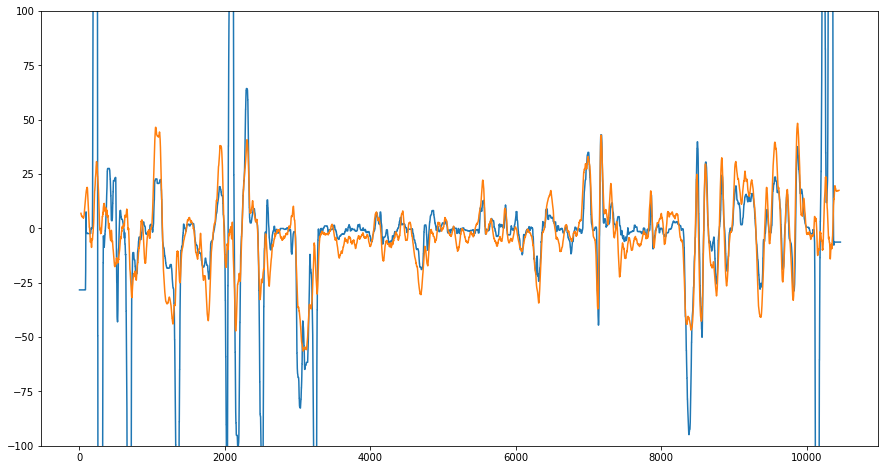

In [40]:
idxs = np.linspace(0, len(ground_truth), len(ground_truth))

plt.figure(figsize=(15,8))
plt.plot(idxs, ground_truth)
#plt.show()
#plt.plot(idxs, predictions_list)

plt.ylim(-100,100)
smooth_idxs = idxs[4:-4]
smooth = running_mean(predictions_list, 9)
#plt.plot(smooth_idxs, smooth)

super_smooth_idxs = idxs[20:-20]
super_smooth = running_mean(predictions_list, 41)
plt.plot(super_smooth_idxs, super_smooth)

get_smoothness_score(super_smooth)




plt.show()

# Test Shift-Verhalten:

In [19]:
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12, 12]
mpl.rcParams['figure.dpi'] = 72

def show_crop(index, shift):
    frame = val_set.get_cropped_frame(index, shift)[0]
    frame_arr = img_to_array(frame)/255
    plt.imshow(frame_arr)
    plt.show()
    
crop_slider = widgets.IntSlider(min=0, max=val_set.get_batch_size()*len(val_set)-1, continuous_update=False)
shift_slider = widgets.IntSlider(min=-100, max=100, continuous_update=False)

interact(show_crop, index=crop_slider, shift = shift_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=10463), IntSlider(v…

In [20]:
gui = AutopilotGUI()

predictions_lists = []
render_list = []

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(model_name + '_shift_behaviour.avi',fourcc, 15.0, (848,210))

frames = range(0, val_set.get_batch_size()*len(val_set)-1, 50)

shifts = range(-100,100,4)


for frame_idx in frames:
    predictions_lists.append([])
    for shift in shifts:
        cropped_sample = val_set.get_cropped_frame(frame_idx, shift)
        cropped_frame = cropped_sample[0]
        actual_swa = cropped_sample[1]['steering_wheel_angle']*90
        test_data = np.expand_dims(cropped_frame, axis=0)
        predictions = loaded_model.predict(test_data)
        predicted_swa = predictions[0][0]*90
        predictions_lists[-1].append({'shift':shift, 'actual':actual_swa, 'predicted':predicted_swa})



        gui.set_frame(cropped_frame)
        gui.set_show_overlay(True)
        gui.set_engaged(False)
        gui.set_recording(False)

        gui.set_timestring('')

        velocity = cropped_sample[1]['speed']
        gui.set_velocity(velocity)

        gui.set_actual_swa(actual_swa)
        gui.set_predicted_swa(predicted_swa)

        print("Ground-truth: " +str(actual_swa))
        print("Prediction: " + str(predicted_swa))

        gui.render()
        frame = gui.get_rendered_gui()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        out.write(rgb_frame.astype(np.uint8))
    
out.release()

Ground-truth: -28.3
Prediction: 13.22581171989441
Ground-truth: -28.3
Prediction: 19.673297703266144
Ground-truth: -28.3
Prediction: 14.281792044639587
Ground-truth: -28.3
Prediction: 17.974170595407486
Ground-truth: -28.3
Prediction: 8.553784489631653
Ground-truth: -28.3
Prediction: 17.301821261644363
Ground-truth: -28.3
Prediction: 6.322468891739845
Ground-truth: -28.3
Prediction: 0.18277003895491362
Ground-truth: -28.3
Prediction: 3.3773497492074966
Ground-truth: -28.3
Prediction: 4.83643289655447
Ground-truth: -28.3
Prediction: 8.008272796869278
Ground-truth: -28.3
Prediction: 17.923893928527832
Ground-truth: -28.3
Prediction: -1.6133416816592216
Ground-truth: -28.3
Prediction: 5.186147689819336
Ground-truth: -28.3
Prediction: 22.720429301261902
Ground-truth: -28.3
Prediction: 17.73665025830269
Ground-truth: -28.3
Prediction: 14.034689515829086
Ground-truth: -28.3
Prediction: 15.651559978723526
Ground-truth: -28.3
Prediction: 10.77642448246479
Ground-truth: -28.3
Prediction: 17.201

Ground-truth: -2.38
Prediction: 15.526526123285294
Ground-truth: -2.38
Prediction: 14.805396795272827
Ground-truth: -2.38
Prediction: 4.777228496968746
Ground-truth: -2.38
Prediction: 1.2105416972190142
Ground-truth: -2.38
Prediction: -10.621635541319847
Ground-truth: -2.38
Prediction: -11.210979893803596
Ground-truth: -2.38
Prediction: -15.549365133047104
Ground-truth: -2.38
Prediction: -19.917468577623367
Ground-truth: -2.38
Prediction: -0.6510304240509868
Ground-truth: -2.38
Prediction: -8.37859533727169
Ground-truth: -2.38
Prediction: -16.25924527645111
Ground-truth: -2.38
Prediction: -21.60731792449951
Ground-truth: -2.38
Prediction: -17.68440753221512
Ground-truth: -2.38
Prediction: -18.86329472064972
Ground-truth: -2.38
Prediction: -6.580452471971512
Ground-truth: -2.38
Prediction: 0.10348645504564047
Ground-truth: -2.38
Prediction: -11.40807330608368
Ground-truth: -2.38
Prediction: -10.305730327963829
Ground-truth: -2.38
Prediction: 3.3117620274424553
Ground-truth: -2.38
Predic

Ground-truth: -386.2300000000001
Prediction: 16.099656522274017
Ground-truth: -386.2300000000001
Prediction: 21.614272892475128
Ground-truth: -386.2300000000001
Prediction: 22.136870473623276
Ground-truth: -386.2300000000001
Prediction: 18.52124735713005
Ground-truth: -386.2300000000001
Prediction: 21.476619243621826
Ground-truth: -386.2300000000001
Prediction: 16.154719591140747
Ground-truth: -386.2300000000001
Prediction: 10.993153676390648
Ground-truth: -386.2300000000001
Prediction: 8.956231847405434
Ground-truth: -386.2300000000001
Prediction: 10.572956129908562
Ground-truth: -386.2300000000001
Prediction: 8.888932541012764
Ground-truth: -386.2300000000001
Prediction: 7.263375073671341
Ground-truth: -386.2300000000001
Prediction: 7.246495932340622
Ground-truth: -386.2300000000001
Prediction: 17.022302895784378
Ground-truth: -386.2300000000001
Prediction: 26.215194761753082
Ground-truth: -386.2300000000001
Prediction: 25.496282279491425
Ground-truth: -386.2300000000001
Prediction: 

Ground-truth: 3.94
Prediction: -17.387269735336304
Ground-truth: 3.94
Prediction: -20.01019522547722
Ground-truth: 3.94
Prediction: -15.099977105855942
Ground-truth: 3.94
Prediction: -16.55423864722252
Ground-truth: 3.94
Prediction: -10.539739653468132
Ground-truth: 3.94
Prediction: -6.231031715869904
Ground-truth: 3.94
Prediction: -1.4403056725859642
Ground-truth: 3.94
Prediction: -3.1353239715099335
Ground-truth: 3.94
Prediction: -0.1182601461187005
Ground-truth: 3.94
Prediction: 3.497660905122757
Ground-truth: 3.94
Prediction: 4.1052476316690445
Ground-truth: 3.94
Prediction: -0.05944919306784868
Ground-truth: 3.94
Prediction: -9.143349453806877
Ground-truth: 3.94
Prediction: -13.078156113624573
Ground-truth: 3.94
Prediction: -16.305603235960007
Ground-truth: 3.94
Prediction: -12.778877913951874
Ground-truth: 3.94
Prediction: -13.092901557683945
Ground-truth: 3.94
Prediction: -15.049055367708206
Ground-truth: 3.94
Prediction: -9.751070961356163
Ground-truth: 18.41
Prediction: 8.7181

Ground-truth: 1.8199999999999998
Prediction: -2.3082738742232323
Ground-truth: 1.8199999999999998
Prediction: -3.879213184118271
Ground-truth: 1.8199999999999998
Prediction: -0.6549627101048827
Ground-truth: 1.8199999999999998
Prediction: 2.622128203511238
Ground-truth: 1.8199999999999998
Prediction: 3.6725328862667084
Ground-truth: 1.8199999999999998
Prediction: 3.2422971725463867
Ground-truth: 1.8199999999999998
Prediction: 7.719360664486885
Ground-truth: 1.8199999999999998
Prediction: 6.8192072957754135
Ground-truth: 1.8199999999999998
Prediction: 6.611888632178307
Ground-truth: 1.8199999999999998
Prediction: 10.4576425999403
Ground-truth: 1.8199999999999998
Prediction: 13.077690750360489
Ground-truth: 1.8199999999999998
Prediction: 13.733320534229279
Ground-truth: 1.8199999999999998
Prediction: 10.657067522406578
Ground-truth: 1.8199999999999998
Prediction: 10.816653594374657
Ground-truth: -72.5
Prediction: 15.703466087579727
Ground-truth: -72.5
Prediction: 18.738680630922318
Groun

Ground-truth: -13.9
Prediction: -3.3263394981622696
Ground-truth: -13.9
Prediction: -5.484083108603954
Ground-truth: -13.9
Prediction: -10.811399146914482
Ground-truth: -13.9
Prediction: -15.265650451183319
Ground-truth: -13.9
Prediction: -16.106594055891037
Ground-truth: -13.9
Prediction: -14.92056280374527
Ground-truth: -13.9
Prediction: -12.09211841225624
Ground-truth: -13.9
Prediction: -11.04077897965908
Ground-truth: -10.89
Prediction: -12.305315136909485
Ground-truth: -10.89
Prediction: -9.263485595583916
Ground-truth: -10.89
Prediction: -11.851085722446442
Ground-truth: -10.89
Prediction: -15.194415003061295
Ground-truth: -10.89
Prediction: -16.2993523478508
Ground-truth: -10.89
Prediction: -11.98545902967453
Ground-truth: -10.89
Prediction: -11.745306104421616
Ground-truth: -10.89
Prediction: -13.944327235221863
Ground-truth: -10.89
Prediction: -16.439650654792786
Ground-truth: -10.89
Prediction: -19.517095237970352
Ground-truth: -10.89
Prediction: -20.491012036800385
Ground-tr

Ground-truth: -1.8199999999999998
Prediction: -13.789693862199783
Ground-truth: -1.8199999999999998
Prediction: -11.745016425848007
Ground-truth: -1.8199999999999998
Prediction: -10.342901051044464
Ground-truth: -1.8199999999999998
Prediction: -8.262088894844055
Ground-truth: -1.8199999999999998
Prediction: -8.184200897812843
Ground-truth: -1.8199999999999998
Prediction: -9.352023303508759
Ground-truth: -1.8199999999999998
Prediction: -11.868389993906021
Ground-truth: -1.8199999999999998
Prediction: -11.239000260829926
Ground-truth: -1.8199999999999998
Prediction: -12.215149998664856
Ground-truth: -1.8199999999999998
Prediction: -14.101842641830444
Ground-truth: -1.8199999999999998
Prediction: -16.625490188598633
Ground-truth: -1.8199999999999998
Prediction: -16.479181051254272
Ground-truth: -1.8199999999999998
Prediction: -17.08982214331627
Ground-truth: -1.8199999999999998
Prediction: -19.025330990552902
Ground-truth: -1.8199999999999998
Prediction: -20.434560924768448
Ground-truth: 

Ground-truth: 22.729999999999997
Prediction: 46.30779147148132
Ground-truth: 22.729999999999997
Prediction: 46.485509276390076
Ground-truth: 22.729999999999997
Prediction: 46.87010586261749
Ground-truth: 22.729999999999997
Prediction: 47.13542461395264
Ground-truth: 22.729999999999997
Prediction: 47.00094938278198
Ground-truth: 22.729999999999997
Prediction: 45.54540574550629
Ground-truth: 22.729999999999997
Prediction: 45.05945920944214
Ground-truth: 22.729999999999997
Prediction: 45.26294767856598
Ground-truth: 22.729999999999997
Prediction: 45.65517246723175
Ground-truth: 22.729999999999997
Prediction: 45.15825569629669
Ground-truth: 22.729999999999997
Prediction: 45.52782118320465
Ground-truth: 22.729999999999997
Prediction: 46.221848130226135
Ground-truth: 22.729999999999997
Prediction: 45.94152510166168
Ground-truth: 22.729999999999997
Prediction: 45.67183971405029
Ground-truth: 22.729999999999997
Prediction: 46.154943108558655
Ground-truth: 22.729999999999997
Prediction: 46.8812

Ground-truth: -18.22
Prediction: -33.48911225795746
Ground-truth: -18.22
Prediction: -34.326817095279694
Ground-truth: -18.22
Prediction: -34.21463370323181
Ground-truth: -18.22
Prediction: -32.54780977964401
Ground-truth: -18.22
Prediction: -29.308076798915863
Ground-truth: -18.22
Prediction: -27.486403584480286
Ground-truth: -18.22
Prediction: -25.917517840862274
Ground-truth: -18.22
Prediction: -24.401892721652985
Ground-truth: -16.65
Prediction: -36.47150069475174
Ground-truth: -16.65
Prediction: -36.881320774555206
Ground-truth: -16.65
Prediction: -32.580567598342896
Ground-truth: -16.65
Prediction: -29.942950308322906
Ground-truth: -16.65
Prediction: -30.732632875442505
Ground-truth: -16.65
Prediction: -31.15511029958725
Ground-truth: -16.65
Prediction: -32.34262615442276
Ground-truth: -16.65
Prediction: -35.07472425699234
Ground-truth: -16.65
Prediction: -33.79350811243057
Ground-truth: -16.65
Prediction: -32.290159463882446
Ground-truth: -16.65
Prediction: -30.500412583351135
G

Ground-truth: -10.21
Prediction: -13.951900452375412
Ground-truth: -10.21
Prediction: -15.259576588869095
Ground-truth: -10.21
Prediction: -15.824266076087952
Ground-truth: -10.21
Prediction: -14.291358143091202
Ground-truth: -10.21
Prediction: -12.640669047832489
Ground-truth: -10.21
Prediction: -12.720932811498642
Ground-truth: -10.21
Prediction: -12.091217190027237
Ground-truth: -10.21
Prediction: -15.522726774215698
Ground-truth: -10.21
Prediction: -18.628861606121063
Ground-truth: -10.21
Prediction: -20.97315788269043
Ground-truth: -10.21
Prediction: -22.08816424012184
Ground-truth: -10.21
Prediction: -22.07094579935074
Ground-truth: -10.21
Prediction: -23.701310455799103
Ground-truth: -10.21
Prediction: -25.2414670586586
Ground-truth: -10.21
Prediction: -20.079563856124878
Ground-truth: -10.21
Prediction: -16.76135614514351
Ground-truth: -10.21
Prediction: -14.195619374513626
Ground-truth: -10.21
Prediction: -16.24588519334793
Ground-truth: -10.21
Prediction: -17.547113299369812


Ground-truth: 2.38
Prediction: -14.074183702468872
Ground-truth: 2.38
Prediction: -15.712767988443375
Ground-truth: 2.38
Prediction: -17.118901312351227
Ground-truth: 2.38
Prediction: -17.107479125261307
Ground-truth: 2.38
Prediction: -16.519058793783188
Ground-truth: 2.38
Prediction: -12.231235206127167
Ground-truth: 2.38
Prediction: -9.360390454530716
Ground-truth: 2.38
Prediction: -7.532260492444038
Ground-truth: 2.38
Prediction: -9.043153524398804
Ground-truth: 2.38
Prediction: -8.006962537765503
Ground-truth: 2.38
Prediction: -8.131225928664207
Ground-truth: 2.38
Prediction: -6.185659468173981
Ground-truth: 2.38
Prediction: -7.540040239691734
Ground-truth: 2.38
Prediction: -4.82421912252903
Ground-truth: 2.38
Prediction: -1.008616117760539
Ground-truth: 2.38
Prediction: 0.34629158210009336
Ground-truth: 2.38
Prediction: 1.085169380530715
Ground-truth: 2.38
Prediction: 0.31557144597172737
Ground-truth: 2.38
Prediction: -0.19424714846536517
Ground-truth: 2.38
Prediction: 0.009222974

Ground-truth: -17.84
Prediction: -37.52412289381027
Ground-truth: -17.84
Prediction: -37.285813987255096
Ground-truth: -17.84
Prediction: -37.34810024499893
Ground-truth: -17.84
Prediction: -36.892623603343964
Ground-truth: -17.84
Prediction: -34.99150335788727
Ground-truth: -17.84
Prediction: -36.05492949485779
Ground-truth: -17.84
Prediction: -38.747296035289764
Ground-truth: -17.84
Prediction: -39.68922346830368
Ground-truth: -17.84
Prediction: -39.07670080661774
Ground-truth: -17.84
Prediction: -40.55770397186279
Ground-truth: -17.84
Prediction: -39.306238889694214
Ground-truth: -17.84
Prediction: -37.78315991163254
Ground-truth: -17.84
Prediction: -36.913823783397675
Ground-truth: -17.84
Prediction: -36.967647671699524
Ground-truth: -17.84
Prediction: -36.9070565700531
Ground-truth: -17.84
Prediction: -35.38533478975296
Ground-truth: -17.84
Prediction: -35.63896715641022
Ground-truth: -17.84
Prediction: -36.76326334476471
Ground-truth: -17.84
Prediction: -37.749015390872955
Ground

Ground-truth: -0.94
Prediction: -1.4777871966362
Ground-truth: -0.94
Prediction: -2.340567670762539
Ground-truth: -0.94
Prediction: -0.7600278127938509
Ground-truth: -0.94
Prediction: -1.3323586620390415
Ground-truth: -0.94
Prediction: -3.9112719520926476
Ground-truth: -0.94
Prediction: -6.585020944476128
Ground-truth: -0.94
Prediction: -7.499294131994247
Ground-truth: -0.94
Prediction: -5.723785758018494
Ground-truth: -0.94
Prediction: -3.5842690989375114
Ground-truth: -0.94
Prediction: -4.218203499913216
Ground-truth: -0.94
Prediction: -2.617037370800972
Ground-truth: -0.94
Prediction: 0.16828730469569564
Ground-truth: -0.94
Prediction: 1.209475602954626
Ground-truth: -0.94
Prediction: 0.9799115359783173
Ground-truth: -0.94
Prediction: 2.992371954023838
Ground-truth: -0.94
Prediction: 5.173483304679394
Ground-truth: -0.94
Prediction: 5.565683953464031
Ground-truth: -0.94
Prediction: 4.437184743583202
Ground-truth: -0.94
Prediction: 5.9667858481407166
Ground-truth: -0.94
Prediction: 7

Ground-truth: -12.08
Prediction: -10.451159700751305
Ground-truth: -12.08
Prediction: -4.389837048947811
Ground-truth: -12.08
Prediction: -3.754810318350792
Ground-truth: -12.08
Prediction: -11.556917130947113
Ground-truth: -12.08
Prediction: -18.054592609405518
Ground-truth: -12.08
Prediction: -17.808507978916168
Ground-truth: -12.08
Prediction: -14.422644227743149
Ground-truth: -12.08
Prediction: -12.368652820587158
Ground-truth: -12.08
Prediction: -20.297186225652695
Ground-truth: -12.08
Prediction: -21.78088366985321
Ground-truth: -12.08
Prediction: -14.96887743473053
Ground-truth: 65.99
Prediction: -10.422455370426178
Ground-truth: 65.99
Prediction: -3.741539753973484
Ground-truth: 65.99
Prediction: -3.7683162465691566
Ground-truth: 65.99
Prediction: -12.455219775438309
Ground-truth: 65.99
Prediction: -10.901829153299332
Ground-truth: 65.99
Prediction: -15.48530861735344
Ground-truth: 65.99
Prediction: -12.543579787015915
Ground-truth: 65.99
Prediction: -15.584255307912827
Ground-

Ground-truth: -86.96
Prediction: -53.901538252830505
Ground-truth: -62.48
Prediction: -32.708554565906525
Ground-truth: -62.48
Prediction: -34.65441673994064
Ground-truth: -62.48
Prediction: -39.928578436374664
Ground-truth: -62.48
Prediction: -41.780624985694885
Ground-truth: -62.48
Prediction: -41.46500676870346
Ground-truth: -62.48
Prediction: -42.515442967414856
Ground-truth: -62.48
Prediction: -40.872986912727356
Ground-truth: -62.48
Prediction: -40.90852349996567
Ground-truth: -62.48
Prediction: -40.09567201137543
Ground-truth: -62.48
Prediction: -39.957420229911804
Ground-truth: -62.48
Prediction: -39.86374944448471
Ground-truth: -62.48
Prediction: -38.167110085487366
Ground-truth: -62.48
Prediction: -36.469502449035645
Ground-truth: -62.48
Prediction: -32.834277749061584
Ground-truth: -62.48
Prediction: -33.40596914291382
Ground-truth: -62.48
Prediction: -33.51704478263855
Ground-truth: -62.48
Prediction: -33.21113079786301
Ground-truth: -62.48
Prediction: -33.74166637659073
Gr

Ground-truth: 2.5
Prediction: -8.192855045199394
Ground-truth: 2.5
Prediction: -8.728514984250069
Ground-truth: 2.5
Prediction: -10.75903169810772
Ground-truth: 2.5
Prediction: -14.23158511519432
Ground-truth: 2.5
Prediction: -13.707871735095978
Ground-truth: 2.5
Prediction: -10.350729748606682
Ground-truth: 2.5
Prediction: -8.569596111774445
Ground-truth: 2.5
Prediction: -8.342053592205048
Ground-truth: 2.5
Prediction: -5.473814271390438
Ground-truth: 2.5
Prediction: -4.946605637669563
Ground-truth: 2.5
Prediction: -0.8546872437000275
Ground-truth: 2.5
Prediction: -3.835536427795887
Ground-truth: 2.5
Prediction: -6.873279958963394
Ground-truth: 2.5
Prediction: -2.644735872745514
Ground-truth: 2.5
Prediction: 0.31168065033853054
Ground-truth: 2.5
Prediction: 7.289660722017288
Ground-truth: 2.5
Prediction: 10.635023787617683
Ground-truth: 2.5
Prediction: 11.786982268095016
Ground-truth: 2.5
Prediction: 9.271727353334427
Ground-truth: 2.5
Prediction: 6.605024188756943
Ground-truth: 2.5
P

Ground-truth: -105.18
Prediction: -23.42737376689911
Ground-truth: -105.18
Prediction: -24.09551203250885
Ground-truth: -105.18
Prediction: -27.340137362480164
Ground-truth: -105.18
Prediction: -29.157087206840515
Ground-truth: -105.18
Prediction: -28.688577711582184
Ground-truth: -105.18
Prediction: -32.40397900342941
Ground-truth: -105.18
Prediction: -33.23944419622421
Ground-truth: -105.18
Prediction: -31.964906752109528
Ground-truth: -105.18
Prediction: -30.94751536846161
Ground-truth: -105.18
Prediction: -31.35240286588669
Ground-truth: -105.18
Prediction: -30.584518611431122
Ground-truth: -105.18
Prediction: -28.06322604417801
Ground-truth: -105.18
Prediction: -26.944782435894012
Ground-truth: -105.18
Prediction: -28.112498223781586
Ground-truth: -105.18
Prediction: -29.926913380622864
Ground-truth: -105.18
Prediction: -30.457853972911835
Ground-truth: -105.18
Prediction: -31.722258031368256
Ground-truth: -105.18
Prediction: -31.168907582759857
Ground-truth: -105.18
Prediction: -

Ground-truth: -3.51
Prediction: 0.3658419521525502
Ground-truth: -3.51
Prediction: 0.36517240572720766
Ground-truth: -3.51
Prediction: 0.13633813010528684
Ground-truth: -3.51
Prediction: 0.3870324091985822
Ground-truth: -3.51
Prediction: 2.4817192554473877
Ground-truth: -3.51
Prediction: 3.7297209352254868
Ground-truth: -3.51
Prediction: 1.229360494762659
Ground-truth: -3.51
Prediction: -0.9263551142066717
Ground-truth: -3.51
Prediction: -1.6476105898618698
Ground-truth: -3.51
Prediction: 0.8515441138297319
Ground-truth: -1.75
Prediction: -5.278326161205769
Ground-truth: -1.75
Prediction: -6.521638333797455
Ground-truth: -1.75
Prediction: -9.02431033551693
Ground-truth: -1.75
Prediction: -7.519400641322136
Ground-truth: -1.75
Prediction: -13.40726986527443
Ground-truth: -1.75
Prediction: -15.313484966754913
Ground-truth: -1.75
Prediction: -14.907252341508865
Ground-truth: -1.75
Prediction: -11.356426030397415
Ground-truth: -1.75
Prediction: -9.013800770044327
Ground-truth: -1.75
Predic

Ground-truth: 0.13
Prediction: -5.355513095855713
Ground-truth: 0.13
Prediction: -7.1085284650325775
Ground-truth: 0.13
Prediction: -8.66028293967247
Ground-truth: 0.13
Prediction: -10.102870836853981
Ground-truth: 0.13
Prediction: -9.322761073708534
Ground-truth: 0.13
Prediction: -8.13727967441082
Ground-truth: 0.13
Prediction: -10.939241275191307
Ground-truth: 0.13
Prediction: -13.419138640165329
Ground-truth: 0.13
Prediction: -12.865882068872452
Ground-truth: 0.13
Prediction: -12.41063877940178
Ground-truth: 0.13
Prediction: -15.539698451757431
Ground-truth: 0.13
Prediction: -16.821127831935883
Ground-truth: 0.13
Prediction: -14.680592268705368
Ground-truth: 0.13
Prediction: -14.407016336917877
Ground-truth: 0.13
Prediction: -13.858395963907242
Ground-truth: 0.13
Prediction: -14.718133807182312
Ground-truth: 0.13
Prediction: -11.415462791919708
Ground-truth: 0.13
Prediction: -9.526077210903168
Ground-truth: 0.13
Prediction: -5.207810215651989
Ground-truth: 0.13
Prediction: -4.484151

Ground-truth: -66.99
Prediction: -38.48343640565872
Ground-truth: -66.99
Prediction: -37.35218793153763
Ground-truth: -66.99
Prediction: -37.124685645103455
Ground-truth: -66.99
Prediction: -40.36750316619873
Ground-truth: -66.99
Prediction: -41.94674491882324
Ground-truth: -66.99
Prediction: -42.574397921562195
Ground-truth: -66.99
Prediction: -43.10427367687225
Ground-truth: -66.99
Prediction: -43.63950580358505
Ground-truth: -66.99
Prediction: -42.659053802490234
Ground-truth: -66.99
Prediction: -43.468791246414185
Ground-truth: -66.99
Prediction: -43.0178502202034
Ground-truth: -66.99
Prediction: -43.327066004276276
Ground-truth: -66.99
Prediction: -44.256939589977264
Ground-truth: -66.99
Prediction: -43.412719666957855
Ground-truth: -66.99
Prediction: -43.11076730489731
Ground-truth: -66.99
Prediction: -43.04863393306732
Ground-truth: -66.99
Prediction: -39.79870855808258
Ground-truth: -66.99
Prediction: -38.77257853746414
Ground-truth: -66.99
Prediction: -38.85885715484619
Ground

Ground-truth: -44.58
Prediction: -40.982630252838135
Ground-truth: -44.58
Prediction: -40.631708800792694
Ground-truth: -44.58
Prediction: -40.84160774946213
Ground-truth: -44.58
Prediction: -40.24760842323303
Ground-truth: -44.58
Prediction: -41.35283946990967
Ground-truth: -44.58
Prediction: -41.06040358543396
Ground-truth: -44.58
Prediction: -40.22587716579437
Ground-truth: -44.58
Prediction: -40.801822543144226
Ground-truth: -44.58
Prediction: -42.82649874687195
Ground-truth: -44.58
Prediction: -43.95736366510391
Ground-truth: -44.58
Prediction: -44.17000651359558
Ground-truth: -44.58
Prediction: -42.18326210975647
Ground-truth: -44.58
Prediction: -41.18628770112991
Ground-truth: -44.58
Prediction: -43.20108264684677
Ground-truth: -44.58
Prediction: -41.36431664228439
Ground-truth: -44.58
Prediction: -42.03424662351608
Ground-truth: -44.58
Prediction: -41.489109098911285
Ground-truth: -44.58
Prediction: -39.471033811569214
Ground-truth: -44.58
Prediction: -38.47269684076309
Ground-

Ground-truth: -3.3800000000000003
Prediction: -4.243642576038837
Ground-truth: -3.3800000000000003
Prediction: -3.1146079301834106
Ground-truth: -3.3800000000000003
Prediction: -2.336914502084255
Ground-truth: -3.3800000000000003
Prediction: -2.5951508805155754
Ground-truth: -3.3800000000000003
Prediction: -1.7998028174042702
Ground-truth: -3.3800000000000003
Prediction: -1.077920375391841
Ground-truth: -3.3800000000000003
Prediction: 0.8381419535726309
Ground-truth: -3.3800000000000003
Prediction: 1.5034086629748344
Ground-truth: -3.3800000000000003
Prediction: 0.18551555229350924
Ground-truth: -3.3800000000000003
Prediction: -1.8595852330327034
Ground-truth: -3.3800000000000003
Prediction: -2.4094364047050476
Ground-truth: -3.3800000000000003
Prediction: -1.3471723347902298
Ground-truth: -3.3800000000000003
Prediction: -1.0121703799813986
Ground-truth: -3.3800000000000003
Prediction: 0.19836729392409325
Ground-truth: -3.3800000000000003
Prediction: 2.4466493725776672
Ground-truth: -3

Ground-truth: -0.63
Prediction: 3.5279594734311104
Ground-truth: -0.63
Prediction: 5.16889002174139
Ground-truth: -0.63
Prediction: 4.777712635695934
Ground-truth: -0.63
Prediction: 4.305263981223106
Ground-truth: -0.63
Prediction: 4.4997308403253555
Ground-truth: -0.63
Prediction: 7.7116164565086365
Ground-truth: -0.63
Prediction: 8.443035408854485
Ground-truth: -0.63
Prediction: 9.995208978652954
Ground-truth: -0.63
Prediction: 9.543386846780777
Ground-truth: -0.63
Prediction: 11.84445932507515
Ground-truth: -0.63
Prediction: 13.504427522420883
Ground-truth: -0.63
Prediction: 14.230193048715591
Ground-truth: -0.63
Prediction: 12.344765067100525
Ground-truth: -0.63
Prediction: 14.538948833942413
Ground-truth: -0.63
Prediction: 15.212108194828033
Ground-truth: -0.63
Prediction: 14.447870403528214
Ground-truth: -0.63
Prediction: 13.372812867164612
Ground-truth: -0.63
Prediction: 12.072807848453522
Ground-truth: -0.63
Prediction: 17.83159241080284
Ground-truth: 1.38
Prediction: -18.68478

Ground-truth: -2.88
Prediction: -3.327551856637001
Ground-truth: -2.88
Prediction: -3.6205382645130157
Ground-truth: -2.88
Prediction: -5.656329542398453
Ground-truth: -2.88
Prediction: -6.438525393605232
Ground-truth: -1.5
Prediction: -18.709315806627274
Ground-truth: -1.5
Prediction: -23.07594805955887
Ground-truth: -1.5
Prediction: -25.07308065891266
Ground-truth: -1.5
Prediction: -26.46148592233658
Ground-truth: -1.5
Prediction: -23.9065021276474
Ground-truth: -1.5
Prediction: -22.823772132396698
Ground-truth: -1.5
Prediction: -21.97250336408615
Ground-truth: -1.5
Prediction: -24.839953780174255
Ground-truth: -1.5
Prediction: -23.614669740200043
Ground-truth: -1.5
Prediction: -20.24770885705948
Ground-truth: -1.5
Prediction: -16.15743264555931
Ground-truth: -1.5
Prediction: -15.663181990385056
Ground-truth: -1.5
Prediction: -12.729491740465164
Ground-truth: -1.5
Prediction: -10.828375518321991
Ground-truth: -1.5
Prediction: -10.13621337711811
Ground-truth: -1.5
Prediction: -8.43058

Ground-truth: -0.19000000000000003
Prediction: 1.742420308291912
Ground-truth: -0.19000000000000003
Prediction: 1.1907350923866034
Ground-truth: -0.19000000000000003
Prediction: 2.614123821258545
Ground-truth: -0.19000000000000003
Prediction: 2.7538766339421272
Ground-truth: -1.31
Prediction: -22.89266735315323
Ground-truth: -1.31
Prediction: -19.283372908830643
Ground-truth: -1.31
Prediction: -15.509730130434036
Ground-truth: -1.31
Prediction: -16.17309272289276
Ground-truth: -1.31
Prediction: -22.353681474924088
Ground-truth: -1.31
Prediction: -27.83533751964569
Ground-truth: -1.31
Prediction: -28.1299889087677
Ground-truth: -1.31
Prediction: -27.236416339874268
Ground-truth: -1.31
Prediction: -25.2097687125206
Ground-truth: -1.31
Prediction: -24.530276656150818
Ground-truth: -1.31
Prediction: -23.15846621990204
Ground-truth: -1.31
Prediction: -19.88972783088684
Ground-truth: -1.31
Prediction: -17.280124872922897
Ground-truth: -1.31
Prediction: -13.904669433832169
Ground-truth: -1.31

Ground-truth: 0.19000000000000003
Prediction: 2.0024071633815765
Ground-truth: 0.19000000000000003
Prediction: -1.5462110191583633
Ground-truth: 0.19000000000000003
Prediction: 0.6102218292653561
Ground-truth: 0.19000000000000003
Prediction: 1.5428777039051056
Ground-truth: 0.19000000000000003
Prediction: 2.8088726475834846
Ground-truth: 0.19000000000000003
Prediction: 0.754660377278924
Ground-truth: 0.19000000000000003
Prediction: 4.249737225472927
Ground-truth: 0.19000000000000003
Prediction: 9.027451202273369
Ground-truth: 0.19000000000000003
Prediction: 9.26196813583374
Ground-truth: 0.19000000000000003
Prediction: 6.463811248540878
Ground-truth: 0.19000000000000003
Prediction: 3.456348180770874
Ground-truth: 0.19000000000000003
Prediction: 1.021474963054061
Ground-truth: 0.19000000000000003
Prediction: 1.3143421802669764
Ground-truth: 0.19000000000000003
Prediction: 1.4699430763721466
Ground-truth: 0.19000000000000003
Prediction: 0.9565821848809719
Ground-truth: 0.1900000000000000

Ground-truth: -1.19
Prediction: -0.8404400199651718
Ground-truth: -1.19
Prediction: -1.080018449574709
Ground-truth: -1.19
Prediction: -1.0706728789955378
Ground-truth: -1.19
Prediction: -0.2981732343323529
Ground-truth: -1.19
Prediction: -0.7330084126442671
Ground-truth: -1.19
Prediction: 1.383481314405799
Ground-truth: 4.88
Prediction: -10.780784413218498
Ground-truth: 4.88
Prediction: -10.642727091908455
Ground-truth: 4.88
Prediction: -10.668595656752586
Ground-truth: 4.88
Prediction: -6.843308284878731
Ground-truth: 4.88
Prediction: -3.6632826179265976
Ground-truth: 4.88
Prediction: -1.8151145428419113
Ground-truth: 4.88
Prediction: -0.651905913837254
Ground-truth: 4.88
Prediction: -2.3221543058753014
Ground-truth: 4.88
Prediction: -2.212378866970539
Ground-truth: 4.88
Prediction: -2.5459591671824455
Ground-truth: 4.88
Prediction: -3.2432158291339874
Ground-truth: 4.88
Prediction: -4.152156449854374
Ground-truth: 4.88
Prediction: -3.242254927754402
Ground-truth: 4.88
Prediction: -2

Ground-truth: -6.39
Prediction: -21.524177491664886
Ground-truth: -6.39
Prediction: -24.211678504943848
Ground-truth: -6.39
Prediction: -21.166213899850845
Ground-truth: -6.39
Prediction: -19.763677418231964
Ground-truth: -6.39
Prediction: -18.056448698043823
Ground-truth: -6.39
Prediction: -17.647638469934464
Ground-truth: -6.39
Prediction: -20.23386999964714
Ground-truth: -6.39
Prediction: -20.711332708597183
Ground-truth: -6.39
Prediction: -21.924282610416412
Ground-truth: -6.39
Prediction: -21.70321762561798
Ground-truth: -6.39
Prediction: -19.98650997877121
Ground-truth: -6.39
Prediction: -18.03157389163971
Ground-truth: -6.39
Prediction: -14.596551954746246
Ground-truth: -6.39
Prediction: -14.462346285581589
Ground-truth: -6.39
Prediction: -18.436709493398666
Ground-truth: -6.39
Prediction: -17.500361055135727
Ground-truth: -6.39
Prediction: -16.763444244861603
Ground-truth: -6.39
Prediction: -17.684489339590073
Ground-truth: -6.39
Prediction: -16.40529155731201
Ground-truth: -6.

Ground-truth: 3.0699999999999994
Prediction: -6.835785359144211
Ground-truth: 3.0699999999999994
Prediction: -6.201494559645653
Ground-truth: 3.0699999999999994
Prediction: -5.355420224368572
Ground-truth: 3.0699999999999994
Prediction: -5.134564787149429
Ground-truth: 3.0699999999999994
Prediction: -2.6162152737379074
Ground-truth: 3.0699999999999994
Prediction: -0.7437746319919825
Ground-truth: 3.0699999999999994
Prediction: -3.5955223068594933
Ground-truth: 3.0699999999999994
Prediction: -5.461069755256176
Ground-truth: 3.0699999999999994
Prediction: -3.3219272643327713
Ground-truth: 3.0699999999999994
Prediction: -0.20687174052000046
Ground-truth: 3.0699999999999994
Prediction: -0.45401441864669323
Ground-truth: 3.0699999999999994
Prediction: -4.223477728664875
Ground-truth: 3.0699999999999994
Prediction: -9.952308386564255
Ground-truth: 3.0699999999999994
Prediction: -10.721191763877869
Ground-truth: 3.0699999999999994
Prediction: -12.852252423763275
Ground-truth: 3.06999999999999

Ground-truth: -0.38000000000000006
Prediction: -3.4681079909205437
Ground-truth: -0.38000000000000006
Prediction: -1.2846057023853064
Ground-truth: -0.38000000000000006
Prediction: 1.1774303298443556
Ground-truth: -0.38000000000000006
Prediction: 1.6962045058608055
Ground-truth: -0.38000000000000006
Prediction: 1.7731456831097603
Ground-truth: -0.38000000000000006
Prediction: 0.27621204033493996
Ground-truth: -0.38000000000000006
Prediction: -1.4689664170145988
Ground-truth: -0.38000000000000006
Prediction: -2.9721765965223312
Ground-truth: -0.38000000000000006
Prediction: -2.1522873267531395
Ground-truth: -0.38000000000000006
Prediction: -1.3880870025604963
Ground-truth: -0.38000000000000006
Prediction: -2.646876610815525
Ground-truth: -0.38000000000000006
Prediction: -2.3659970238804817
Ground-truth: -0.38000000000000006
Prediction: -1.5458284690976143
Ground-truth: -0.38000000000000006
Prediction: -0.13155667344108224
Ground-truth: -0.38000000000000006
Prediction: -0.400340859778225

Ground-truth: -18.91
Prediction: -30.73628067970276
Ground-truth: -18.91
Prediction: -27.141774594783783
Ground-truth: -18.91
Prediction: -27.849225997924805
Ground-truth: -18.91
Prediction: -29.706299006938934
Ground-truth: -18.91
Prediction: -30.34360259771347
Ground-truth: -18.91
Prediction: -30.77874004840851
Ground-truth: -18.91
Prediction: -29.506034553050995
Ground-truth: -18.91
Prediction: -28.827186226844788
Ground-truth: -18.91
Prediction: -27.18381553888321
Ground-truth: -18.91
Prediction: -27.17395842075348
Ground-truth: -18.91
Prediction: -25.197095274925232
Ground-truth: -18.91
Prediction: -20.97357764840126
Ground-truth: -18.91
Prediction: -19.846167415380478
Ground-truth: -18.91
Prediction: -22.532269656658173
Ground-truth: -18.91
Prediction: -20.555229485034943
Ground-truth: -18.91
Prediction: -15.961693078279495
Ground-truth: -18.91
Prediction: -14.870916455984116
Ground-truth: -18.91
Prediction: -15.264923572540283
Ground-truth: -18.91
Prediction: -15.03517359495163


Ground-truth: 8.08
Prediction: -1.6614310070872307
Ground-truth: 8.08
Prediction: -2.130737788975239
Ground-truth: 8.08
Prediction: -4.340292289853096
Ground-truth: 8.08
Prediction: -4.281756766140461
Ground-truth: 8.08
Prediction: -2.55014106631279
Ground-truth: 8.08
Prediction: 0.2304558176547289
Ground-truth: 8.08
Prediction: 0.9944762662053108
Ground-truth: 8.08
Prediction: 3.352222815155983
Ground-truth: 8.08
Prediction: 3.0103799700737
Ground-truth: 8.08
Prediction: 1.2541910447180271
Ground-truth: 8.08
Prediction: -0.3581469878554344
Ground-truth: 8.08
Prediction: -1.6271265596151352
Ground-truth: 1.0
Prediction: -21.405186653137207
Ground-truth: 1.0
Prediction: -20.717842429876328
Ground-truth: 1.0
Prediction: -19.854592233896255
Ground-truth: 1.0
Prediction: -17.4164816737175
Ground-truth: 1.0
Prediction: -18.4688101708889
Ground-truth: 1.0
Prediction: -21.272753924131393
Ground-truth: 1.0
Prediction: -22.39319309592247
Ground-truth: 1.0
Prediction: -23.668093979358673
Ground-

Ground-truth: 2.32
Prediction: -3.3041569590568542
Ground-truth: 2.32
Prediction: -2.293146550655365
Ground-truth: 2.32
Prediction: -4.4614604115486145
Ground-truth: 2.32
Prediction: -2.2501520812511444
Ground-truth: 2.32
Prediction: -1.2920285481959581
Ground-truth: 2.32
Prediction: 1.0884503088891506
Ground-truth: 2.32
Prediction: -0.1516193663701415
Ground-truth: 2.32
Prediction: -1.0271917562931776
Ground-truth: 2.32
Prediction: -0.36232301965355873
Ground-truth: 2.32
Prediction: -2.281542979180813
Ground-truth: 2.32
Prediction: -4.337824322283268
Ground-truth: 2.32
Prediction: -1.5307098627090454
Ground-truth: 2.32
Prediction: -1.4138999953866005
Ground-truth: 2.32
Prediction: -1.7370310798287392
Ground-truth: 2.32
Prediction: -2.445574477314949
Ground-truth: 2.32
Prediction: -0.8007925283163786
Ground-truth: 2.32
Prediction: 1.430232971906662
Ground-truth: 2.32
Prediction: 3.0416330695152283
Ground-truth: 2.32
Prediction: 2.773016542196274
Ground-truth: 2.32
Prediction: 1.9776134

Ground-truth: -1.75
Prediction: -14.316254407167435
Ground-truth: -1.75
Prediction: -13.499327301979065
Ground-truth: -1.75
Prediction: -12.108461111783981
Ground-truth: -1.75
Prediction: -12.696527391672134
Ground-truth: -1.75
Prediction: -11.774735301733017
Ground-truth: -1.75
Prediction: -10.576600581407547
Ground-truth: -1.75
Prediction: -9.528016448020935
Ground-truth: -1.75
Prediction: -9.304030537605286
Ground-truth: -1.75
Prediction: -8.415977954864502
Ground-truth: -1.75
Prediction: -9.947262480854988
Ground-truth: -1.75
Prediction: -4.533135406672955
Ground-truth: -1.75
Prediction: 2.6744524016976357
Ground-truth: -1.75
Prediction: 4.31584294885397
Ground-truth: -1.75
Prediction: 2.5962183997035027
Ground-truth: -1.75
Prediction: 2.9995669797062874
Ground-truth: -1.75
Prediction: 0.44099925085902214
Ground-truth: -1.75
Prediction: -3.491274230182171
Ground-truth: -1.75
Prediction: -4.618801809847355
Ground-truth: -1.75
Prediction: -2.9244818910956383
Ground-truth: -1.75
Predi

Ground-truth: -1.19
Prediction: -4.327156841754913
Ground-truth: -1.19
Prediction: -1.695159450173378
Ground-truth: -1.19
Prediction: 0.5404888791963458
Ground-truth: -1.19
Prediction: 3.251441828906536
Ground-truth: -1.19
Prediction: 4.22913484275341
Ground-truth: -1.19
Prediction: 0.9778483305126429
Ground-truth: -1.19
Prediction: -3.500788025557995
Ground-truth: -1.19
Prediction: -3.3218561857938766
Ground-truth: -1.19
Prediction: 0.7273357082158327
Ground-truth: -1.19
Prediction: 4.006007574498653
Ground-truth: -1.19
Prediction: 7.565879300236702
Ground-truth: -1.19
Prediction: 10.185488238930702
Ground-truth: -1.19
Prediction: 11.455103158950806
Ground-truth: -1.19
Prediction: 10.43984279036522
Ground-truth: -1.19
Prediction: 13.572330325841904
Ground-truth: -1.19
Prediction: 13.045588731765747
Ground-truth: -1.0
Prediction: -2.7591485157608986
Ground-truth: -1.0
Prediction: -3.501066640019417
Ground-truth: -1.0
Prediction: -4.478224217891693
Ground-truth: -1.0
Prediction: -8.6566

Ground-truth: 12.709999999999999
Prediction: 14.856014102697372
Ground-truth: 12.709999999999999
Prediction: 15.545119196176529
Ground-truth: 12.709999999999999
Prediction: 13.992560058832169
Ground-truth: 12.709999999999999
Prediction: 20.096795707941055
Ground-truth: 12.709999999999999
Prediction: 23.249385058879852
Ground-truth: 12.709999999999999
Prediction: 21.800854057073593
Ground-truth: 12.709999999999999
Prediction: 23.648830354213715
Ground-truth: 12.709999999999999
Prediction: 24.640000462532043
Ground-truth: 12.709999999999999
Prediction: 23.765152394771576
Ground-truth: 12.709999999999999
Prediction: 24.580321311950684
Ground-truth: 12.709999999999999
Prediction: 29.748972952365875
Ground-truth: 12.709999999999999
Prediction: 31.06930911540985
Ground-truth: 12.709999999999999
Prediction: 33.89949291944504
Ground-truth: 12.709999999999999
Prediction: 31.726967990398407
Ground-truth: 12.709999999999999
Prediction: 30.457186102867126
Ground-truth: 12.709999999999999
Predictio

Ground-truth: 1.19
Prediction: -18.068761378526688
Ground-truth: 1.19
Prediction: -21.605715304613113
Ground-truth: 1.19
Prediction: -19.481750428676605
Ground-truth: 1.19
Prediction: -18.69474470615387
Ground-truth: 1.19
Prediction: -20.006327480077744
Ground-truth: 1.19
Prediction: -15.775543749332428
Ground-truth: 1.19
Prediction: -11.060426831245422
Ground-truth: 1.19
Prediction: -11.969816386699677
Ground-truth: 1.19
Prediction: -12.676204293966293
Ground-truth: 1.19
Prediction: -16.903529316186905
Ground-truth: 1.19
Prediction: -16.288746893405914
Ground-truth: 1.19
Prediction: -16.882606744766235
Ground-truth: 1.19
Prediction: -12.830325365066528
Ground-truth: 1.19
Prediction: -8.556061685085297
Ground-truth: 1.19
Prediction: -7.587117701768875
Ground-truth: 1.19
Prediction: -8.844622448086739
Ground-truth: 1.19
Prediction: -8.92136313021183
Ground-truth: 1.19
Prediction: -8.898900300264359
Ground-truth: 1.19
Prediction: -8.664370626211166
Ground-truth: 1.19
Prediction: -6.99592

Ground-truth: 8.58
Prediction: 10.346571654081345
Ground-truth: 8.58
Prediction: 6.866573095321655
Ground-truth: 8.58
Prediction: 5.0346119329333305
Ground-truth: 8.58
Prediction: 4.163661785423756
Ground-truth: 8.58
Prediction: 4.558560065925121
Ground-truth: 8.58
Prediction: 6.754327341914177
Ground-truth: 8.58
Prediction: 8.223366513848305
Ground-truth: 8.58
Prediction: 8.688032403588295
Ground-truth: 8.58
Prediction: 6.8503886461257935
Ground-truth: 8.58
Prediction: 8.33237148821354
Ground-truth: 8.58
Prediction: 10.80059789121151
Ground-truth: 8.58
Prediction: 9.536646455526352
Ground-truth: 8.58
Prediction: 9.424750730395317
Ground-truth: 8.58
Prediction: 5.665351152420044
Ground-truth: 8.58
Prediction: 2.3202187567949295
Ground-truth: 8.58
Prediction: 2.9099195078015327
Ground-truth: 8.58
Prediction: 2.6208608597517014
Ground-truth: 8.58
Prediction: 4.1292741894721985
Ground-truth: 8.58
Prediction: 8.088837638497353
Ground-truth: 8.58
Prediction: 12.462984770536423
Ground-truth:

Ground-truth: 5.51
Prediction: -6.234103515744209
Ground-truth: 5.51
Prediction: -4.134914539754391
Ground-truth: 5.51
Prediction: -3.572920672595501
Ground-truth: 5.51
Prediction: 0.0022902816999703646
Ground-truth: 5.51
Prediction: 2.759152539074421
Ground-truth: 5.51
Prediction: 2.086271122097969
Ground-truth: 5.51
Prediction: 1.2131674122065306
Ground-truth: 5.51
Prediction: 1.0204522032290697
Ground-truth: 5.51
Prediction: 2.1434353664517403
Ground-truth: 5.51
Prediction: 2.7096419781446457
Ground-truth: 5.51
Prediction: 0.7835497800260782
Ground-truth: 5.51
Prediction: 1.8972766399383545
Ground-truth: 5.51
Prediction: 2.5891199335455894
Ground-truth: 5.51
Prediction: 2.9937556385993958
Ground-truth: 5.51
Prediction: 4.220316410064697
Ground-truth: 5.51
Prediction: 6.103471219539642
Ground-truth: 5.51
Prediction: 8.634777814149857
Ground-truth: 5.51
Prediction: 10.56094653904438
Ground-truth: 5.51
Prediction: 12.072075605392456
Ground-truth: 5.51
Prediction: 13.47210019826889
Grou

Ground-truth: -0.69
Prediction: 4.76819884032011
Ground-truth: -0.69
Prediction: 9.072971642017365
Ground-truth: -0.69
Prediction: 10.646101981401443
Ground-truth: -0.69
Prediction: 11.396384239196777
Ground-truth: -0.69
Prediction: 13.483502268791199
Ground-truth: -0.69
Prediction: 15.144995301961899
Ground-truth: -0.69
Prediction: 14.893691092729568
Ground-truth: -0.69
Prediction: 16.366811245679855
Ground-truth: -0.69
Prediction: 15.648626983165741
Ground-truth: -0.69
Prediction: 13.242953717708588
Ground-truth: -0.69
Prediction: 13.092382550239563
Ground-truth: -0.69
Prediction: 19.470376521348953
Ground-truth: -0.69
Prediction: 18.121439963579178
Ground-truth: -0.69
Prediction: 17.316665947437286
Ground-truth: -0.69
Prediction: 20.211857110261917
Ground-truth: 0.13
Prediction: -15.221517384052277
Ground-truth: 0.13
Prediction: -14.747113734483719
Ground-truth: 0.13
Prediction: -15.560697466135025
Ground-truth: 0.13
Prediction: -14.61000993847847
Ground-truth: 0.13
Prediction: -12.

Ground-truth: -20.97
Prediction: -15.607369244098663
Ground-truth: -20.97
Prediction: -13.599578887224197
Ground-truth: -20.97
Prediction: -8.480977267026901
Ground-truth: -6.139999999999999
Prediction: -16.623516082763672
Ground-truth: -6.139999999999999
Prediction: -18.078875988721848
Ground-truth: -6.139999999999999
Prediction: -14.276478588581085
Ground-truth: -6.139999999999999
Prediction: -13.363265544176102
Ground-truth: -6.139999999999999
Prediction: -13.561754375696182
Ground-truth: -6.139999999999999
Prediction: -15.78957974910736
Ground-truth: -6.139999999999999
Prediction: -17.26401150226593
Ground-truth: -6.139999999999999
Prediction: -18.92286792397499
Ground-truth: -6.139999999999999
Prediction: -16.338457614183426
Ground-truth: -6.139999999999999
Prediction: -15.387858599424362
Ground-truth: -6.139999999999999
Prediction: -14.583564698696136
Ground-truth: -6.139999999999999
Prediction: -15.816865861415863
Ground-truth: -6.139999999999999
Prediction: -15.809420049190521


Ground-truth: 4.88
Prediction: -1.3278913591057062
Ground-truth: 4.88
Prediction: -2.6599667966365814
Ground-truth: 4.88
Prediction: -1.4930114150047302
Ground-truth: 4.88
Prediction: -1.8786611035466194
Ground-truth: 4.88
Prediction: -2.682216390967369
Ground-truth: 4.88
Prediction: -6.733090281486511
Ground-truth: 4.88
Prediction: -6.90642736852169
Ground-truth: 4.88
Prediction: -5.014104433357716
Ground-truth: 4.88
Prediction: -4.9789778888225555
Ground-truth: 4.88
Prediction: -5.25303091853857
Ground-truth: 4.88
Prediction: -2.051035277545452
Ground-truth: 4.88
Prediction: 0.4438255447894335
Ground-truth: 4.88
Prediction: 0.4082831321284175
Ground-truth: 4.88
Prediction: 1.2270110473036766
Ground-truth: 4.88
Prediction: 2.254173383116722
Ground-truth: 4.88
Prediction: 3.8669930398464203
Ground-truth: 4.88
Prediction: 1.6638674587011337
Ground-truth: 4.88
Prediction: 0.6780007481575012
Ground-truth: 4.88
Prediction: 2.4594465270638466
Ground-truth: 4.88
Prediction: 2.270711213350296

Ground-truth: -2.07
Prediction: -8.610366359353065
Ground-truth: -2.07
Prediction: -9.28342379629612
Ground-truth: -2.07
Prediction: -5.896953865885735
Ground-truth: -2.07
Prediction: -4.178938642144203
Ground-truth: -2.07
Prediction: -3.2342787086963654
Ground-truth: -2.07
Prediction: -3.454098142683506
Ground-truth: -2.07
Prediction: -2.616599164903164
Ground-truth: -2.07
Prediction: -3.8456429913640022
Ground-truth: -2.07
Prediction: -3.8640617206692696
Ground-truth: -2.07
Prediction: -6.570347249507904
Ground-truth: -2.07
Prediction: -8.047487363219261
Ground-truth: -2.07
Prediction: -8.967458233237267
Ground-truth: -2.07
Prediction: -9.034777656197548
Ground-truth: -2.07
Prediction: -8.542803525924683
Ground-truth: -2.07
Prediction: -5.367469042539597
Ground-truth: -2.07
Prediction: -3.8666755333542824
Ground-truth: -2.07
Prediction: -1.6716374829411507
Ground-truth: -2.07
Prediction: -1.575828641653061
Ground-truth: -2.07
Prediction: -1.900734007358551
Ground-truth: -2.07
Predict

Ground-truth: -1.44
Prediction: 5.89398667216301
Ground-truth: -1.44
Prediction: 4.813700504601002
Ground-truth: -1.44
Prediction: 7.263846471905708
Ground-truth: -1.44
Prediction: 11.276624947786331
Ground-truth: -1.44
Prediction: 12.842443585395813
Ground-truth: -1.44
Prediction: 14.195246547460556
Ground-truth: -1.44
Prediction: 19.431137144565582
Ground-truth: -1.44
Prediction: 22.92624056339264
Ground-truth: -1.44
Prediction: 23.17440927028656
Ground-truth: -1.44
Prediction: 21.164603233337402
Ground-truth: -1.44
Prediction: 23.92545998096466
Ground-truth: -1.44
Prediction: 25.221865475177765
Ground-truth: -1.44
Prediction: 26.321541666984558
Ground-truth: -1.44
Prediction: 27.461437582969666
Ground-truth: -1.44
Prediction: 28.72340887784958
Ground-truth: -1.44
Prediction: 29.20255869626999
Ground-truth: -0.88
Prediction: -17.73820459842682
Ground-truth: -0.88
Prediction: -15.316785424947739
Ground-truth: -0.88
Prediction: -13.109260350465775
Ground-truth: -0.88
Prediction: -13.86

Ground-truth: 34.94
Prediction: 32.59490668773651
Ground-truth: 34.94
Prediction: 30.594794154167175
Ground-truth: 34.94
Prediction: 32.01414942741394
Ground-truth: 34.94
Prediction: 32.7964773774147
Ground-truth: 34.94
Prediction: 31.815384328365326
Ground-truth: 34.94
Prediction: 29.601859152317047
Ground-truth: 34.94
Prediction: 27.611434757709503
Ground-truth: 34.94
Prediction: 29.094465672969818
Ground-truth: 34.94
Prediction: 27.060332000255585
Ground-truth: 34.94
Prediction: 26.52311772108078
Ground-truth: 34.94
Prediction: 26.783123016357422
Ground-truth: 34.94
Prediction: 29.31917577981949
Ground-truth: 34.94
Prediction: 28.87471228837967
Ground-truth: 34.94
Prediction: 31.181548833847046
Ground-truth: 34.94
Prediction: 32.28896588087082
Ground-truth: 34.94
Prediction: 33.547731935977936
Ground-truth: 34.94
Prediction: 32.93561428785324
Ground-truth: 34.94
Prediction: 32.70485311746597
Ground-truth: 34.94
Prediction: 30.354838371276855
Ground-truth: 34.94
Prediction: 27.580152

Ground-truth: -3.8799999999999994
Prediction: 23.421269059181213
Ground-truth: -3.8799999999999994
Prediction: 18.342978358268738
Ground-truth: -3.8799999999999994
Prediction: 17.399919033050537
Ground-truth: -3.8799999999999994
Prediction: 11.828895807266235
Ground-truth: -3.8799999999999994
Prediction: 9.285157844424248
Ground-truth: -3.8799999999999994
Prediction: 13.723668605089188
Ground-truth: -3.8799999999999994
Prediction: 14.739152938127518
Ground-truth: -3.8799999999999994
Prediction: 13.753190338611603
Ground-truth: -3.8799999999999994
Prediction: 16.903037130832672
Ground-truth: -3.8799999999999994
Prediction: 17.562435418367386
Ground-truth: -3.8799999999999994
Prediction: 22.02163875102997
Ground-truth: -3.8799999999999994
Prediction: 21.65400981903076
Ground-truth: -3.8799999999999994
Prediction: 22.61083960533142
Ground-truth: -3.8799999999999994
Prediction: 24.911528527736664
Ground-truth: -3.8799999999999994
Prediction: 25.82686185836792
Ground-truth: -3.8799999999999

Ground-truth: 9.14
Prediction: 20.88329181075096
Ground-truth: 9.14
Prediction: 17.892687767744064
Ground-truth: 9.14
Prediction: 18.905095607042313
Ground-truth: 9.14
Prediction: 21.069520264863968
Ground-truth: 9.14
Prediction: 20.712975561618805
Ground-truth: 9.14
Prediction: 18.59271213412285
Ground-truth: 9.14
Prediction: 20.213092267513275
Ground-truth: 9.14
Prediction: 24.21299010515213
Ground-truth: 9.14
Prediction: 25.522533059120178
Ground-truth: 9.14
Prediction: 26.99639618396759
Ground-truth: 9.14
Prediction: 27.598519921302795
Ground-truth: 9.14
Prediction: 24.911574125289917
Ground-truth: 9.14
Prediction: 25.558992326259613
Ground-truth: 9.14
Prediction: 29.157344698905945
Ground-truth: 9.14
Prediction: 31.101573407649994
Ground-truth: 9.14
Prediction: 31.955092549324036
Ground-truth: 9.14
Prediction: 33.382349610328674
Ground-truth: 9.14
Prediction: 32.73975670337677
Ground-truth: 9.14
Prediction: 34.39242124557495
Ground-truth: 9.14
Prediction: 33.21016252040863
Ground-

Ground-truth: -2.57
Prediction: -1.61617711186409
Ground-truth: -2.57
Prediction: 2.5977958738803864
Ground-truth: -2.57
Prediction: 5.388224981725216
Ground-truth: -2.57
Prediction: 6.875537037849426
Ground-truth: -2.57
Prediction: 10.653212517499924
Ground-truth: -2.57
Prediction: 6.555896177887917
Ground-truth: -2.57
Prediction: 6.947300210595131
Ground-truth: -2.57
Prediction: 8.037195727229118
Ground-truth: -2.57
Prediction: 7.436852976679802
Ground-truth: -2.57
Prediction: 11.004858836531639
Ground-truth: -2.57
Prediction: 13.822837918996811
Ground-truth: -2.57
Prediction: 14.233536422252655
Ground-truth: -2.57
Prediction: 8.036723658442497
Ground-truth: -2.57
Prediction: 4.949575513601303
Ground-truth: -2.57
Prediction: 7.472317814826965
Ground-truth: -2.57
Prediction: 7.72617481648922
Ground-truth: -2.57
Prediction: 6.967487186193466
Ground-truth: -5.32
Prediction: -31.4057520031929
Ground-truth: -5.32
Prediction: -29.359009265899658
Ground-truth: -5.32
Prediction: -27.85683810

Ground-truth: -1.38
Prediction: -6.045343056321144
Ground-truth: -1.38
Prediction: -7.214567586779594
Ground-truth: -1.38
Prediction: -3.8482822850346565
Ground-truth: -1.38
Prediction: -0.6364056374877691
Ground-truth: -1.38
Prediction: 0.8976966328918934
Ground-truth: 0.5
Prediction: -18.492486029863358
Ground-truth: 0.5
Prediction: -17.220300883054733
Ground-truth: 0.5
Prediction: -17.29400262236595
Ground-truth: 0.5
Prediction: -18.34115579724312
Ground-truth: 0.5
Prediction: -18.988564610481262
Ground-truth: 0.5
Prediction: -17.866404801607132
Ground-truth: 0.5
Prediction: -15.615040361881256
Ground-truth: 0.5
Prediction: -12.132381051778793
Ground-truth: 0.5
Prediction: -8.859914392232895
Ground-truth: 0.5
Prediction: -5.6650614738464355
Ground-truth: 0.5
Prediction: -6.323891133069992
Ground-truth: 0.5
Prediction: -6.68259970843792
Ground-truth: 0.5
Prediction: -7.316132113337517
Ground-truth: 0.5
Prediction: -5.3430552408099174
Ground-truth: 0.5
Prediction: -3.318909779191017
G

Ground-truth: -2.75
Prediction: -2.5850439816713333
Ground-truth: -2.75
Prediction: -2.328997626900673
Ground-truth: -2.75
Prediction: -2.9939618334174156
Ground-truth: -2.75
Prediction: -2.045356035232544
Ground-truth: -2.75
Prediction: -1.652422808110714
Ground-truth: -2.75
Prediction: -3.255566395819187
Ground-truth: -2.75
Prediction: -4.1381388902664185
Ground-truth: -2.75
Prediction: -2.165280282497406
Ground-truth: -2.75
Prediction: -1.7317089065909386
Ground-truth: -2.75
Prediction: -2.496444247663021
Ground-truth: -2.75
Prediction: -1.8897520378232002
Ground-truth: -2.75
Prediction: 3.1027917936444283
Ground-truth: -2.75
Prediction: 4.83992412686348
Ground-truth: -2.75
Prediction: 4.522887691855431
Ground-truth: -2.75
Prediction: 1.5094158053398132
Ground-truth: -2.75
Prediction: 1.9199513643980026
Ground-truth: -2.75
Prediction: 0.9048193227499723
Ground-truth: -2.75
Prediction: -0.8159971330314875
Ground-truth: -2.75
Prediction: 1.969078704714775
Ground-truth: -2.75
Predictio

Ground-truth: 1.19
Prediction: 2.8884775936603546
Ground-truth: 1.19
Prediction: 3.777277171611786
Ground-truth: 1.19
Prediction: 5.639533549547195
Ground-truth: 1.19
Prediction: 3.564688302576542
Ground-truth: 1.19
Prediction: 4.309295006096363
Ground-truth: 1.19
Prediction: 6.4608293026685715
Ground-truth: 1.19
Prediction: 9.695633053779602
Ground-truth: 1.19
Prediction: 8.528127148747444
Ground-truth: 1.19
Prediction: 5.115428902208805
Ground-truth: 1.19
Prediction: 5.087757557630539
Ground-truth: 1.19
Prediction: 9.057186841964722
Ground-truth: 1.19
Prediction: 9.754376783967018
Ground-truth: 1.19
Prediction: 9.573229104280472
Ground-truth: 1.19
Prediction: 7.872527539730072
Ground-truth: 1.19
Prediction: 10.66364899277687
Ground-truth: 1.19
Prediction: 14.702668190002441
Ground-truth: 1.19
Prediction: 17.02702894806862
Ground-truth: 1.19
Prediction: 18.968387693166733
Ground-truth: 1.19
Prediction: 22.90271759033203
Ground-truth: 1.19
Prediction: 24.087591469287872
Ground-truth: 1

Ground-truth: -1.44
Prediction: 14.28554579615593
Ground-truth: -1.44
Prediction: 14.848308116197586
Ground-truth: -1.44
Prediction: 14.101620018482208
Ground-truth: -1.44
Prediction: 15.11463537812233
Ground-truth: -1.44
Prediction: 17.575119584798813
Ground-truth: -1.44
Prediction: 20.46266108751297
Ground-truth: -1.44
Prediction: 19.19513761997223
Ground-truth: -1.44
Prediction: 21.538897454738617
Ground-truth: -1.44
Prediction: 21.108625531196594
Ground-truth: 1.5
Prediction: 0.37872263230383396
Ground-truth: 1.5
Prediction: 0.34402163699269295
Ground-truth: 1.5
Prediction: -0.8087169472128153
Ground-truth: 1.5
Prediction: 0.08953639073297381
Ground-truth: 1.5
Prediction: -2.8554337844252586
Ground-truth: 1.5
Prediction: -5.321999229490757
Ground-truth: 1.5
Prediction: -5.149171091616154
Ground-truth: 1.5
Prediction: -3.9595118165016174
Ground-truth: 1.5
Prediction: -1.063528647646308
Ground-truth: 1.5
Prediction: 2.6069244369864464
Ground-truth: 1.5
Prediction: 4.202829748392105
G

Ground-truth: 1.6900000000000002
Prediction: 4.739289656281471
Ground-truth: 1.6900000000000002
Prediction: 1.858878806233406
Ground-truth: 1.6900000000000002
Prediction: 2.9711734503507614
Ground-truth: -0.31
Prediction: -14.93626981973648
Ground-truth: -0.31
Prediction: -15.583763122558594
Ground-truth: -0.31
Prediction: -16.731548756361008
Ground-truth: -0.31
Prediction: -14.911000728607178
Ground-truth: -0.31
Prediction: -16.688276678323746
Ground-truth: -0.31
Prediction: -14.435313642024994
Ground-truth: -0.31
Prediction: -12.500427067279816
Ground-truth: -0.31
Prediction: -9.833792299032211
Ground-truth: -0.31
Prediction: -5.098080709576607
Ground-truth: -0.31
Prediction: -1.3459064159542322
Ground-truth: -0.31
Prediction: -3.3021077513694763
Ground-truth: -0.31
Prediction: -3.7452566251158714
Ground-truth: -0.31
Prediction: -6.222940161824226
Ground-truth: -0.31
Prediction: -4.514043778181076
Ground-truth: -0.31
Prediction: -1.8020525202155113
Ground-truth: -0.31
Prediction: 0.2

Ground-truth: -21.1
Prediction: -34.19297218322754
Ground-truth: -21.1
Prediction: -33.27702194452286
Ground-truth: -21.1
Prediction: -34.80686813592911
Ground-truth: -21.1
Prediction: -33.10550272464752
Ground-truth: -21.1
Prediction: -35.4822912812233
Ground-truth: -21.1
Prediction: -34.45111334323883
Ground-truth: -21.1
Prediction: -32.23463773727417
Ground-truth: -21.1
Prediction: -32.55393326282501
Ground-truth: -21.1
Prediction: -34.960636496543884
Ground-truth: -21.1
Prediction: -34.994341135025024
Ground-truth: -21.1
Prediction: -34.08289432525635
Ground-truth: -21.1
Prediction: -32.17266529798508
Ground-truth: -21.1
Prediction: -32.726163268089294
Ground-truth: -21.1
Prediction: -36.26224547624588
Ground-truth: -21.1
Prediction: -37.467777729034424
Ground-truth: -21.1
Prediction: -37.610431015491486
Ground-truth: -21.1
Prediction: -36.672996282577515
Ground-truth: -21.1
Prediction: -34.521408677101135
Ground-truth: -21.1
Prediction: -34.095589220523834
Ground-truth: -21.1
Pred

Ground-truth: 23.6
Prediction: 23.90064686536789
Ground-truth: 23.6
Prediction: 24.039826691150665
Ground-truth: 23.6
Prediction: 30.483482480049133
Ground-truth: 23.6
Prediction: 36.50519996881485
Ground-truth: 23.6
Prediction: 36.53674006462097
Ground-truth: 23.6
Prediction: 33.8645276427269
Ground-truth: 23.6
Prediction: 29.7281214594841
Ground-truth: 23.6
Prediction: 27.32113391160965
Ground-truth: 23.6
Prediction: 24.16541576385498
Ground-truth: 23.6
Prediction: 22.186570465564728
Ground-truth: 23.6
Prediction: 22.147201001644135
Ground-truth: 23.6
Prediction: 23.272851705551147
Ground-truth: 23.6
Prediction: 23.79763126373291
Ground-truth: 23.6
Prediction: 21.708578020334244
Ground-truth: 23.6
Prediction: 21.101179718971252
Ground-truth: 23.6
Prediction: 18.871484845876694
Ground-truth: 23.6
Prediction: 16.738345474004745
Ground-truth: 23.6
Prediction: 11.877615451812744
Ground-truth: 23.6
Prediction: 15.490321666002274
Ground-truth: 23.6
Prediction: 13.118467032909393
Ground-tru

Ground-truth: -23.73
Prediction: -33.98744523525238
Ground-truth: -23.73
Prediction: -33.03249031305313
Ground-truth: -23.73
Prediction: -30.721153020858765
Ground-truth: -23.73
Prediction: -29.93951439857483
Ground-truth: -23.73
Prediction: -25.39355367422104
Ground-truth: -23.73
Prediction: -19.33535411953926
Ground-truth: -23.73
Prediction: -22.277377992868423
Ground-truth: -23.73
Prediction: -22.4434295296669
Ground-truth: -23.73
Prediction: -19.080381989479065
Ground-truth: -23.73
Prediction: -13.519097864627838
Ground-truth: -23.73
Prediction: -9.080674946308136
Ground-truth: -23.73
Prediction: -6.539253741502762
Ground-truth: -23.73
Prediction: -4.14747029542923
Ground-truth: -23.73
Prediction: -12.603021562099457
Ground-truth: 0.63
Prediction: -16.760955154895782
Ground-truth: 0.63
Prediction: -14.263292849063873
Ground-truth: 0.63
Prediction: -13.130334466695786
Ground-truth: 0.63
Prediction: -15.93186691403389
Ground-truth: 0.63
Prediction: -16.190091222524643
Ground-truth: 0

Ground-truth: 0.13
Prediction: -27.490636110305786
Ground-truth: 0.13
Prediction: -28.59741747379303
Ground-truth: 0.13
Prediction: -26.691013276576996
Ground-truth: 0.13
Prediction: -26.066694259643555
Ground-truth: 0.13
Prediction: -21.244038194417953
Ground-truth: 0.13
Prediction: -25.16082376241684
Ground-truth: 0.13
Prediction: -27.203342020511627
Ground-truth: 0.13
Prediction: -28.901622891426086
Ground-truth: 0.13
Prediction: -25.62461793422699
Ground-truth: 0.13
Prediction: -21.938078552484512
Ground-truth: 0.13
Prediction: -20.07741004228592
Ground-truth: 0.13
Prediction: -18.128714114427567
Ground-truth: 0.13
Prediction: -15.306151807308197
Ground-truth: 0.13
Prediction: -17.05620601773262
Ground-truth: 0.13
Prediction: -18.786987215280533
Ground-truth: 0.13
Prediction: -16.582085341215134
Ground-truth: 0.13
Prediction: -16.357785612344742
Ground-truth: 0.13
Prediction: -15.990265309810638
Ground-truth: 0.13
Prediction: -11.12588681280613
Ground-truth: 0.13
Prediction: -12.80

Ground-truth: 1.63
Prediction: -3.6728688329458237
Ground-truth: 1.63
Prediction: -4.08526886254549
Ground-truth: 1.63
Prediction: -1.5625574067234993
Ground-truth: 1.63
Prediction: -2.438264451920986
Ground-truth: 1.63
Prediction: -0.6379391066730022
Ground-truth: 1.63
Prediction: 1.165495840832591
Ground-truth: 1.63
Prediction: 3.59172061085701
Ground-truth: 1.63
Prediction: 3.1115062907338142
Ground-truth: 1.63
Prediction: 5.434198714792728
Ground-truth: 1.63
Prediction: 4.346516020596027
Ground-truth: 1.63
Prediction: 5.376559384167194
Ground-truth: 1.63
Prediction: 1.7044704034924507
Ground-truth: 1.63
Prediction: 2.1965203061699867
Ground-truth: 1.63
Prediction: 5.040754862129688
Ground-truth: 1.63
Prediction: 3.1807009130716324
Ground-truth: 1.63
Prediction: 4.162977486848831
Ground-truth: 1.63
Prediction: 4.417933523654938
Ground-truth: 1.63
Prediction: 7.453424334526062
Ground-truth: 1.63
Prediction: 6.209028214216232
Ground-truth: 1.63
Prediction: 8.789302557706833
Ground-tru

Ground-truth: 15.97
Prediction: 29.063268899917603
Ground-truth: 15.97
Prediction: 27.310946881771088
Ground-truth: 15.97
Prediction: 29.363402724266052
Ground-truth: 15.97
Prediction: 28.242512941360474
Ground-truth: 15.97
Prediction: 25.96578150987625
Ground-truth: 15.97
Prediction: 26.07615441083908
Ground-truth: 15.97
Prediction: 26.077259480953217
Ground-truth: 15.97
Prediction: 26.542915105819702
Ground-truth: 15.97
Prediction: 25.778324604034424
Ground-truth: 15.97
Prediction: 27.99462854862213
Ground-truth: 15.97
Prediction: 26.39181286096573
Ground-truth: 15.97
Prediction: 24.79565441608429
Ground-truth: 15.97
Prediction: 25.251380503177643
Ground-truth: 15.97
Prediction: 26.957997679710388
Ground-truth: 15.97
Prediction: 26.29686802625656
Ground-truth: 15.97
Prediction: 24.135206043720245
Ground-truth: 15.97
Prediction: 25.660731196403503
Ground-truth: 15.97
Prediction: 25.261293947696686
Ground-truth: 15.97
Prediction: 25.13211339712143
Ground-truth: 15.97
Prediction: 27.682

Ground-truth: -11.08
Prediction: -17.43332728743553
Ground-truth: -11.08
Prediction: -17.72590935230255
Ground-truth: -11.08
Prediction: -15.15076607465744
Ground-truth: -11.08
Prediction: -16.013120412826538
Ground-truth: -11.08
Prediction: -17.843410223722458
Ground-truth: -11.08
Prediction: -18.043576776981354
Ground-truth: -11.08
Prediction: -18.607916235923767
Ground-truth: -11.08
Prediction: -18.541380017995834
Ground-truth: -11.08
Prediction: -18.480591773986816
Ground-truth: -11.08
Prediction: -19.208819568157196
Ground-truth: -11.08
Prediction: -18.046386390924454
Ground-truth: -11.08
Prediction: -17.01893001794815
Ground-truth: -11.08
Prediction: -18.289198726415634
Ground-truth: -11.08
Prediction: -18.770066499710083
Ground-truth: -11.08
Prediction: -15.476698726415634
Ground-truth: -11.08
Prediction: -15.52324578166008
Ground-truth: -11.08
Prediction: -16.135400980710983
Ground-truth: -11.08
Prediction: -14.516819268465042
Ground-truth: -11.08
Prediction: -11.27182111144065

Ground-truth: 20.6
Prediction: 33.18225681781769
Ground-truth: 20.6
Prediction: 35.73656469583511
Ground-truth: 20.6
Prediction: 36.144676208496094
Ground-truth: 20.6
Prediction: 38.470269441604614
Ground-truth: 20.6
Prediction: 42.20980525016785
Ground-truth: 16.47
Prediction: 26.19126945734024
Ground-truth: 16.47
Prediction: 28.6629518866539
Ground-truth: 16.47
Prediction: 29.550030827522278
Ground-truth: 16.47
Prediction: 28.42489242553711
Ground-truth: 16.47
Prediction: 28.85572761297226
Ground-truth: 16.47
Prediction: 28.78345012664795
Ground-truth: 16.47
Prediction: 28.893495798110962
Ground-truth: 16.47
Prediction: 31.667441725730896
Ground-truth: 16.47
Prediction: 32.678605020046234
Ground-truth: 16.47
Prediction: 31.663072407245636
Ground-truth: 16.47
Prediction: 30.517331957817078
Ground-truth: 16.47
Prediction: 30.12578845024109
Ground-truth: 16.47
Prediction: 26.82265877723694
Ground-truth: 16.47
Prediction: 23.094849586486816
Ground-truth: 16.47
Prediction: 22.477654516696

Ground-truth: 3.3800000000000003
Prediction: 4.8093875125050545
Ground-truth: 3.3800000000000003
Prediction: 5.091035217046738
Ground-truth: 3.3800000000000003
Prediction: 3.6442312225699425
Ground-truth: 3.3800000000000003
Prediction: 3.510158993303776
Ground-truth: 3.3800000000000003
Prediction: 1.9587364420294762
Ground-truth: 3.3800000000000003
Prediction: 0.14169735135510564
Ground-truth: 3.3800000000000003
Prediction: 1.8793883174657822
Ground-truth: 3.3800000000000003
Prediction: 0.29331686440855265
Ground-truth: 3.3800000000000003
Prediction: -0.7758373394608498
Ground-truth: 3.3800000000000003
Prediction: -0.19292473560199142
Ground-truth: 3.3800000000000003
Prediction: 0.08500611875206232
Ground-truth: 3.3800000000000003
Prediction: 0.18618910107761621
Ground-truth: 3.3800000000000003
Prediction: 2.4931317195296288
Ground-truth: 3.3800000000000003
Prediction: 0.4250809270888567
Ground-truth: 3.3800000000000003
Prediction: 0.5711523536592722
Ground-truth: 3.3800000000000003
Pr

Ground-truth: 10.33
Prediction: 40.9902960062027
Ground-truth: 23.42
Prediction: 12.799097746610641
Ground-truth: 23.42
Prediction: 17.859937995672226
Ground-truth: 23.42
Prediction: 20.541619956493378
Ground-truth: 23.42
Prediction: 27.351804971694946
Ground-truth: 23.42
Prediction: 26.49711638689041
Ground-truth: 23.42
Prediction: 23.752401173114777
Ground-truth: 23.42
Prediction: 23.9092218875885
Ground-truth: 23.42
Prediction: 24.984852075576782
Ground-truth: 23.42
Prediction: 24.690334796905518
Ground-truth: 23.42
Prediction: 24.84656810760498
Ground-truth: 23.42
Prediction: 25.529619455337524
Ground-truth: 23.42
Prediction: 27.15679496526718
Ground-truth: 23.42
Prediction: 25.744515359401703
Ground-truth: 23.42
Prediction: 25.10796546936035
Ground-truth: 23.42
Prediction: 27.576804757118225
Ground-truth: 23.42
Prediction: 30.433354675769806
Ground-truth: 23.42
Prediction: 30.9893336892128
Ground-truth: 23.42
Prediction: 31.74011081457138
Ground-truth: 23.42
Prediction: 31.2181475

Ground-truth: -2.25
Prediction: -15.22966593503952
Ground-truth: -2.25
Prediction: -15.712393820285797
Ground-truth: -2.25
Prediction: -18.720495253801346
Ground-truth: -2.25
Prediction: -19.812269657850266
Ground-truth: -2.25
Prediction: -18.988493531942368
Ground-truth: -2.25
Prediction: -15.073644518852234
Ground-truth: -2.25
Prediction: -11.259084641933441
Ground-truth: -2.25
Prediction: -9.800587221980095
Ground-truth: -2.25
Prediction: -8.442996516823769
Ground-truth: -2.25
Prediction: -9.743356928229332
Ground-truth: -2.25
Prediction: -7.863741293549538
Ground-truth: -2.25
Prediction: -6.54975526034832
Ground-truth: -2.25
Prediction: -3.6102385818958282
Ground-truth: -2.25
Prediction: 0.10163738625124097
Ground-truth: -2.25
Prediction: 4.716520048677921
Ground-truth: -2.25
Prediction: 2.79198981821537
Ground-truth: -2.25
Prediction: 0.3253149474039674
Ground-truth: -2.25
Prediction: 0.8257291093468666
Ground-truth: -2.25
Prediction: -1.696547493338585
Ground-truth: -2.25
Predict

Ground-truth: 34.56
Prediction: 4.121300652623177
Ground-truth: 34.56
Prediction: 6.44117072224617
Ground-truth: 34.56
Prediction: 6.755545064806938
Ground-truth: 34.56
Prediction: 6.909234970808029
Ground-truth: 34.56
Prediction: 4.887296631932259
Ground-truth: 34.56
Prediction: 4.18203592300415
Ground-truth: 34.56
Prediction: 1.232573026791215
Ground-truth: 34.56
Prediction: 4.813788682222366
Ground-truth: 34.56
Prediction: 4.419861696660519
Ground-truth: 34.56
Prediction: 2.779309004545212
Ground-truth: 34.56
Prediction: 5.441262647509575
Ground-truth: 34.56
Prediction: 6.965022906661034
Ground-truth: 34.56
Prediction: 7.706693932414055
Ground-truth: 34.56
Prediction: 10.904533490538597
Ground-truth: 34.56
Prediction: 12.201747000217438
Ground-truth: 34.56
Prediction: 9.076906442642212
Ground-truth: 34.56
Prediction: 4.835964851081371
Ground-truth: 34.56
Prediction: 3.6792632192373276
Ground-truth: 34.56
Prediction: 3.932773880660534
Ground-truth: 34.56
Prediction: 3.879424408078193

Ground-truth: 333.58
Prediction: -10.318155661225319
Ground-truth: 333.58
Prediction: -5.890533998608589
Ground-truth: 333.58
Prediction: -8.768265321850777
Ground-truth: 333.58
Prediction: -8.293418437242508
Ground-truth: 333.58
Prediction: -3.5038433969020844
Ground-truth: 333.58
Prediction: -2.372093014419079
Ground-truth: 333.58
Prediction: -1.4880761504173279
Ground-truth: 333.58
Prediction: -5.6804633885622025
Ground-truth: 333.58
Prediction: -12.112987339496613
Ground-truth: 333.58
Prediction: -14.838314205408096
Ground-truth: 333.58
Prediction: -10.86878165602684
Ground-truth: 333.58
Prediction: -14.387346357107162
Ground-truth: 333.58
Prediction: -15.224953293800354
Ground-truth: 333.58
Prediction: -13.970347344875336
Ground-truth: 333.58
Prediction: -12.009480893611908
Ground-truth: -6.32
Prediction: -11.956196129322052
Ground-truth: -6.32
Prediction: -9.466889575123787
Ground-truth: -6.32
Prediction: -8.541582450270653
Ground-truth: -6.32
Prediction: 3.3006228134036064
Groun

In [21]:
print(predictions_lists)

[[{'shift': -100, 'actual': -28.3, 'predicted': 13.22581171989441}, {'shift': -96, 'actual': -28.3, 'predicted': 19.673297703266144}, {'shift': -92, 'actual': -28.3, 'predicted': 14.281792044639587}, {'shift': -88, 'actual': -28.3, 'predicted': 17.974170595407486}, {'shift': -84, 'actual': -28.3, 'predicted': 8.553784489631653}, {'shift': -80, 'actual': -28.3, 'predicted': 17.301821261644363}, {'shift': -76, 'actual': -28.3, 'predicted': 6.322468891739845}, {'shift': -72, 'actual': -28.3, 'predicted': 0.18277003895491362}, {'shift': -68, 'actual': -28.3, 'predicted': 3.3773497492074966}, {'shift': -64, 'actual': -28.3, 'predicted': 4.83643289655447}, {'shift': -60, 'actual': -28.3, 'predicted': 8.008272796869278}, {'shift': -56, 'actual': -28.3, 'predicted': 17.923893928527832}, {'shift': -52, 'actual': -28.3, 'predicted': -1.6133416816592216}, {'shift': -48, 'actual': -28.3, 'predicted': 5.186147689819336}, {'shift': -44, 'actual': -28.3, 'predicted': 22.720429301261902}, {'shift': -4

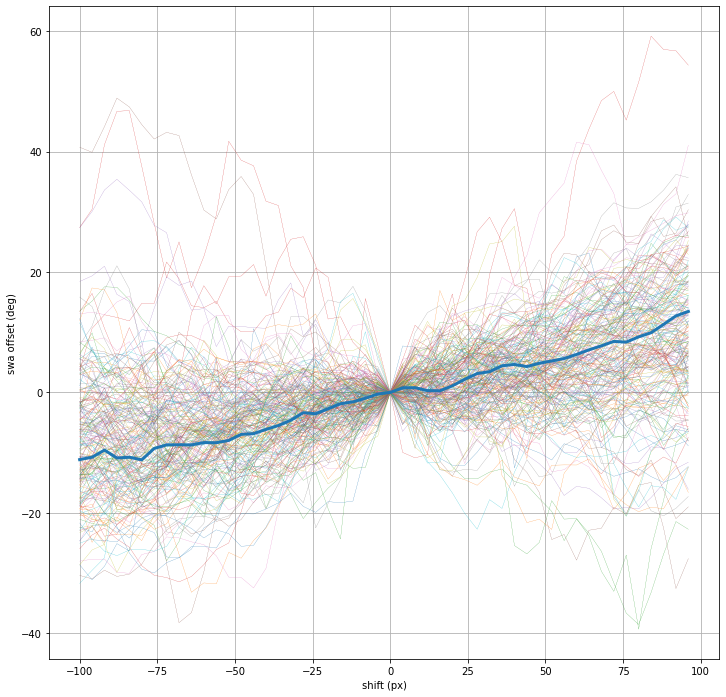

In [22]:
good_predictions = []
for prediction_list in predictions_lists:
    predictions = [element['predicted'] for element in prediction_list]
    ground_truths = [element['actual'] for element in prediction_list]
    base_pred = predictions[len(predictions)//2]
    base_gt = ground_truths[len(ground_truths)//2]
    error = abs(base_gt - base_pred)
    
    linewidth = 0.2
    if error < 10:
        linewidth = 0.2
        good_predictions.append(predictions)
    #plt.plot(shifts, np.asarray(prediction_list), linewidth = 0.5)
    plt.plot(shifts, np.asarray(predictions)-base_pred, linewidth = linewidth)

median_predictions = np.median(good_predictions, axis=0)
plt.plot(shifts, np.asarray(median_predictions)-median_predictions[len(median_predictions)//2], linewidth = 3)

plt.xlabel("shift (px)")
plt.ylabel("swa offset (deg)")
plt.grid()
plt.show()



# Lenkrad Winkelgeschwindigkeit

10464
10463


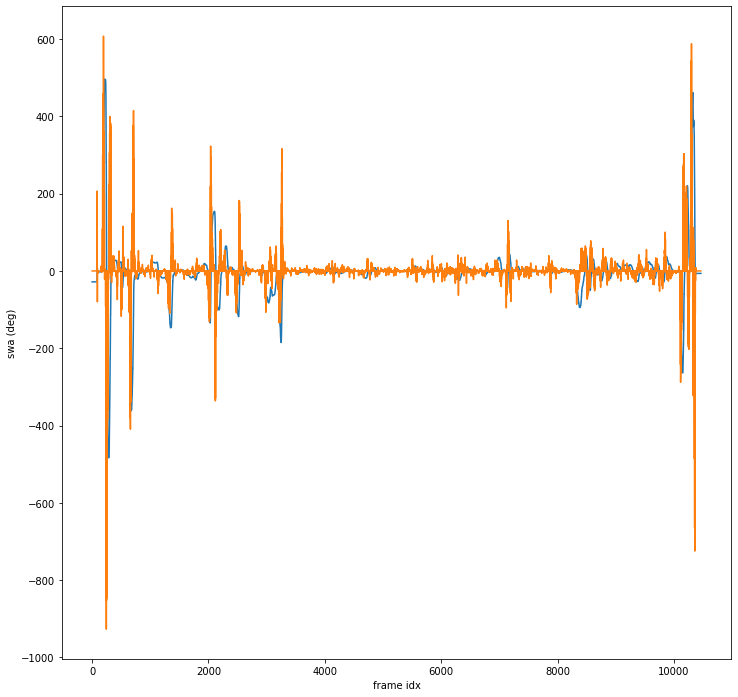

In [23]:
speeds = velocity_list[:]
angles = ground_truth[:] # deg
fps = 15
angular_speed = np.diff(angles)*fps # deg/s


idxs = range(1, len(angles)+1)
print(len(angles))
#print(angles)
print(len(angular_speed))
#print(angular_speed)

plt.plot(idxs, angles)
plt.plot(idxs[:len(angular_speed)], angular_speed)
plt.xlabel("frame idx")
plt.ylabel("swa (deg)")
plt.show()


In [24]:
speeds = np.asarray(speeds)
abs_angles = abs(np.asarray(angles))
abs_angular_speed = abs(angular_speed)

In [25]:
# get indices where abs(swa) > 45
invalid_angle_indxs = np.argwhere(abs_angles>45)

# get indices where speed < 25
invalid_speed_indxs = np.argwhere(speeds[:-1]<25)

In [26]:
# remove samples from angular speed array
abs_angular_speed[invalid_angle_indxs] = 0
abs_angular_speed[invalid_speed_indxs] = 0

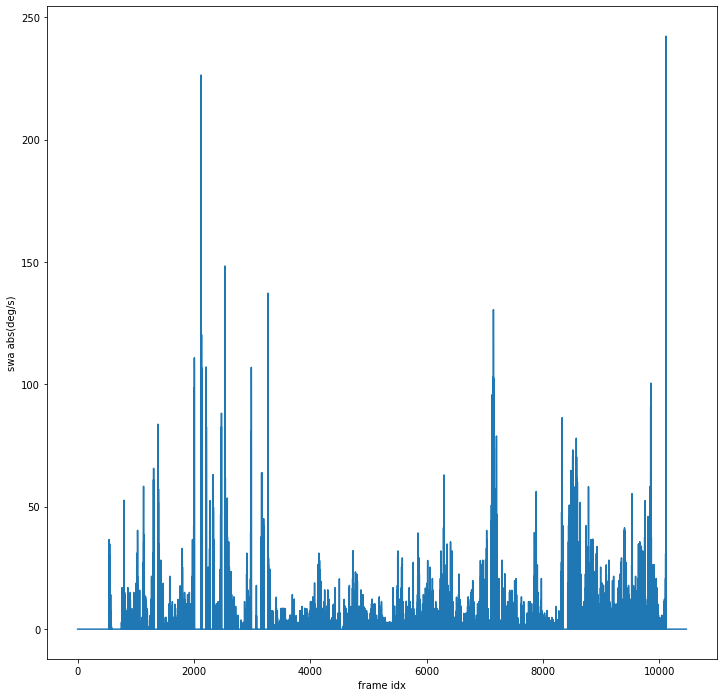

In [27]:
plt.plot(idxs[:len(abs_angular_speed)], abs_angular_speed)
plt.xlabel("frame idx")
plt.ylabel("swa abs(deg/s)")
plt.show()

In [28]:
qs = list(range(60,90,5))
qs.extend(list(range(90,101,1)))

for q in qs:
    print("{}th: {} deg/s".format(q, round(np.percentile(abs_angular_speed, q=q),1)))

60th: 0.0 deg/s
65th: 0.9 deg/s
70th: 1.9 deg/s
75th: 2.9 deg/s
80th: 4.6 deg/s
85th: 7.5 deg/s
90th: 11.2 deg/s
91th: 12.3 deg/s
92th: 14.1 deg/s
93th: 16.1 deg/s
94th: 17.9 deg/s
95th: 21.6 deg/s
96th: 25.3 deg/s
97th: 30.0 deg/s
98th: 37.6 deg/s
99th: 57.2 deg/s
100th: 242.2 deg/s
